# URAP STEM Persistence 

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import datetime
import math
import scipy
import plotly.express as px

from matplotlib import cm

In [2]:
# feel free to uncomment the options below if you want to manually inspect certain dataframes
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', 100)

plt.rcParams["figure.figsize"]= 20,7.5
plt.rcParams['font.size']= 18

### Loading Data
* `URAP Golden.csv`: a data file with 18,224 individuals with graduation years ranging from 1997 to 2023. This is a file that was manually cultivated based on 2 data sources receieved from the Campus Data Solutions team:
    * `URAP Race.csv`: receieved from the campus data solutions team that is a subset of the CADs data. It is already pre-filtered by the students who have participated in the URAP program, with participation being logged on CADs. This dataset had no NaN CLASSYR rows.
    * `URAP Name.csv`: new file from CADs that has 3,926 additional individuals that was matched based on first/last name and then cleaned
        * There are 202 rows that have missing CLASSYR (ie. graduation years). Upon inspection, all 202 of these individuals didn't seem to be UC Berkeley Students, but visiting scholars (ie. 'ATU UC Los Angeles Visitor', 'ATU UC Santa Cruz Visitor', etc). These 202 people were dropped.
* `Multi_Row_Race_Extracted.csv`: this is a file that is a subset of the Multi-row Data of all UC Berkeley Alumni that LiveAlumni sent us. This extracted file only contains the individuals with a Constituent ID that was also about of the individuals in `URAP Golden.csv`
* `companyInfo.csv`: this file is a relational mapping mainly used to associate a company with a industry based on the company name. The only criteria for this file is that both Company Name and Company Industry cannot be Null.

In [3]:
gold = pd.read_csv("data/URAP Golden.csv") 
# Note: this LiveAlumni data is already prefiltered to only contain matching IDs from Golden
live_alumni_multi_row = pd.read_csv('data/Multi_Row_Golden.csv')
company_info = pd.read_csv('data/companyInfo.csv')
gpa = pd.read_csv("data/Apprentices_Archive.csv")

/usr/local/Cellar/jupyterlab/3.1.14/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Cleaning Data

In [4]:
# Extracting only the year from the race `joined_uerap` column
gold["URAP_Year"] = gold["joined_uerap"].astype(str).apply(lambda x: x[:4])

The following merge is to try to associate the company name with the company industry. However, there are about ~10k rows that do not have a matching mapping for the Company Name Given. For now, we will drop these (by taking an inner join).

In [5]:
live_alumni_multi_row_industry = live_alumni_multi_row.merge(company_info[["Employment Company Name", "Company Industry Name"]], 
                            left_on = "CompanyName", right_on = "Employment Company Name", how="inner")#.dropna(subset=["StartYear", "Company Industry Name"])

In [6]:
la_individual = live_alumni_multi_row_industry #.groupby("Constituent ID").agg(list)#.agg(unique)
print(len(la_individual))
la_individual.head(2)

101229


Unnamed: 0  Constituent ID    Full Name  \
0          43        976381.0  Daniel Ganz   
1          44        976381.0  Daniel Ganz   

                                       Url    City       State Country  \
0  https://www.linkedin.com/in/danieljganz  Irvine  California     USA   
1  https://www.linkedin.com/in/danieljganz  Irvine  California     USA   

           Industry FirstName MiddleName LastName Nickname  \
0  Higher Education    Daniel        NaN     Ganz      NaN   
1  Higher Education    Daniel        NaN     Ganz      NaN   

                           University             Degree  \
0  University of California, Berkeley  Bachelor’s Degree   
1                   Leigh High School        High School   

                      Major  Start Date  EndDate  \
0  Economics, Legal Studies      2009.0   2012.0   
1                       NaN      2005.0   2009.0   

                          CompanyName  Company ID                    Title  \
0                            Poplicus         NaN  Senior Business Analyst   
1  UC Berkeley Ethnic Studies Library         NaN    Circulation Assistant   

   StartYear  StartMonth  EndYear  EndMonth Current/Past  \
0     2012.0        10.0   2015.0       8.0            P   
1     2009.0         8.0   2011.0       7.0            P   

  Suggested Primary - Needs Validation  Prefix  \
0                                False     NaN   
1                                False     NaN   

              Employment Company Name Company Industry Name  
0                            Poplicus  Information Services  
1  UC Berkeley Ethnic Studies Library      Higher Education

In [7]:
# combining both la_invidual with the URAP race dataset
merged = gold.merge(la_individual.reset_index(), left_on = "ENTITY_ID", right_on = "Constituent ID", how = "inner")
len(merged)

101229

# Manual Classification
There are two things that we need to classify/extract:
* STEM vs. Non-STEM Degrees
* STEM vs. Non-STEM Jobs and Industries
* Graduate vs. Non-Graduate Academic Degrees
    * Currently we do not do any farther analysis with this, as we ran out of time

### STEM vs. Non-STEM Degrees
Only extracting degrees that follow the format of `B.A./B.S. {Degree} YYYY` Pattern

In [8]:
# getting all the possible B.A. Degrees that exist in this dataset
# don't need to extract B.S. Degree since we assume that B.S. == STEM

# Uncomment below to see all possible B.A. Degrees
# set(gold["DEGREES"].str.split(';').explode().str.extract(r"B\.A\. (.+)+\d{4}").dropna()[0])

# Old option where we extract both B.S. and B.A. Degrees
# set(race["DEGREES"].str.split(';').explode().str.extract(r"(B\.A\.|B\.S\.) (.+)+\d{4}").dropna()[1])

In [9]:
BA_STEM_degrees = [
    'Applied Mathematics',
    'Architecture',
    'Astrophysics',
    'Atmospheric Science',
    'Chemistry',
    'City & Regional Planning', # new
    'Cognitive Science',
    'Computer Science',
    'Data Science ',
#     'Economics ',
    'Envir Science I: Physical Sci',
    'Environmental Earth Science',
    'Environmental Econ & Policy',
    'Environmental Sciences',
    'Environmental Studies', # new
#     'Geography ',
    'Geology',
    'Geophysics',
    'Human Biodynamics',
    'Integrative Biology',
#     'Linguistics ',
    'Marine Science',
    'Mathematics',
    'Microbiology & Immunology', # new
    'Molecular & Cell Bio: Biochem/Molecular',
    'Molecular & Cell Bio: Cell & Development',
    'Molecular & Cell Bio: Genetics',
    'Molecular & Cell Bio: Immunology',
    'Molecular & Cell Bio: Neurobiology',
    'Molecular & Cell Biology',
    'Physical Sciences',
    'Physics',
    'Planetary Science',
    'Psychology',
    'Public Health',
    'Statistics',
    'Sustainable Environmental Design',

]

### STEM vs. Non-STEM Jobs
Remember that there are about ~10k job rows that are missing a company industry

In [10]:
# Uncomment below to see all possible Company Industries
# set(live_alumni_multi_row_industry["Company Industry Name"].explode())

In [11]:
STEM_company_industry = [
    'Accounting',
    'Airlines/Aviation',
    'Alternative Medicine',
    'Animation',
    'Architecture & Planning',
    'Automotive',
    'Aviation & Aerospace',
    'Banking',
    'Biotechnology',
    'Chemicals',
    'Civil Engineering',
    'Computer & Network Security',
    'Computer Games',
    'Computer Hardware',
    'Computer Networking',
    'Computer Software',
    'Construction',
    'Consumer Electronics',
    'Defense & Space',
    'Design',
    'E-Learning',
    'Electrical/Electronic Manufacturing',
    'Environmental Services',
    'Food Production',
    'Hospital & Health Care',
    'Industrial Automation',
    'Information Services',
    'Information Technology and Services',
    'Internet',
    'Logistics and Supply Chain',
    'Machinery',
    'Mechanical or Industrial Engineering',
    'Medical Devices',
    'Medical Practice',
    'Museums and Institutions',
    'Nanotechnology',
    'Oil & Energy',
    'Pharmaceuticals',
    'Plastics',
    'Renewables & Environment',
    'Semiconductors',
    'Telecommunications',
    'Utilities',
    'Veterinary',
    'Wireless',
]

### Graduate Degrees
Currently, we only consider a degree to be a Graduate Degree if it is a Masters, PhD or J.D. degree.

WE CURRENTLY DO NOT DO ANY ANALYSIS WITH THIS!

In [12]:
la_degrees = la_individual["Degree"].explode().dropna()
# proxy for Masters and Ph.D Degrees
m_p_in = la_degrees.apply(lambda x: ("m" in x.lower()) or ("p" in x.lower()))
master_phd_in = la_degrees.apply(lambda x: 
                                 (
                                     ("m." in x.lower()) or
                                     ("master" in x.lower()) or
                                     ("md" in x.lower()) or
                                     ("m.d." in x.lower()) or
                                     ("ph.d" in x.lower()) or
                                     ("phd" in x.lower()) or
                                     ("p.h.d" in x.lower()) or
                                     ("jd" in x.lower()) or
                                     ("j.d." in x.lower())
                                 )
                                 and 
                                 (
                                     not(x == "Headmaster's Honors List") and
                                     not(x =='Negotiation Mastery: Unlocking Value in the Real world')
                                 )
                             )
# set(la_degrees[m_p_in]) - set(la_degrees[master_phd_in])
# print(len(set(la_degrees[master_phd_in])))
# set(la_degrees[master_phd_in])

## Checking STEM Persistence Within Given Years
Based on the manual classifications defined above, we will look a given number of X years after graduation (assumed to be as `PREF_CLASS_YR`) to see if within X years after graduation an individual has gotten a STEM graduate degree or STEM related job. 

Currently, we only define "persistence" to be if a student with an Undergrad STEM degree gets a job in a STEM Company Industry. We realize that this isn't the most accurate classification of persistence, so a more rigorous classification of "STEM Persistence" is definitely something on the to do list.

In [13]:
def is_STEM_ugrad_degree(degree):
    # helper function to classify if a degree is a STEM degree
    to_match = degree.lower()
    bs = "b.s." in to_match
    ba_stem = any(x.lower() in to_match for x in BA_STEM_degrees)
    
    return (bs or ba_stem)

In [14]:
def is_STEM_job(company_industry):
    # helper function to classify if a company industry is a STEM industry
    if type(company_industry) == float:
        return np.nan
    return company_industry in STEM_company_industry

In [15]:
X_yrs_graduate_degree = 2
Y_yrs_STEM_job = 5

In [16]:
# determining if the degree and the company industry are classfied as a stem
merged["Is STEM Industry"] = merged["Company Industry Name"].apply(is_STEM_job)
merged["Is STEM Degree"] = merged["DEGREES"].apply(is_STEM_ugrad_degree)

In [17]:
total = merged.copy(deep=True)
# get difference between job start year and and graduation year
total["Yrs Grad"] = total["StartYear"] - total["CLASSYR"]

total = total[["ENTITY_ID", "Is STEM Industry", "Yrs Grad"]]
# only considering jobs that are within Y amount of years from graduation, as defined above
total = total[(0 <= total["Yrs Grad"]) & (total["Yrs Grad"]<= Y_yrs_STEM_job)]
STEM_persistence = total.groupby("ENTITY_ID").agg(any)["Is STEM Industry"]
STEM_persistence = STEM_persistence.rename(f"STEM Job Within {Y_yrs_STEM_job} Years")


In [18]:
final = merged[["CLASSYR", "DEGREES", "ethnicity", "GENDER", "ENTITY_ID", "Is STEM Degree"]].drop_duplicates()
final = final.merge(STEM_persistence, on="ENTITY_ID", how="outer")
final = final.rename(columns={"CLASSYR": "Class Year", "DEGREES": "Degrees", "ethnicity": "Ethnicity", "GENDER": "Gender","ENTITY_ID": "ID"})

# subsequent analysis are better if the truth statements are encoded as floats instead of booleans
final["Is STEM Degree"] = final["Is STEM Degree"].apply(lambda x: float(int(x)))
final["STEM Job Within 5 Years"] = final["STEM Job Within 5 Years"].apply(lambda x: float(int(x)) if type(x) == bool else np.nan)

In [19]:
consolidated = final
# only getting people who graduated from 2020 and before since past 2020 we have less data
consolidated = consolidated[consolidated["Class Year"] <= 2020]
consolidated

Class Year                                            Degrees  \
0           2001                  B.S. Business Administration 2001   
1           2005  B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...   
2           2005                           B.S. Bioengineering 2005   
3           2004           B.S. Nuclear Engineering: Undergrad 2004   
4           2007    B.A. Classical Languages 2007; M.A. Design 2012   
...          ...                                                ...   
7783        2020                           B.A. Global Studies 2020   
7784        2020                         B.A. Computer Science 2020   
7785        2020                        B.S. Microbial Biology 2020   
7786        2020                      B.A. Integrative Biology 2020   
7787        2020                             B.A. Anthropology 2020   

             Ethnicity Gender       ID  Is STEM Degree  \
0                White      F   724202             1.0   
1                Asian      M   729526             0.0   
2                Asian      M   732926             1.0   
3                Asian      M   746450             1.0   
4     Decline to State      M   754146             0.0   
...                ...    ...      ...             ...   
7783  Decline to State      M  3468738             0.0   
7784    Chicano/Latino      M  3468968             1.0   
7785             Asian      F  3468993             1.0   
7786             Asian      D  3469873             1.0   
7787    Chicano/Latino      M  3711424             0.0   

      STEM Job Within 5 Years  
0                         NaN  
1                         0.0  
2                         0.0  
3                         1.0  
4                         NaN  
...                       ...  
7783                      NaN  
7784                      NaN  
7785                      0.0  
7786                      NaN  
7787                      0.0  

[7784 rows x 7 columns]

## Data Analysis
With `consolidated` as the table of cleaned information, we can finally start doing some data analysis!

### URAP Analysis
Analysis of the Makeup of URAP. No STEM persistence analysis yet.

#### Analysis: What % of men and women for each race/ethnicity went through the program each year?

In [20]:
def colormap(n, reverse=False):
    # feel free to uncomment these cells if you wanted to implement an alternate color map!
    name = "twilight_shifted"
#     name = "gist_ncar"
#     name = "prism"
#     if reverse:
#         return sns.color_palette(name, n)[::-1]
    return None #sns.color_palette(name, n)

In [21]:
def normalize(df, percent=False, axis=0):
    # helper function to change counts to percentages
    if axis == 1:
        df = df.transpose()
    
    for col in df.columns:
        df[col] = df[col]/sum(df[col])
        
        if percent:
            df[col] *= 100
            
    if axis == 1:
        df = df.transpose()
    
    return df

Class Year                     1997  1998  1999  2000  2001  2002  2003  2004  \
Ethnicity                                                                       
African American                0.0   1.0   1.0   0.0   2.0   1.0   3.0   1.0   
Asian                           5.0   9.0   9.0  18.0   6.0  16.0  26.0  25.0   
Chicano/Latino                  0.0   1.0   3.0   1.0   0.0   3.0   5.0   4.0   
Decline to State                0.0   1.0   4.0   4.0   3.0   6.0   5.0   6.0   
Native American/Alaska Native   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   
Other                           0.0   0.0   2.0   0.0   0.0   1.0   2.0   1.0   
Pacific Islander                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
White                           0.0   8.0  10.0  23.0   8.0  24.0  33.0  27.0   

Class Year                     2005  2006  2007   2008   2009   2010   2011  \
Ethnicity                                                                     
African American                1.0   2.0   4.0    1.0    6.0    7.0    8.0   
Asian                          53.0  76.0  99.0  108.0  131.0  174.0  236.0   
Chicano/Latino                  3.0  10.0  16.0   11.0   28.0   31.0   39.0   
Decline to State                8.0  14.0  25.0   28.0   28.0   30.0   36.0   
Native American/Alaska Native   0.0   1.0   1.0    1.0    0.0    1.0    1.0   
Other                           0.0   4.0   4.0    2.0    2.0    1.0    0.0   
Pacific Islander                0.0   0.0   0.0    2.0    0.0    3.0    2.0   
White                          36.0  51.0  59.0   77.0  136.0  142.0  127.0   

Class Year                      2012   2013   2014   2015   2016   2017  \
Ethnicity                                                                 
African American                 8.0   13.0    9.0   11.0   12.0   25.0   
Asian                          236.0  248.0  300.0  330.0  339.0  396.0   
Chicano/Latino                  33.0   48.0   54.0   71.0   71.0   72.0   
Decline to State                47.0   38.0   23.0   16.0   18.0   46.0   
Native American/Alaska Native    1.0    2.0    3.0    6.0    2.0    2.0   
Other                            0.0    0.0    0.0    0.0    0.0    0.0   
Pacific Islander                 0.0    1.0    0.0    0.0    0.0    0.0   
White                          183.0  202.0  233.0  213.0  177.0  203.0   

Class Year                      2018   2019   2020  
Ethnicity                                           
African American                18.0   15.0   15.0  
Asian                          356.0  338.0  293.0  
Chicano/Latino                  97.0   72.0   41.0  
Decline to State                27.0   40.0   35.0  
Native American/Alaska Native    7.0    9.0    0.0  
Other                            0.0    0.0    0.0  
Pacific Islander                 2.0    1.0    2.0  
White                          196.0  186.0  166.0

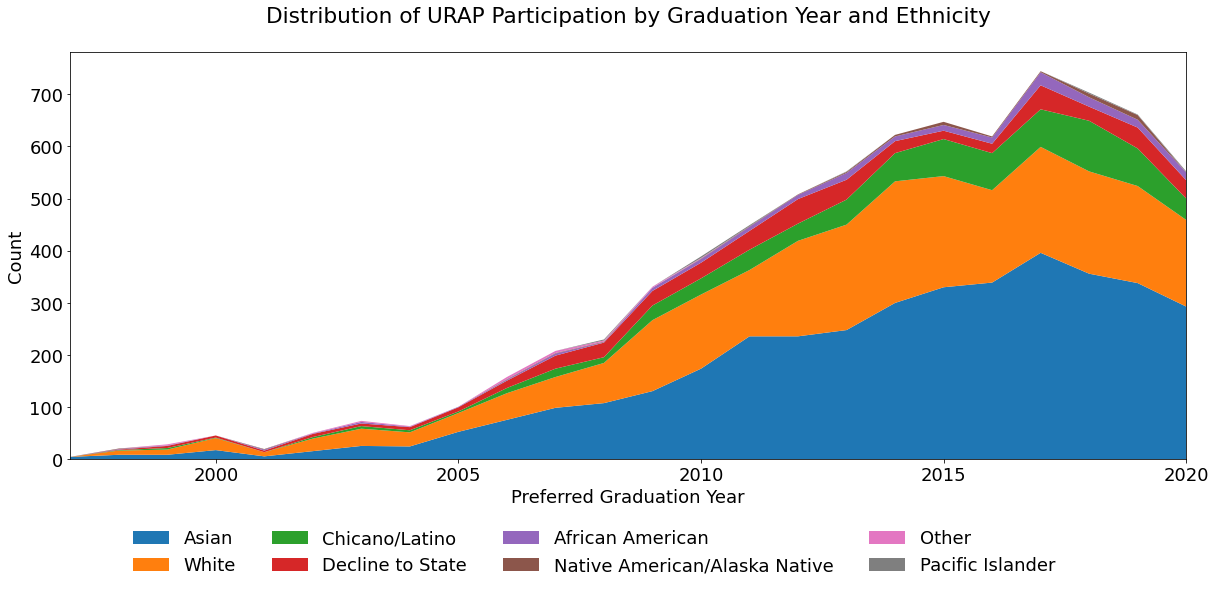

In [22]:
# plotting the counts by different ethnicities/races over the year
ethnicity_by_year = consolidated.pivot_table(
    values="ID",
    index="Ethnicity",
    columns="Class Year",
    aggfunc=len
).fillna(0)

display(ethnicity_by_year)

sorted_by_desc_ethnicity = consolidated.groupby("Ethnicity").count().sort_values("ID", ascending=False).index

# ordering the dataframe by decreasing proportions of ethnicity
ethnicity_by_year = ethnicity_by_year.loc[sorted_by_desc_ethnicity]

plt.stackplot(list(ethnicity_by_year.columns), np.array(ethnicity_by_year),
              labels=sorted_by_desc_ethnicity,
              colors=colormap(8)
             )

plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity\n")

plt.xlim([min(ethnicity_by_year.columns), max(ethnicity_by_year.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.05, -0.3), ncol=4,
            borderaxespad=0, frameon=False)

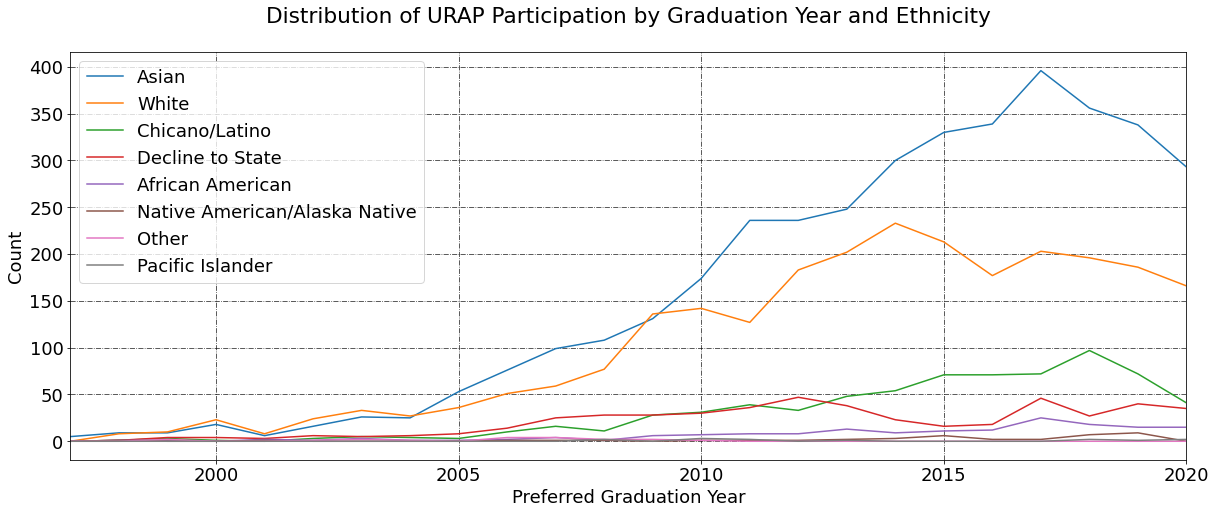

In [23]:
#New Visualization

x = np.linspace(0, 7, 100)
line1, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[0], label=ethnicity_by_year.iloc[0].name)
line2, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[1], label=ethnicity_by_year.iloc[1].name)
line3, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[2], label=ethnicity_by_year.iloc[2].name)
line4, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[3], label=ethnicity_by_year.iloc[3].name)
line5, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[4], label=ethnicity_by_year.iloc[4].name)
line6, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[5], label=ethnicity_by_year.iloc[5].name)
line7, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[6], label=ethnicity_by_year.iloc[6].name)
line8, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[7], label=ethnicity_by_year.iloc[7].name)
plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8], loc='best')
plt.grid(b=True, color='black', alpha=0.8, linestyle='dashdot')
plt.xlim([min(ethnicity_by_year.columns), max(ethnicity_by_year.columns)])
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity\n")
plt.show()

Class Year                      1997       1998       1999       2000  2001  \
Ethnicity                                                                     
Asian                          100.0  42.857143  31.034483  39.130435  30.0   
White                            0.0  38.095238  34.482759  50.000000  40.0   
Chicano/Latino                   0.0   4.761905  10.344828   2.173913   0.0   
Decline to State                 0.0   4.761905  13.793103   8.695652  15.0   
African American                 0.0   4.761905   3.448276   0.000000  10.0   
Native American/Alaska Native    0.0   4.761905   0.000000   0.000000   5.0   
Other                            0.0   0.000000   6.896552   0.000000   0.0   
Pacific Islander                 0.0   0.000000   0.000000   0.000000   0.0   

Class Year                          2002       2003     2004       2005  \
Ethnicity                                                                 
Asian                          31.372549  35.135135  39.0625  52.475248   
White                          47.058824  44.594595  42.1875  35.643564   
Chicano/Latino                  5.882353   6.756757   6.2500   2.970297   
Decline to State               11.764706   6.756757   9.3750   7.920792   
African American                1.960784   4.054054   1.5625   0.990099   
Native American/Alaska Native   0.000000   0.000000   0.0000   0.000000   
Other                           1.960784   2.702703   1.5625   0.000000   
Pacific Islander                0.000000   0.000000   0.0000   0.000000   

Class Year                          2006       2007       2008       2009  \
Ethnicity                                                                   
Asian                          48.101266  47.596154  46.956522  39.577039   
White                          32.278481  28.365385  33.478261  41.087613   
Chicano/Latino                  6.329114   7.692308   4.782609   8.459215   
Decline to State                8.860759  12.019231  12.173913   8.459215   
African American                1.265823   1.923077   0.434783   1.812689   
Native American/Alaska Native   0.632911   0.480769   0.434783   0.000000   
Other                           2.531646   1.923077   0.869565   0.604230   
Pacific Islander                0.000000   0.000000   0.869565   0.000000   

Class Year                          2010       2011       2012       2013  \
Ethnicity                                                                   
Asian                          44.730077  52.561247  46.456693  44.927536   
White                          36.503856  28.285078  36.023622  36.594203   
Chicano/Latino                  7.969152   8.685969   6.496063   8.695652   
Decline to State                7.712082   8.017817   9.251969   6.884058   
African American                1.799486   1.781737   1.574803   2.355072   
Native American/Alaska Native   0.257069   0.222717   0.196850   0.362319   
Other                           0.257069   0.000000   0.000000   0.000000   
Pacific Islander                0.771208   0.445434   0.000000   0.181159   

Class Year                          2014       2015       2016       2017  \
Ethnicity                                                                   
Asian                          48.231511  51.004637  54.765751  53.225806   
White                          37.459807  32.921175  28.594507  27.284946   
Chicano/Latino                  8.681672  10.973725  11.470113   9.677419   
Decline to State                3.697749   2.472952   2.907916   6.182796   
African American                1.446945   1.700155   1.938611   3.360215   
Native American/Alaska Native   0.482315   0.927357   0.323102   0.268817   
Other                           0.000000   0.000000   0.000000   0.000000   
Pacific Islander                0.000000   0.000000   0.000000   0.000000   

Class Year                          2018       2019       2020  
Ethnicity                                                       
Asian          

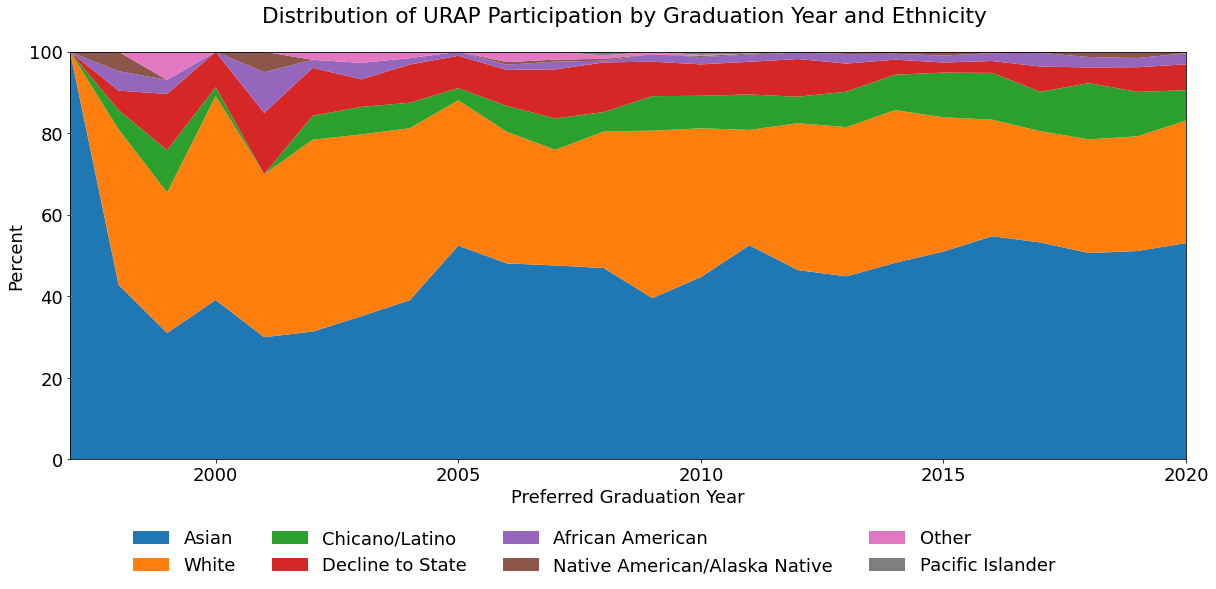

In [24]:
# normalizing the ethnicity by year graph to get relative proportions
ethnicity_by_year = normalize(ethnicity_by_year, True)
display(ethnicity_by_year)

plt.stackplot(list(ethnicity_by_year.columns), np.array(ethnicity_by_year),
              labels=sorted_by_desc_ethnicity,
              colors=colormap(8)
             )

plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity \n")

plt.xlim([min(ethnicity_by_year.columns), max(ethnicity_by_year.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.05, -0.3), ncol=4,
            borderaxespad=0, frameon=False)

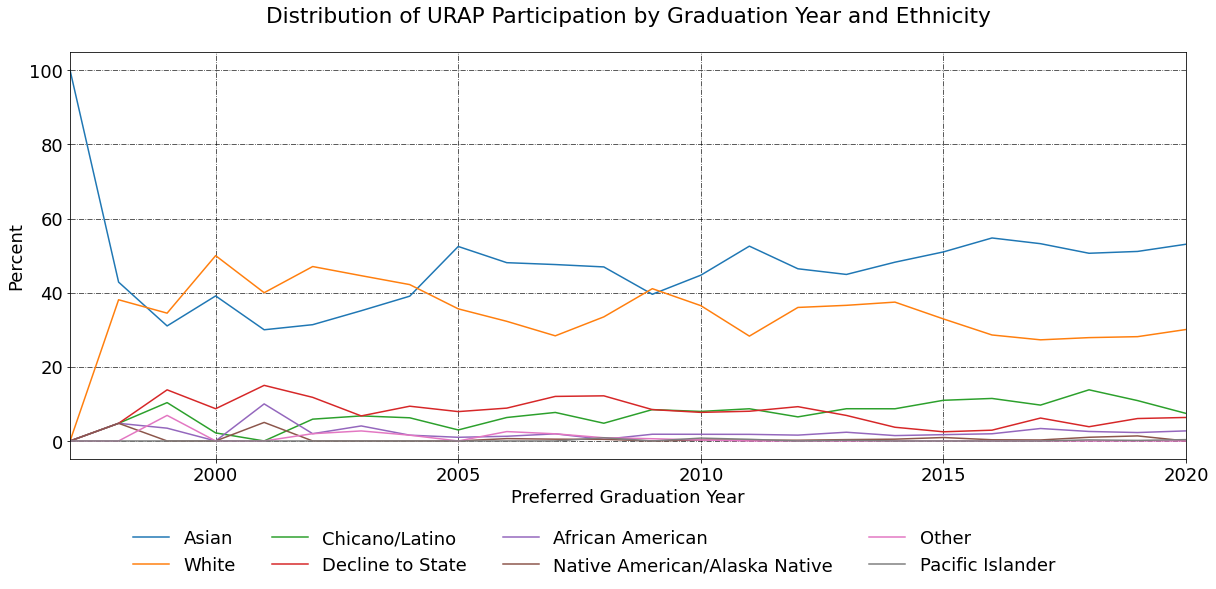

In [25]:
#New Visualization
x = np.linspace(0, 7, 100)
line1, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[0], label=ethnicity_by_year.iloc[0].name)
line2, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[1], label=ethnicity_by_year.iloc[1].name)
line3, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[2], label=ethnicity_by_year.iloc[2].name)
line4, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[3], label=ethnicity_by_year.iloc[3].name)
line5, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[4], label=ethnicity_by_year.iloc[4].name)
line6, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[5], label=ethnicity_by_year.iloc[5].name)
line7, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[6], label=ethnicity_by_year.iloc[6].name)
line8, = plt.plot(list(ethnicity_by_year.columns), ethnicity_by_year.iloc[7], label=ethnicity_by_year.iloc[7].name)
plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8], loc='best')
plt.grid(b=True, color='black', alpha=0.8, linestyle='dashdot')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.xlim([min(ethnicity_by_year.columns), max(ethnicity_by_year.columns)])
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity\n")
plt.legend(loc='lower left', bbox_to_anchor= (0.05, -0.3), ncol=4,
            borderaxespad=0, frameon=False)
plt.show()

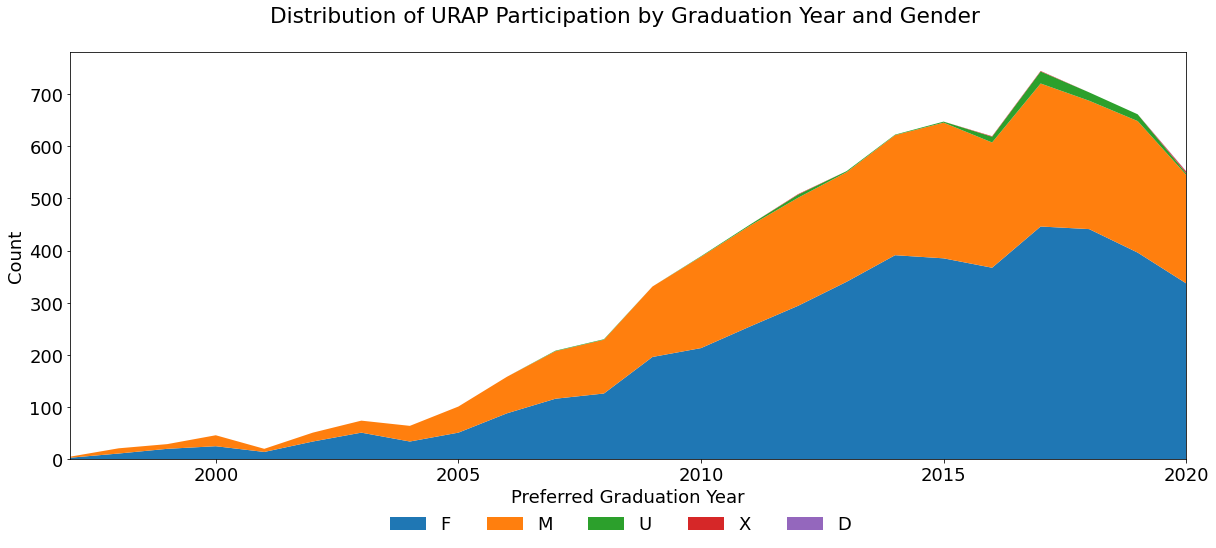

In [26]:
# plotting the counts by different genders over the year
gender_by_year = consolidated.pivot_table(
    values="ID",
    index="Gender",
    columns="Class Year",
    aggfunc=len
).fillna(0)

# plt.stackplot(list(gender_by_year.columns), 
#               list(gender_by_year.loc["F"]),
#               list(gender_by_year.loc["M"]),
#               np.array(gender_by_year.loc["X"]) + np.array(gender_by_year.loc["U"]) + np.array(gender_by_year.loc["D"]),
#               labels=["Female", "Male", "Other"],
#               colors=colormap(3)
#              )

sorted_by_desc_gender = consolidated.groupby("Gender").count().sort_values("ID", ascending=False).index
gender_by_year = gender_by_year.loc[sorted_by_desc_gender]

plt.stackplot(list(gender_by_year.columns), np.array(gender_by_year),
              labels=sorted_by_desc_gender,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Gender \n")

plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.28, -0.2), ncol=8,
            borderaxespad=0, frameon=False)

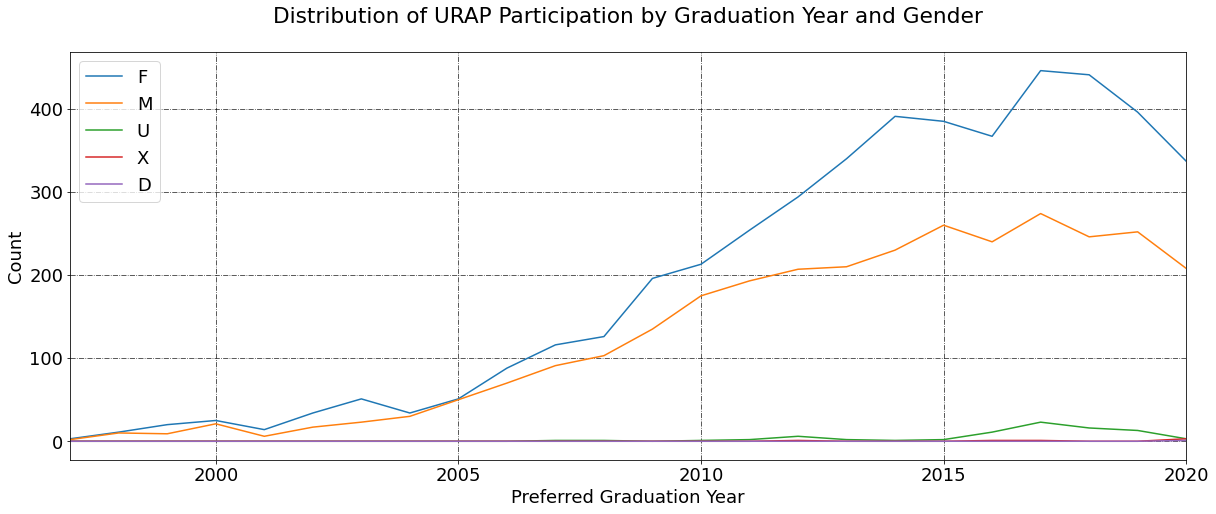

In [27]:
x = np.linspace(0, 7, 100)
line1, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[0], label=gender_by_year.iloc[0].name)
line2, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[1], label=gender_by_year.iloc[1].name)
line3, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[2], label=gender_by_year.iloc[2].name)
line4, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[3], label=gender_by_year.iloc[3].name)
line5, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[4], label=gender_by_year.iloc[4].name)

plt.legend(handles=[line1, line2, line3, line4, line5], loc='best')
plt.grid(b=True, color='black', alpha=0.8, linestyle='dashdot')
plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Gender\n")
plt.show()

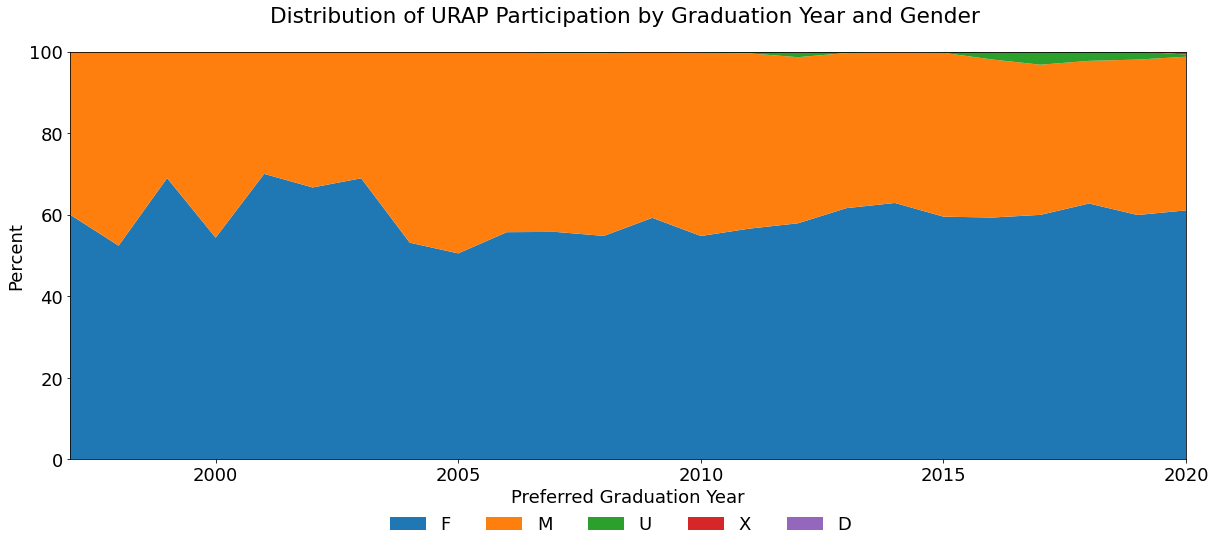

In [28]:
# plotting the percentages by different ethnicities/races over the year
gender_by_year = normalize(gender_by_year, True)

plt.stackplot(list(gender_by_year.columns), np.array(gender_by_year),
              labels=sorted_by_desc_gender,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of URAP Participation by Graduation Year and Gender \n")

plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.28, -0.2), ncol=8,
            borderaxespad=0, frameon=False);

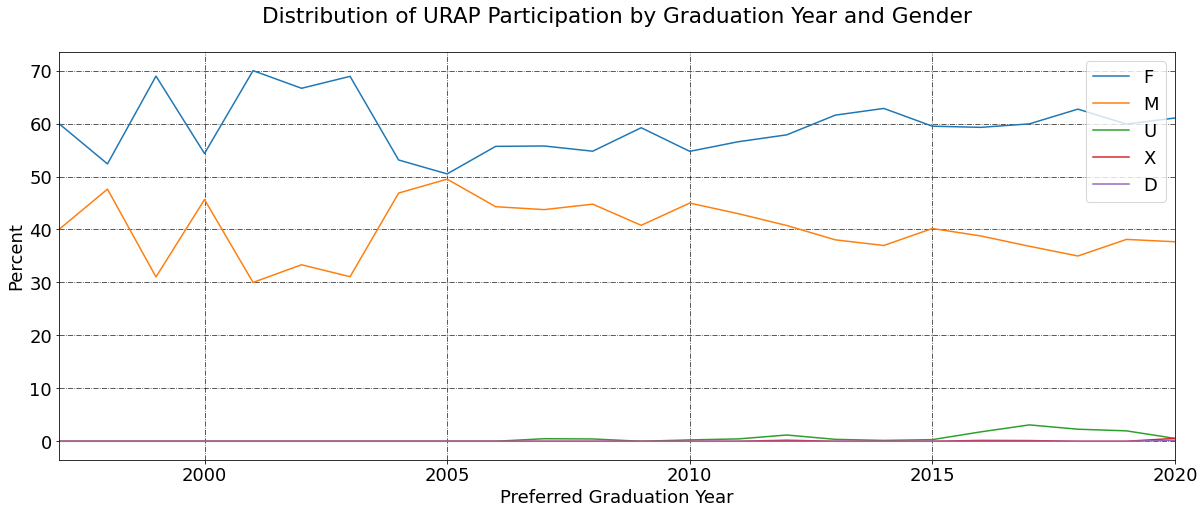

In [29]:
#New Visualization
x = np.linspace(0, 7, 100)
line1, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[0], label=gender_by_year.iloc[0].name)
line2, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[1], label=gender_by_year.iloc[1].name)
line3, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[2], label=gender_by_year.iloc[2].name)
line4, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[3], label=gender_by_year.iloc[3].name)
line5, = plt.plot(list(gender_by_year.columns), gender_by_year.iloc[4], label=gender_by_year.iloc[4].name)

plt.legend(handles=[line1, line2, line3, line4, line5], loc='best')
plt.grid(b=True, color='black', alpha=0.8, linestyle='dashdot')
plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of URAP Participation by Graduation Year and Gender\n")
plt.show()

/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/955328102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consolidated["Simple Gender"] = consolidated["Gender"].apply(switch)
/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/955328102.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consolidated["Ethnicity and Gender"] = consolidated["Ethnicity"] + " " + consolidated["Simple Gender"]


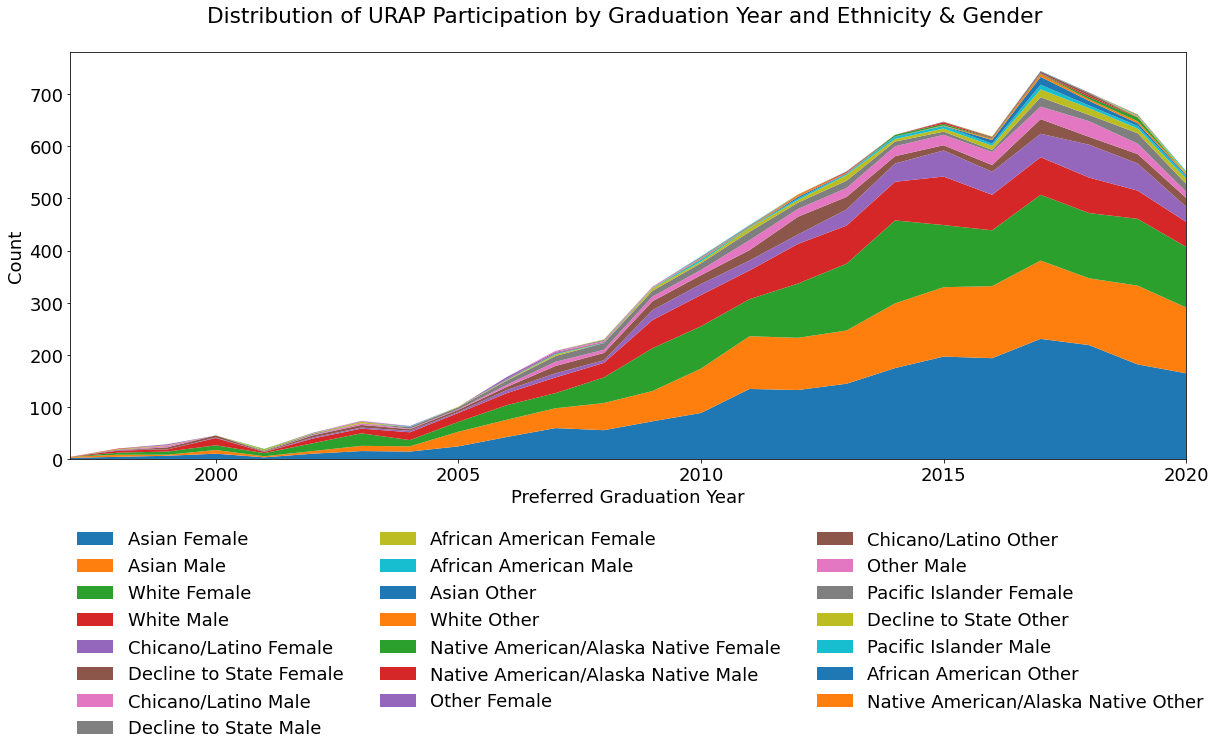

In [30]:
# plotting the counts by different ethnicities/races AND gender over the year
def switch(string):
    if string == 'F':
        return "Female"
    elif string == 'M':
        return "Male"
    else:
        return "Other"

consolidated["Simple Gender"] = consolidated["Gender"].apply(switch)
consolidated["Ethnicity and Gender"] = consolidated["Ethnicity"] + " " + consolidated["Simple Gender"]

ethnicity_gender = consolidated.pivot_table(
    values="ID",
    index="Ethnicity and Gender",
    columns="Class Year",
    aggfunc=len
).fillna(0)

ethnicity_gender_counts = consolidated.groupby("Ethnicity and Gender").count()["ID"].rename("Count")
ethnicity_gender["Counts"] = ethnicity_gender_counts
eg = ethnicity_gender.sort_values("Counts", ascending=False).drop(columns=["Counts"])

plt.stackplot(list(eg.columns), np.array(eg), 
              labels=list(eg.index), 
              colors=colormap(len(list(eg.index)), True)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity & Gender \n")

plt.xlim([min(eg.columns), max(eg.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.00, -0.7), ncol=3,
            borderaxespad=0, frameon=False)

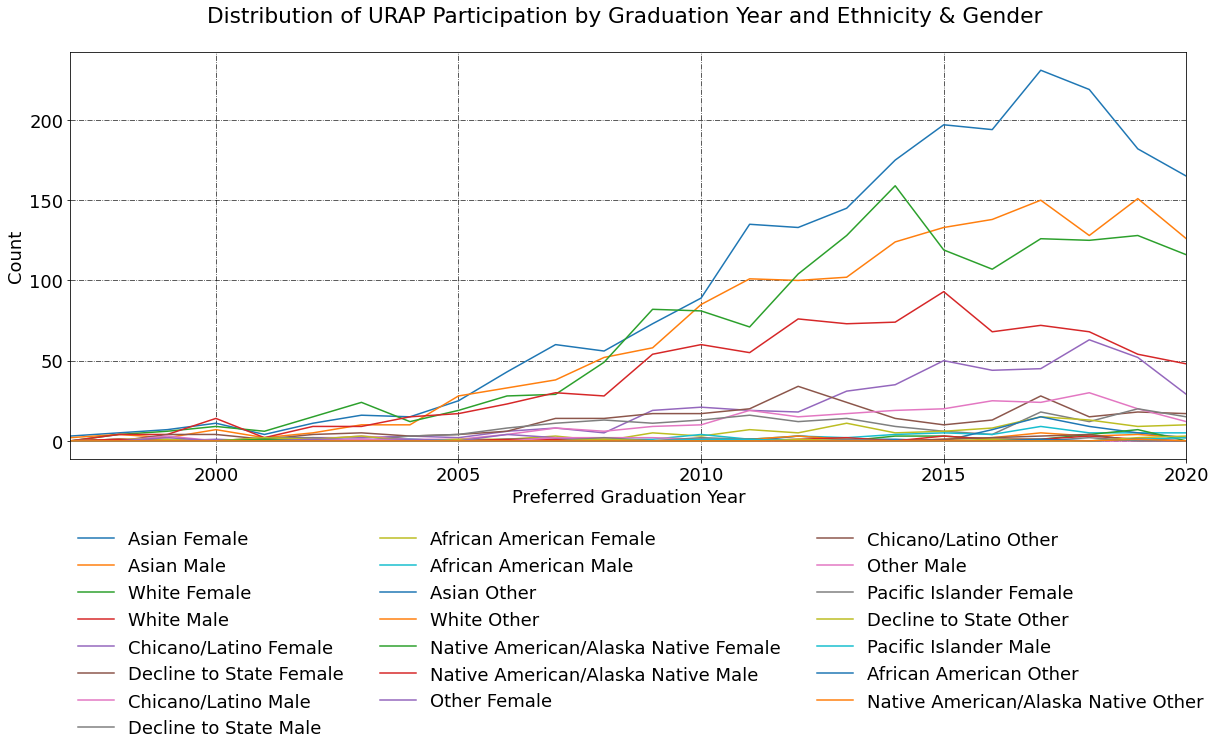

In [31]:
#New Visualization
x = np.linspace(0, 7, 100)
for i in np.arange(0, eg.shape[0]):
    line = plt.plot(list(eg.columns), eg.iloc[i], label=eg.iloc[i].name)

plt.grid(b=True, color='black', alpha=0.8, linestyle='dashdot')
plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity & Gender \n")
plt.xlim([min(eg.columns), max(eg.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.00, -0.7), ncol=3,
            borderaxespad=0, frameon=False)
plt.show()

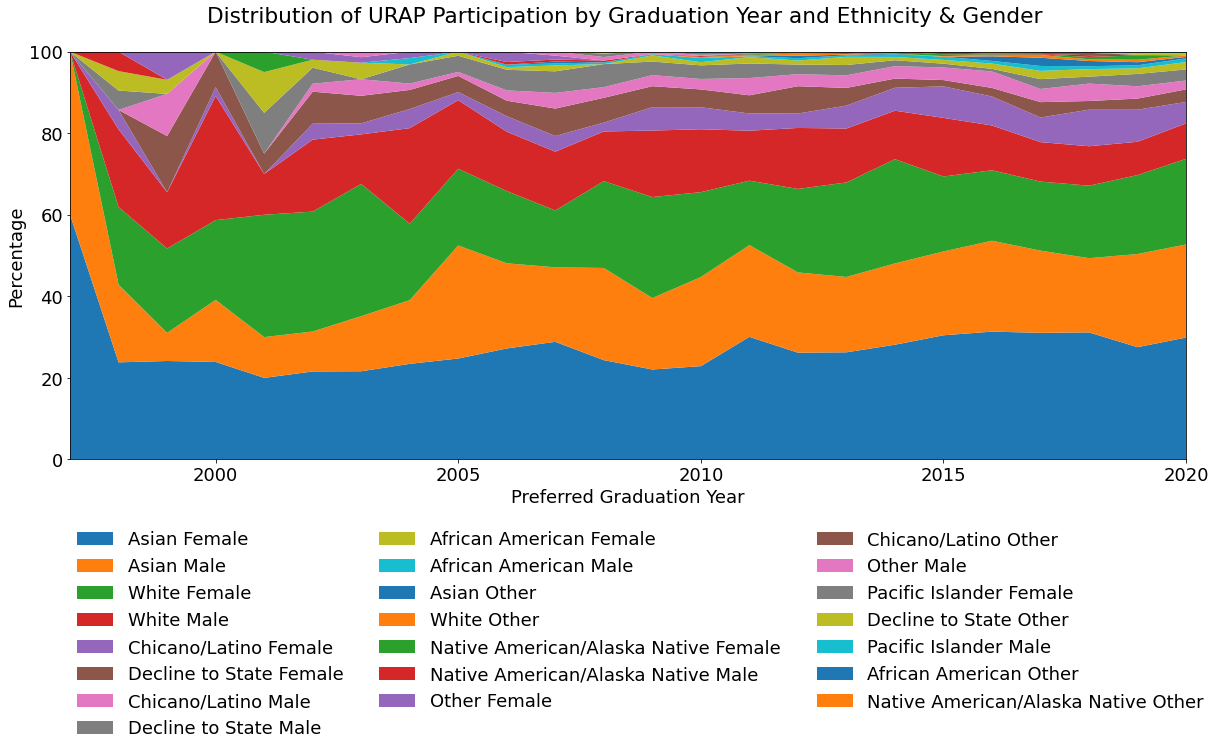

In [32]:
# plotting the percentages by different ethnicities/races AND gender over the year
eg = normalize(eg, True)

plt.stackplot(list(eg.columns), np.array(eg), 
              labels=list(eg.index), 
              colors=colormap(len(list(eg.index)), True)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percentage")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity & Gender \n")

plt.xlim([min(eg.columns), max(eg.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.00, -0.7), ncol=3,
            borderaxespad=0, frameon=False)

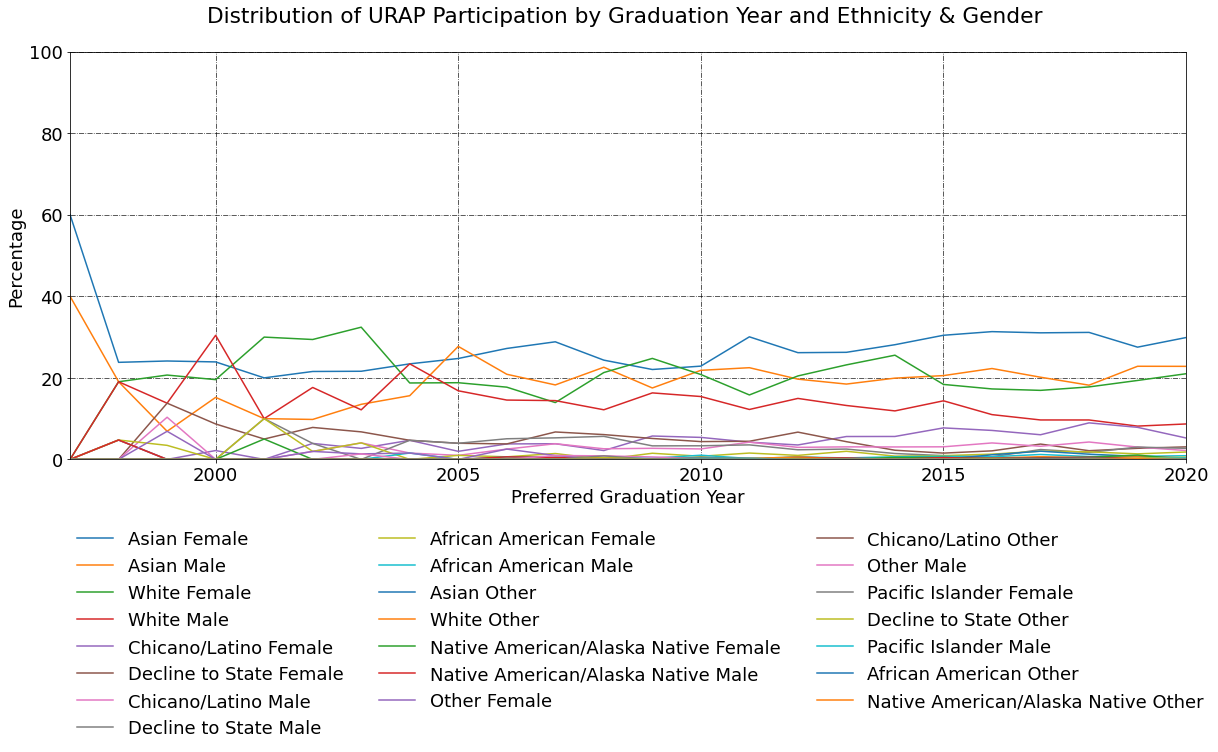

In [33]:
#New Visualization
x = np.linspace(0, 10, 100)
for i in np.arange(0, eg.shape[0]):
    line = plt.plot(list(eg.columns), eg.iloc[i], label=eg.iloc[i].name)

#plt.legend(handles=[line1, line2, line3, line4, line5], loc='best')
plt.grid(b=True, color='black', alpha=0.8, linestyle='dashdot')
plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percentage")
plt.title("Distribution of URAP Participation by Graduation Year and Ethnicity & Gender \n")
plt.xlim([min(eg.columns), max(eg.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.00, -0.7), ncol=3,
            borderaxespad=0, frameon=False)
plt.show()

#### Analysis: Top majors per race/gender breakdown.
Only extracting degrees that follow the format of `B.A./B.S. {Degree} YYYY` Pattern.

In [34]:
# consolidated.set_index('ID')["Degrees"].str.split(';').explode()

In [35]:
def get_top_n(top_n, get_other=False):
    # gets the top_n degrees by count and filters resulting table to only have these top degrees
    degree_extract = consolidated.set_index('ID')["Degrees"].str.split(';').explode().str.extract(r"(B\.A\.|B\.S\.) (.+)+\d{4}").reset_index()

    exploded_degree = consolidated.merge(degree_extract.rename(columns={1: "Degree"}), on="ID", how="outer")
    
    # hardcoding replacement of certain majors
    exploded_degree['Degree'] = exploded_degree["Degree"].replace('Electrical Engr & Comp Sci: Undergrad ',
                                                                  'Elec. Engr. CS').replace('Molecular & Cell Bio: Cell & Development ', 
                                                                                  'MCB: Cell & Dev.')
    
    top_n_degrees = exploded_degree.groupby("Degree").count().sort_values("ID", ascending=False)[:top_n]
    percent_captured = sum(top_n_degrees["ID"])/len(exploded_degree) * 100
    print(f"Top {top_n} Degrees capture {percent_captured}% of the data.")
    
    top_n_degrees = list(top_n_degrees.index)

    if get_other:
        only_top_degrees_df = exploded_degree#[exploded_degree["Degree"].isin(top_n_degrees)]
        
        # if we want to preserve the other degrees
        temp = only_top_degrees_df.copy(deep=True)
        non_top = temp[~(temp["Degree"].isin(top_n_degrees))]
        non_top.loc[:, "Degree"] = "Other"
        
        only_top_degrees_df = pd.concat([temp[temp["Degree"].isin(top_n_degrees)], non_top])
        top_n_degrees += ["Other"]
    else:
        only_top_degrees_df = exploded_degree[exploded_degree["Degree"].isin(top_n_degrees)]
    
    return top_n_degrees, only_top_degrees_df, percent_captured, exploded_degree

Top 15 Degrees capture 46.11425196185976% of the data.


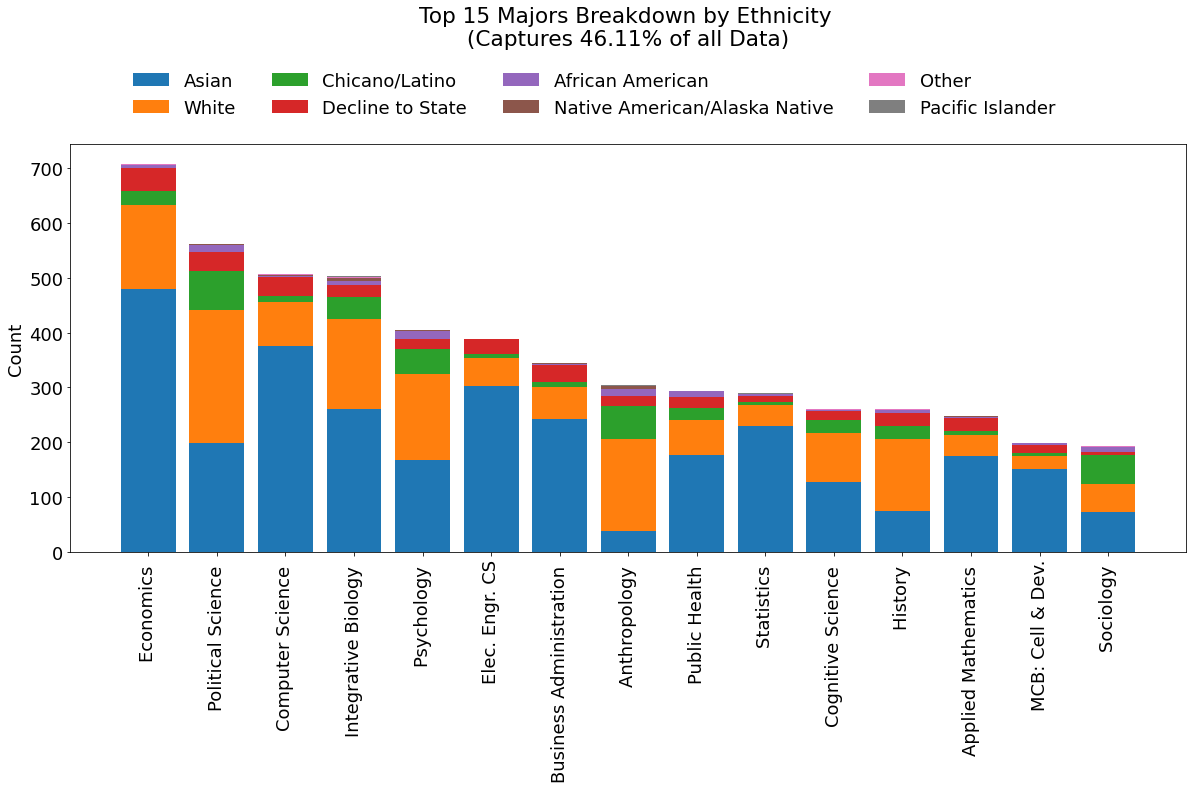

In [36]:
# plotting the top 15 degrees and getting the breakdown by ethnicity by count
top_n = 15

top_n_degrees, only_top_degrees, percent_captured, exploded_degree = get_top_n(top_n, False)

top_degrees_ethnicity = only_top_degrees.pivot_table(
    values="ID",
    index="Degree",
    columns="Ethnicity",
    aggfunc=len
).fillna(0)

top_degrees_ethnicity = top_degrees_ethnicity.loc[top_n_degrees]

majors = top_degrees_ethnicity.index
# ethnicity order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Ethnicity").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_ethnicity))
i = 0

for ethnicity in options:
    plt.bar(majors, top_degrees_ethnicity[ethnicity], bottom=prev, label=ethnicity)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_ethnicity[ethnicity])
    i += 1

plt.ylabel('Count')
plt.title("Top {n} Majors Breakdown by Ethnicity \n (Captures {percent:.2f}% of all Data) \n\n\n\n".format(n=top_n, percent=percent_captured))
plt.xticks(rotation = 90)

plt.legend(loc='lower left', bbox_to_anchor= (0.05, 1.05), ncol=4,
            borderaxespad=0, frameon=False)

plt.show()

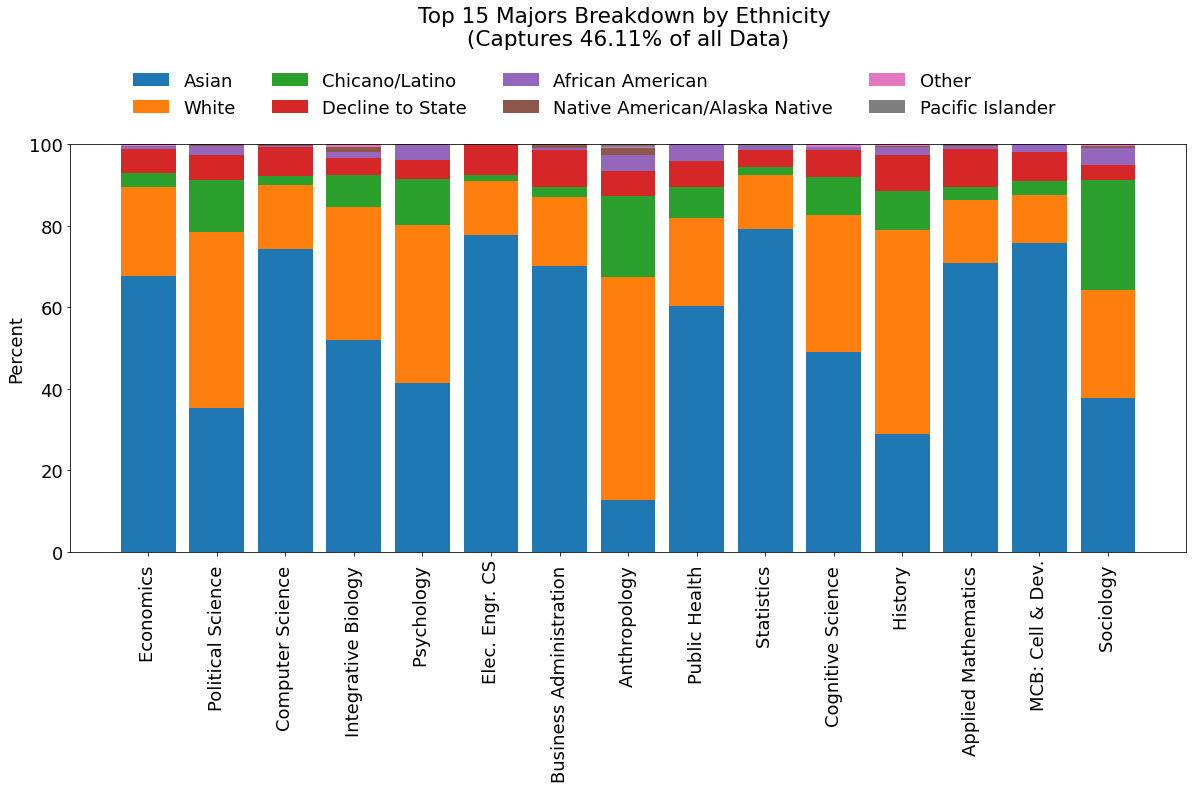

In [37]:
# plotting the top 15 degrees and getting the breakdown by ethnicity by percentages
top_degrees_ethnicity = normalize(top_degrees_ethnicity, percent=True, axis=1)

majors = top_degrees_ethnicity.index
# ethnicity order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Ethnicity").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_ethnicity))
i = 0

for ethnicity in options:
    plt.bar(majors, top_degrees_ethnicity[ethnicity], bottom=prev, label=ethnicity)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_ethnicity[ethnicity])
    i += 1

plt.ylabel('Percent')
plt.title("Top {n} Majors Breakdown by Ethnicity \n (Captures {percent:.2f}% of all Data) \n\n\n\n".format(n=top_n, percent=percent_captured))
plt.legend()
plt.xticks(rotation = 90)

plt.legend(loc='lower left', bbox_to_anchor= (0.05, 1.05), ncol=4,
            borderaxespad=0, frameon=False)

plt.show()

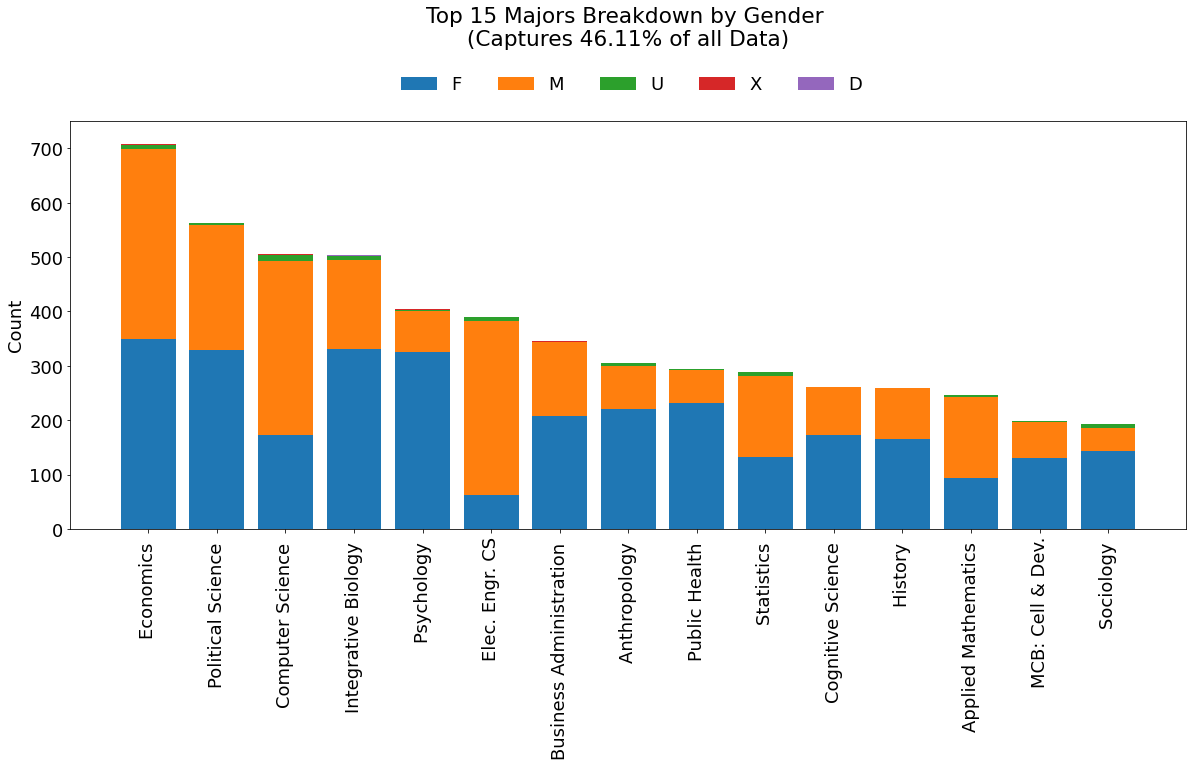

In [38]:
# plotting the top 15 degrees and getting the breakdown by gender by count

top_degrees_gender = only_top_degrees.pivot_table(
    values="ID",
    index="Degree",
    columns="Gender",
    aggfunc=len
).fillna(0)

top_degrees_gender = top_degrees_gender.loc[top_n_degrees]

majors = top_degrees_gender.index
# gender order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_gender))
i = 0

for gender in options:
    plt.bar(majors, top_degrees_gender[gender], bottom=prev, label=gender)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_gender[gender])
    i += 1

plt.ylabel('Count')
plt.title("Top {n} Majors Breakdown by Gender \n (Captures {percent:.2f}% of all Data) \n\n\n".format(n=top_n, percent=percent_captured))
plt.legend()
plt.xticks(rotation = 90)
plt.ylim([0, 750])

plt.legend(loc='lower left', bbox_to_anchor= (0.29, 1.05), ncol=5,
            borderaxespad=0, frameon=False)

plt.show()

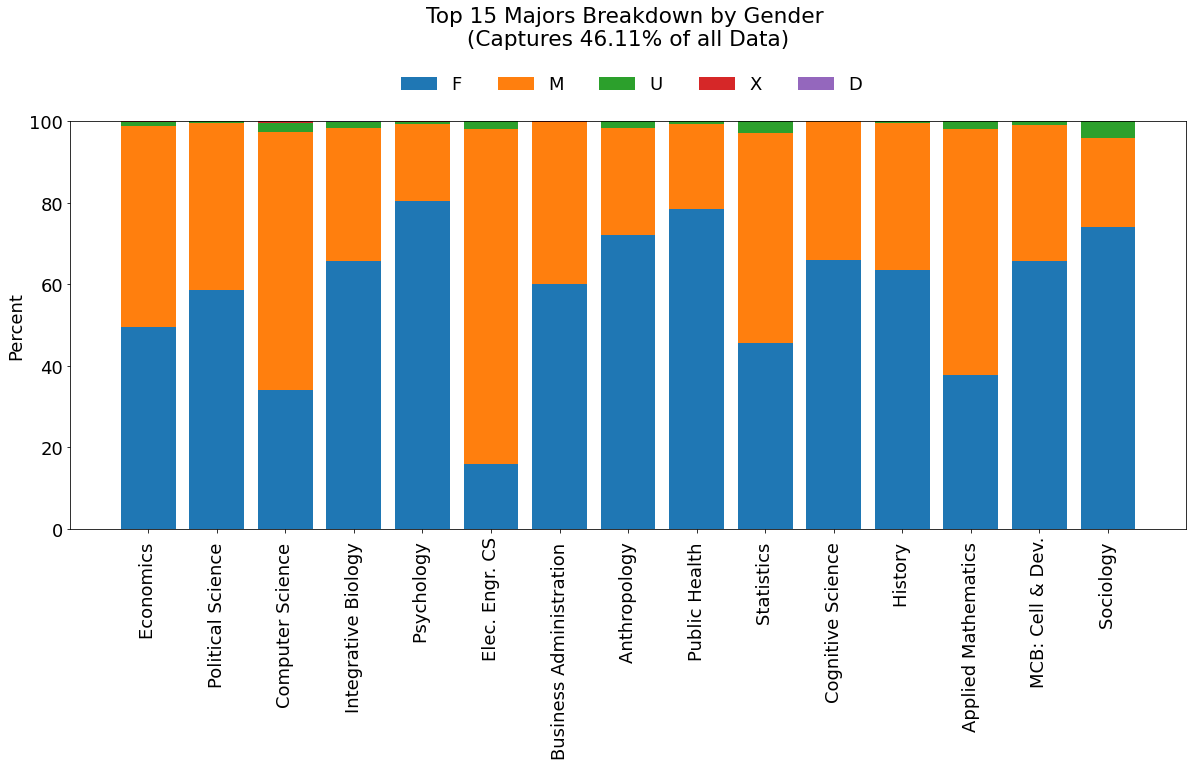

In [39]:
# plotting the top 15 degrees and getting the breakdown by gender by gender
top_degrees_gender = normalize(top_degrees_gender, percent=True, axis=1)

majors = top_degrees_gender.index
# gender order sorted by decreasing counts of top_n_degrees
options = exploded_degree.groupby("Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(top_degrees_gender))
i = 0

for gender in options:
    plt.bar(majors, top_degrees_gender[gender], bottom=prev, label=gender)#, color=colormap(len(options))[i])
    prev += np.array(top_degrees_gender[gender])
    i += 1

plt.ylabel('Percent')
plt.title("Top {n} Majors Breakdown by Gender \n (Captures {percent:.2f}% of all Data) \n\n\n".format(n=top_n, percent=percent_captured))
plt.legend()
plt.xticks(rotation = 90)
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.29, 1.05), ncol=5,
            borderaxespad=0, frameon=False)

plt.show()

In [40]:
exploded_degree.pivot_table(
    values="Class Year",
    index="Degree",
    columns=["Ethnicity", "Gender"],
    aggfunc=len
).fillna("")

Ethnicity                         African American         Asian         \
Gender                                           F    M U      D      F   
Degree                                                                    
African American Plan A: SocSci                2.0                        
African American Studies                       7.0  1.0                   
American Studies                               3.0                  7.0   
Anc Egypt & Near East Art/Arch                                            
Anthropology                                  10.0  2.0            28.0   
...                                            ...  ... ..   ...    ...   
Statistics                                     2.0  1.0           113.0   
Sustainable Environmental Design                                    3.0   
Theater & Performance Studies                                       3.0   
Urban Studies                                                       6.0   
Women's Studies                                                     1.0   

Ethnicity                                        Chicano/Latino             \
Gender                                 M    U X               F     M    U   
Degree                                                                       
African American Plan A: SocSci                                              
African American Studies                                                     
American Studies                                            5.0   1.0        
Anc Egypt & Near East Art/Arch                                               
Anthropology                        10.0  1.0              45.0  13.0  2.0   
...                                  ...  ... ..            ...   ...  ...   
Statistics                         109.0  7.0                     5.0  1.0   
Sustainable Environmental Design     1.0                                     
Theater & Performance Studies                                                
Urban Studies                        2.0                    1.0   2.0        
Women's Studies                                                              

Ethnicity                         Decline to State            \
Gender                                           F    M    U   
Degree                                                         
African American Plan A: SocSci                                
African American Studies                                       
American Studies                               2.0             
Anc Egypt & Near East Art/Arch                                 
Anthropology                                  11.0  7.0  1.0   
...                                            ...  ...  ...   
Statistics                                     6.0  6.0        
Sustainable Environmental Design                               
Theater & Performance Studies                                  
Urban Studies                                  2.0  1.0        
Women's Studies                                                

Ethnicity                         Native American/Alaska Native         Other  \
Gender                                                        F    M U      F   
Degree                                                                          
African American Plan A: SocSci                                                 
African American Studies                                                        
American Studies                                            1.0           1.0   
Anc Egypt & Near East Art/Arch                                                  
Anthropology                                                4.0  1.0            
...                                                         ...  ... ..   ...   
Statistics                                                                      
Sustainable Environmental Design                                                
Theater & Performance Studies                                       

Top 10 Degrees capture 36.32604843473125% of the data.


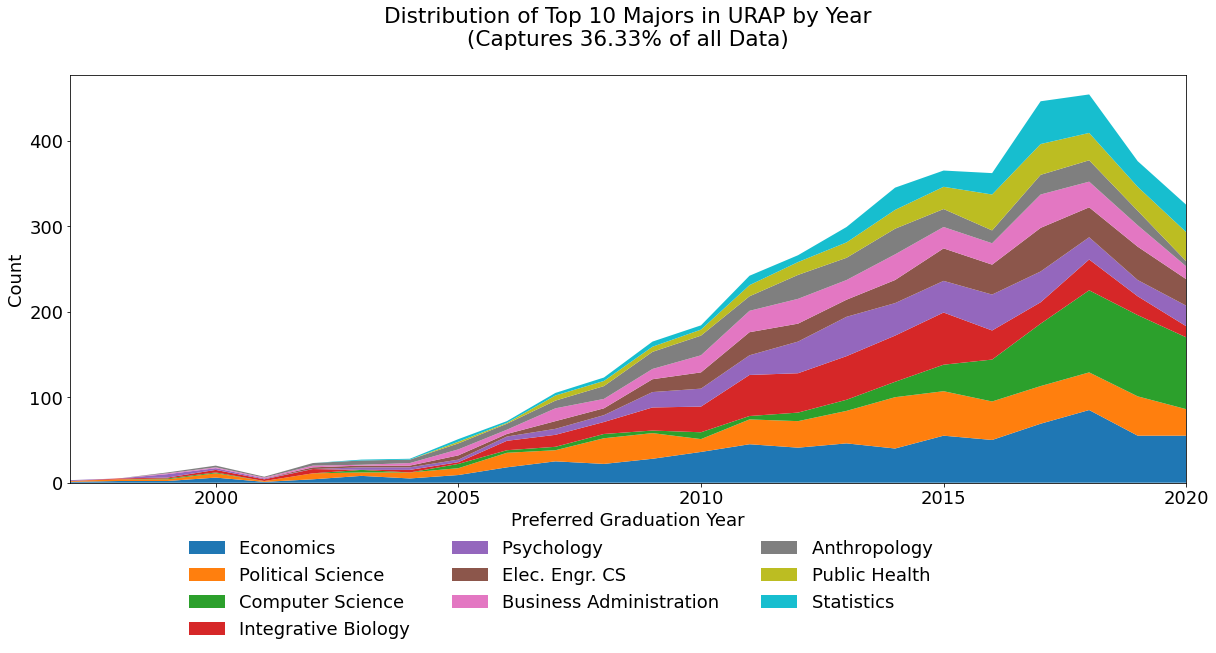

In [41]:
# plotting the count of the top 10 degrees in the URAP program over the years
top_n = 10

top_n_degrees, only_top_degrees, percent_captured, _ = get_top_n(top_n, False)

df = only_top_degrees

df_by_year = df.pivot_table(
    values="ID",
    index="Degree",
    columns="Class Year",
    aggfunc=len
).fillna(0)

sorted_by_desc = df.groupby("Degree").count().sort_values("ID", ascending=False).index
df_by_year = df_by_year.loc[sorted_by_desc]

plt.stackplot(list(df_by_year.columns), np.array(df_by_year),
              labels=sorted_by_desc,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of Top {n} Majors in URAP by Year\n (Captures {percent:.2f}% of all Data) \n".format(n=top_n, percent=percent_captured))


plt.xlim([min(gender_by_year.columns), max(gender_by_year.columns)])

plt.legend(loc='lower left', bbox_to_anchor= (0.1, -0.4), ncol=3,
            borderaxespad=0, frameon=False)

Top 10 Degrees capture 36.32604843473125% of the data.


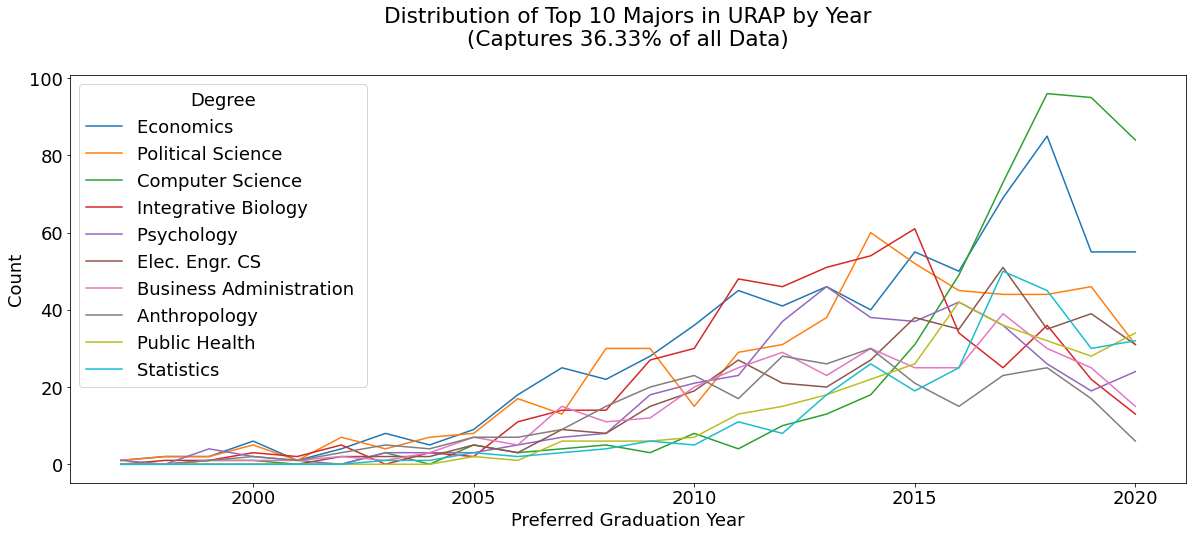

In [42]:
#New Visualization
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Count")
plt.title("Distribution of Top {n} Majors in URAP by Year\n (Captures {percent:.2f}% of all Data) \n".format(n=top_n, percent=percent_captured))

##previous code for getting top 10 degrees
top_n = 10
top_n_degrees, only_top_degrees, percent_captured, _ = get_top_n(top_n, False)

df = only_top_degrees

df_by_year = df.pivot_table(
    values="ID",
    index="Degree",
    columns="Class Year",
    aggfunc=len
).fillna(0)

sorted_by_desc = df.groupby("Degree").count().sort_values("ID", ascending=False).index
df_by_year = df_by_year.loc[sorted_by_desc]


##
sns.lineplot(data = df_by_year.transpose(), dashes = False);



Top 10 Degrees capture 36.32604843473125% of the data.


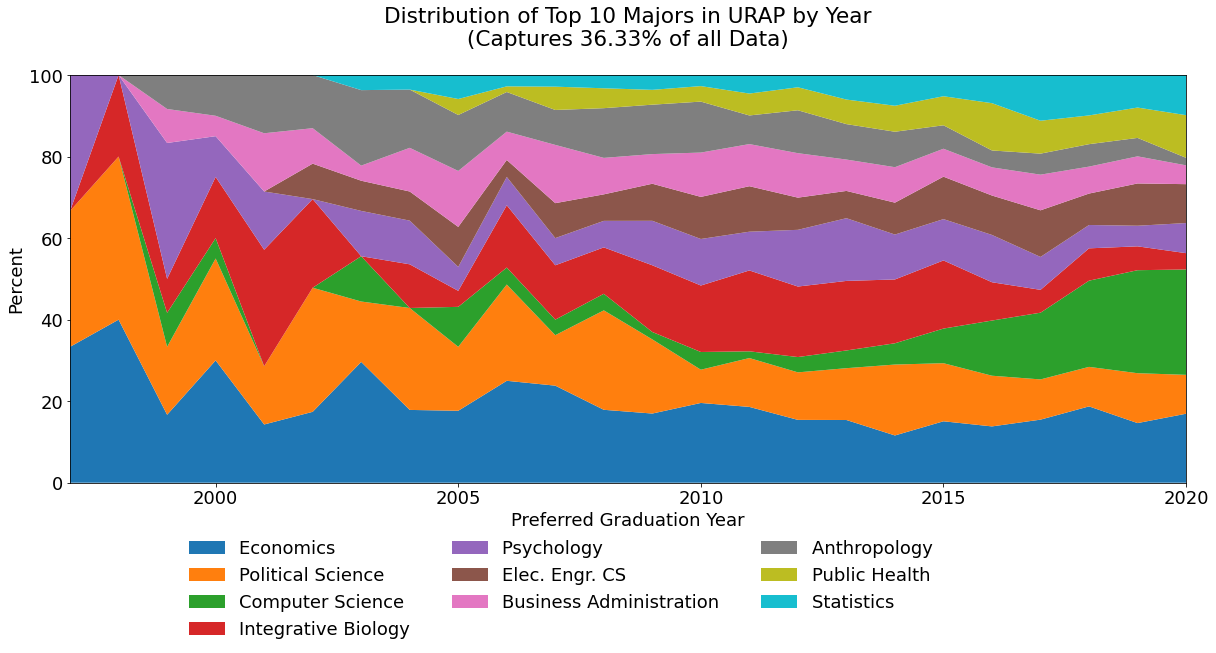

In [43]:
# plotting the percentages of the top 10 degrees in the URAP program over the years
top_n = 10
top_n_degrees, only_top_degrees, percent_captured, _ = get_top_n(top_n, False)


df_by_year = normalize(df_by_year, True)

plt.stackplot(list(df_by_year.columns), np.array(df_by_year),
              labels=sorted_by_desc,
              colors=colormap(3)
             )

plt.legend(loc='upper left')
plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of Top {n} Majors in URAP by Year\n (Captures {percent:.2f}% of all Data) \n".format(n=top_n, percent=percent_captured))

plt.xlim([min(eg.columns), max(eg.columns)])
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.1, -0.4), ncol=3,
            borderaxespad=0, frameon=False);

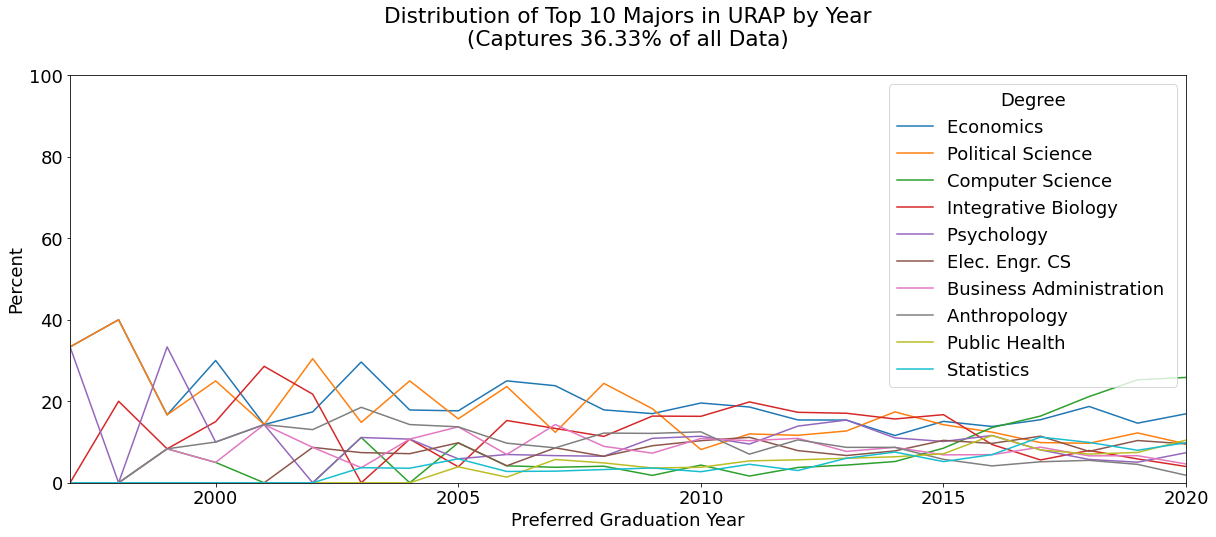

In [44]:
#New Visualization

df_by_year = normalize(df_by_year, True)


plt.xlabel("Preferred Graduation Year")
plt.ylabel("Percent")
plt.title("Distribution of Top {n} Majors in URAP by Year\n (Captures {percent:.2f}% of all Data) \n".format(n=10, percent=percent_captured))

plt.xlim([min(eg.columns), max(eg.columns)])
plt.ylim([0, 100])

sns.lineplot(data = df_by_year.transpose(), dashes = False);

## Persistence Analysis

### Calculating Percentages of Persistence
For the 4 combinations resulting from `Is STEM Degree` (1/0) and `STEM Job Within 5 Years` (1/0), find gender, race, and year breakdown
* For `STEM Job Within 5 Years`, if they didn't get a job, leave it as a NaN. For now, we will consider NaN as a False though drop the people who didn't get a job
    * May want to drop the NaN values though

In [45]:
def groupby_metrics(df):
    temp = df.groupby(["Ethnicity", "Gender"]).count()#.agg(sum)#.sort_values("Is STEM Degree", ascending=False)
#     temp["% Persist"] = (temp["STEM Job Within 5 Years"]/temp["Is STEM Degree"]) * 100
    return temp["ID"]

In [46]:
# STEM Ugrad AND STEM 5 years
ugrad_1_job_1 = consolidated[(consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] == 1)]

# STEM Ugrad AND NO STEM 5 years
ugrad_1_job_0 = consolidated[(consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] != 1)]

# NO STEM Ugrad AND STEM 5 years
ugrad_0_job_1 = consolidated[(consolidated["Is STEM Degree"] != 1) & (consolidated["STEM Job Within 5 Years"] == 1)]

# NO STEM Ugrad AND NO STEM 5 years
ugrad_0_job_0 = consolidated[(consolidated["Is STEM Degree"] != 1) & (consolidated["STEM Job Within 5 Years"] != 1)]

In [47]:
# combining the previous 4 tables
a = pd.DataFrame(groupby_metrics(ugrad_1_job_1))
b = pd.DataFrame(groupby_metrics(ugrad_1_job_0))
c = pd.DataFrame(groupby_metrics(ugrad_0_job_1))
d = pd.DataFrame(groupby_metrics(ugrad_0_job_0))
combinations = pd.concat([a, b, c, d], axis = 1, keys = ["STEM Ugrad STEM Job", "STEM Ugrad NonSTEM Job", 
                                                         "NonSTEM Ugrad STEM Job", "NonSTEM Ugrad NonSTEM Job"]).fillna("")
combinations

STEM Ugrad STEM Job  \
                                                      ID   
Ethnicity                     Gender                       
African American              F                     29.0   
                              M                     15.0   
                              U                      1.0   
Asian                         D                            
                              F                    892.0   
                              M                    804.0   
                              U                     16.0   
                              X                      1.0   
Chicano/Latino                F                     89.0   
                              M                     67.0   
                              U                      2.0   
Decline to State              F                     90.0   
                              M                     82.0   
                              U                      2.0   
Native American/Alaska Native F                      7.0   
                              M                     11.0   
                              U                            
Other                         F                      4.0   
                              M                      4.0   
Pacific Islander              F                      2.0   
                              M                      2.0   
White                         F                    401.0   
                              M                    362.0   
                              U                      5.0   
                              X                            

                                     STEM Ugrad NonSTEM Job  \
                                                         ID   
Ethnicity                     Gender                          
African American              F                        22.0   
                              M                        13.0   
                              U                               
Asian                         D                         1.0   
                              F                       709.0   
                              M                       541.0   
                              U                        16.0   
                              X                         1.0   
Chicano/Latino                F                        93.0   
                              M                        55.0   
                              U                         5.0   
Decline to State              F                        71.0   
                              M                        61.0   
                              U                         3.0   
Native American/Alaska Native F                         3.0   
                              M                         3.0   
                              U                               
Other                         F                         2.0   
                              M                               
Pacific Islander              F                         2.0   
                              M                         2.0   
White                         F                       385.0   
                              M                       240.0   
                              U                         7.0   
                              X                         2.0   

                                     NonSTEM Ugrad STEM Job  \
                                                         ID   
Ethnicity                     Gender                          
African American              F                        20.0   
                              M                         3.0   
                              U                               
Asian                         D                               
                              F                       251.0   
                              M                        90.0   
                        

In [48]:
# looking for % persisting based on ugrad STEM Degree
df = consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Ethnicity", "Gender"]).agg(sum)#.sort_values("Is STEM Degree", ascending=False)
df["% Persist"] = (df["STEM Job Within 5 Years"]/df["Is STEM Degree"]) * 100
# df.sort_values("STEM Job Within 5 Years", ascending=False)
df

Class Year          ID  Is STEM Degree  \
Ethnicity                     Gender                                           
African American              F           102759   118239968            51.0   
                              M            56404    67569192            28.0   
                              U             2017     3216595             1.0   
Asian                         D             2020     3469873             1.0   
                              F          3225036  3512050292          1601.0   
                              M          2709064  2861508529          1345.0   
                              U            64530    91826891            32.0   
                              X             4033     6220614             2.0   
Chicano/Latino                F           366793   442650950           182.0   
                              M           245756   266123552           122.0   
                              U            14111    19351527             7.0   
Decline to State              F           324166   309905261           161.0   
                              M           287902   266993981           143.0   
                              U            10082    13541255             5.0   
Native American/Alaska Native F            20158    24695796            10.0   
                              M            28189    30094547            14.0   
Other                         F            12025     4577385             6.0   
                              M             8026     3266835             4.0   
Pacific Islander              F             8049     5938278             4.0   
                              M             8060     8569546             4.0   
White                         F          1583125  1656018439           786.0   
                              M          1211885  1155180381           602.0   
                              U            24194    31539202            12.0   
                              X             4040     6240719             2.0   

                                      STEM Job Within 5 Years   % Persist  
Ethnicity                     Gender                                       
African American              F                          29.0   56.862745  
                              M                          15.0   53.571429  
                              U                           1.0  100.000000  
Asian                         D                           0.0    0.000000  
                              F                         892.0   55.715178  
                              M                         804.0   59.776952  
                              U                          16.0   50.000000  
                              X                           1.0   50.000000  
Chicano/Latino                F                          89.0   48.901099  
                              M                          67.0   54.918033  
                              U                           2.0   28.571429  
Decline to State              F                          90.0   55.900621  
                              M                          82.0   57.342657  
                              U                           2.0   40.000000  
Native American/Alaska Native F                           7.0   70.000000  
                              M                          11.0   78.571429  
Other                         F                           4.0   66.666667  
                              M                           4.0  100.000000  
Pacific Islander              F                           2.0   50.000000  
                              M                           2.0   50.000000  
White                         F                         401.0   51.017812  
                              M                         362.0   60.132890  
                              U                           5.0   41.666667  
                              X                          

In [49]:
df = consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Ethnicity", "Gender"]).agg(sum).sort_values("Is STEM Degree", ascending=False)
df["% Persist"] = (df["STEM Job Within 5 Years"]/df["Is STEM Degree"]) * 100
df

Class Year          ID  Is STEM Degree  \
Ethnicity                     Gender                                           
Asian                         F          3225036  3512050292          1601.0   
                              M          2709064  2861508529          1345.0   
White                         F          1583125  1656018439           786.0   
                              M          1211885  1155180381           602.0   
Chicano/Latino                F           366793   442650950           182.0   
Decline to State              F           324166   309905261           161.0   
                              M           287902   266993981           143.0   
Chicano/Latino                M           245756   266123552           122.0   
African American              F           102759   118239968            51.0   
Asian                         U            64530    91826891            32.0   
African American              M            56404    67569192            28.0   
Native American/Alaska Native M            28189    30094547            14.0   
White                         U            24194    31539202            12.0   
Native American/Alaska Native F            20158    24695796            10.0   
Chicano/Latino                U            14111    19351527             7.0   
Other                         F            12025     4577385             6.0   
Decline to State              U            10082    13541255             5.0   
Other                         M             8026     3266835             4.0   
Pacific Islander              F             8049     5938278             4.0   
                              M             8060     8569546             4.0   
Asian                         X             4033     6220614             2.0   
White                         X             4040     6240719             2.0   
Asian                         D             2020     3469873             1.0   
African American              U             2017     3216595             1.0   

                                      STEM Job Within 5 Years   % Persist  
Ethnicity                     Gender                                       
Asian                         F                         892.0   55.715178  
                              M                         804.0   59.776952  
White                         F                         401.0   51.017812  
                              M                         362.0   60.132890  
Chicano/Latino                F                          89.0   48.901099  
Decline to State              F                          90.0   55.900621  
                              M                          82.0   57.342657  
Chicano/Latino                M                          67.0   54.918033  
African American              F                          29.0   56.862745  
Asian                         U                          16.0   50.000000  
African American              M                          15.0   53.571429  
Native American/Alaska Native M                          11.0   78.571429  
White                         U                           5.0   41.666667  
Native American/Alaska Native F                           7.0   70.000000  
Chicano/Latino                U                           2.0   28.571429  
Other                         F                           4.0   66.666667  
Decline to State              U                           2.0   40.000000  
Other                         M                           4.0  100.000000  
Pacific Islander              F                           2.0   50.000000  
                              M                           2.0   50.000000  
Asian                         X                           1.0   50.000000  
White                         X                           0.0    0.000000  
Asian                         D                           0.0    0.000000  
African American              U                          

In [50]:
consolidated.groupby("Class Year").count().sort_values("ID", ascending=False)

Degrees  Ethnicity  Gender   ID  Is STEM Degree  \
Class Year                                                    
2017            744        744     744  744             744   
2018            703        703     703  703             703   
2019            661        661     661  661             661   
2015            647        647     647  647             647   
2014            622        622     622  622             622   
2016            619        619     619  619             619   
2020            552        552     552  552             552   
2013            552        552     552  552             552   
2012            508        508     508  508             508   
2011            449        449     449  449             449   
2010            389        389     389  389             389   
2009            331        331     331  331             331   
2008            230        230     230  230             230   
2007            208        208     208  208             208   
2006            158        158     158  158             158   
2005            101        101     101  101             101   
2003             74         74      74   74              74   
2004             64         64      64   64              64   
2002             51         51      51   51              51   
2000             46         46      46   46              46   
1999             29         29      29   29              29   
1998             21         21      21   21              21   
2001             20         20      20   20              20   
1997              5          5       5    5               5   

            STEM Job Within 5 Years  Simple Gender  Ethnicity and Gender  
Class Year                                                                
2017                            647            744                   744  
2018                            570            703                   703  
2019                            451            661                   661  
2015                            569            647                   647  
2014                            544            622                   622  
2016                            522            619                   619  
2020                            258            552                   552  
2013                            488            552                   552  
2012                            444            508                   508  
2011                            390            449                   449  
2010                            336            389                   389  
2009                            272            331                   331  
2008                            190            230                   230  
2007                            173            208                   208  
2006                            132            158                   158  
2005                             80            101                   101  
2003                             55             74                    74  
2004                             50             64                    64  
2002                             35             51                    51  
2000                             30             46                    46  
1999                             20             29                    29  
1998                             10             21                    21  
2001                             10             20                    20  
1997                              4              5                     5

### Visualizing Persistence Data

In [51]:
donut_gender =consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Gender", "STEM Job Within 5 Years"]).count().sort_values("Gender").reset_index()

#manually added from donut_gender:
#nested persistence: [[Female No Persist, Female Persist], [Male No Persist, Male Persist], etc.]
nested_gen = np.array([[700, 1514], [482, 1347], [23, 27]])

#Persistence: [Female, Male]
persist_gen = [1514, 1347]
nopersist_gen = [700, 482]

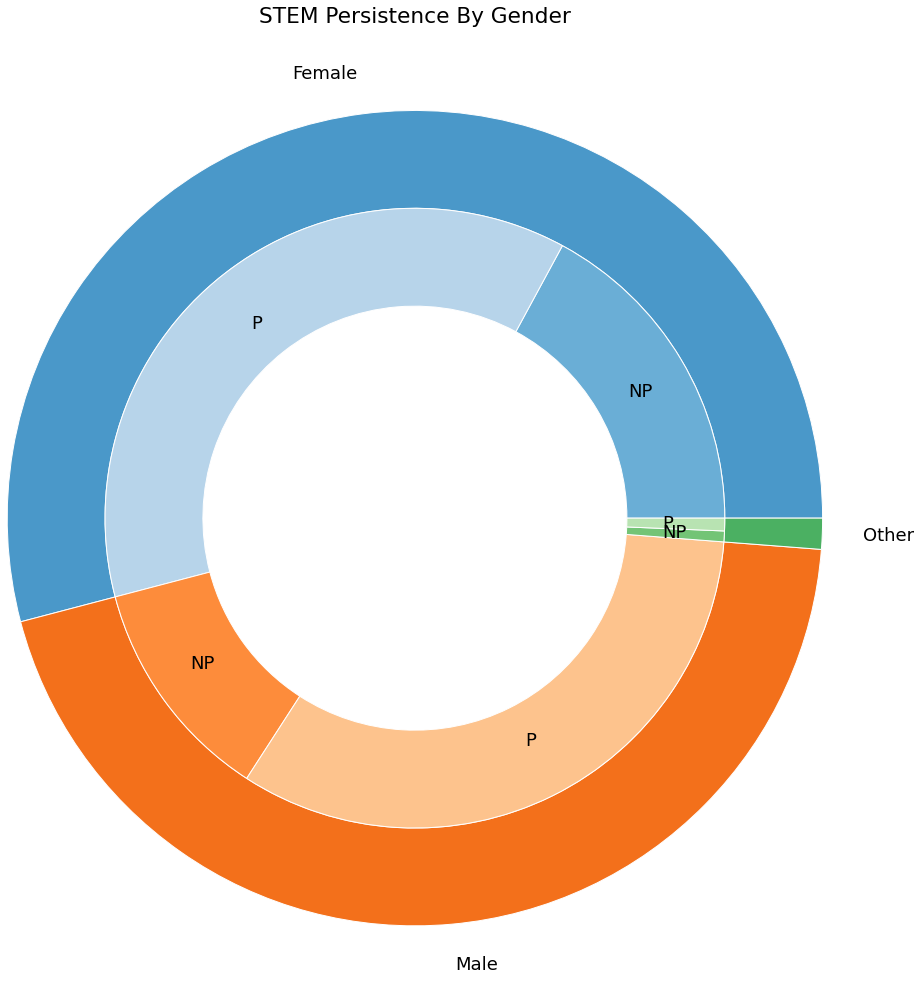

In [52]:
fig, ax = plt.subplots()

size = .6

#labels
group_names=["Female", "Male", "Other"]
subgroup_names = ["NP", "P",
                 "NP", "P",
                 "NP", "P"]
#colors
cmap = plt.get_cmap("tab20c")
b, g, r, o, p, grey=[plt.cm.Blues, plt.cm.Greens,plt.cm.Reds,  plt.cm.Oranges,
        plt.cm.Purples, plt.cm.Greys]
outer_colors = [b(0.6), #female
                o(0.6), #male
                g(0.6)] #U and X
inner_colors = [b(0.5), b(0.3), 
                           o(0.5), o(0.3), 
                           g(0.5), g(0.3)]

#graph nested pie
ax.pie(nested_gen.sum(axis=1), labels = group_names, radius=2.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(nested_gen.flatten(), labels = subgroup_names, radius=2.5-size,labeldistance=.8, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
ax.set_title("STEM Persistence By Gender", y=1.7)
plt.show()

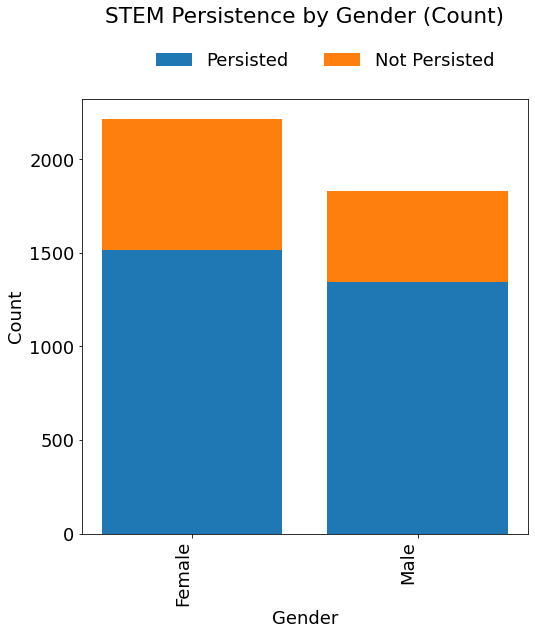

In [53]:
gen = ["Female", "Male"]
ind = [x for x, _ in enumerate(gen)]

#set figure size and plot stacked bar chart
plt.figure(figsize=(8, 8))
plt.bar(ind, persist_gen, label='Persisted')
plt.bar(ind, nopersist_gen, label='Not Persisted', bottom=persist_gen)

#labels
plt.xticks(ind, gen)
plt.ylabel("Count")
plt.xlabel("Gender")
plt.legend(loc='lower left', bbox_to_anchor= (0.15, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Gender (Count)\n\n\n")
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

# Current Analysis
Here is the current analysis we are doing to see whether there are certain trends in persistence in STEM.

We will look at 
* Gender Differences
* Degrees Across Genders
* Any changces in URAP Participants over the years?


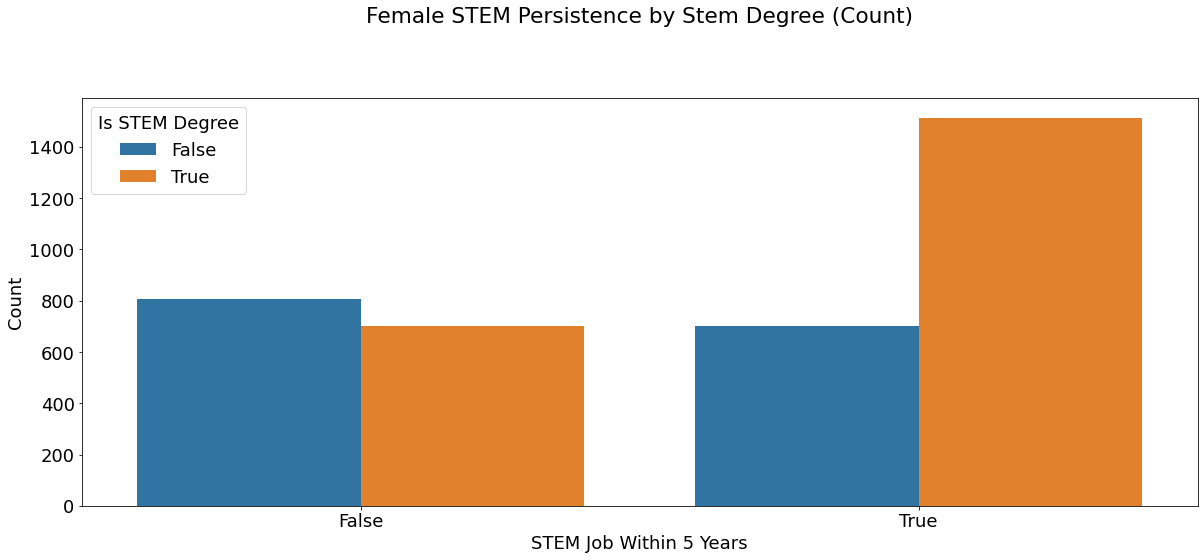

In [54]:
## This is just some code I added to see how gender plays in a STEM degree and non-STEM degree 
#as well as how it correlates with persistence
#This code looks at female persistence

plt.title("Female STEM Persistence by Stem Degree (Count)\n\n\n")
plt.ylabel("Count")
plt.xlabel("Gender")


female_stem = consolidated[(consolidated["Gender"] == "F")].groupby(["Is STEM Degree", "STEM Job Within 5 Years"]).count().reset_index()
female_stem["Count"] = female_stem["ID"]
female_stem = female_stem[["Is STEM Degree", "STEM Job Within 5 Years", "Count"]]
female_stem

boolean_dict = {0: False, 1: True}
female_stem.replace(boolean_dict, inplace=True)

ax1 = sns.barplot(x="STEM Job Within 5 Years", y = "Count", hue = "Is STEM Degree", data=female_stem);


In [55]:
def percent(num1, num2):
    return abs(num1 - num2) / (num1 + num2) * 100

count_female = female_stem["Count"]
persist_female = percent(count_female[2], count_female[3]).round(2)
diff_reg_female = percent(count_female[0], count_female[1]).round(2)

print("It seems that a STEM major female is likely to have a {}% higher chance to persist in STEM than a non-STEM major".format(persist_female))




It seems that a STEM major female is likely to have a 36.77% higher chance to persist in STEM than a non-STEM major


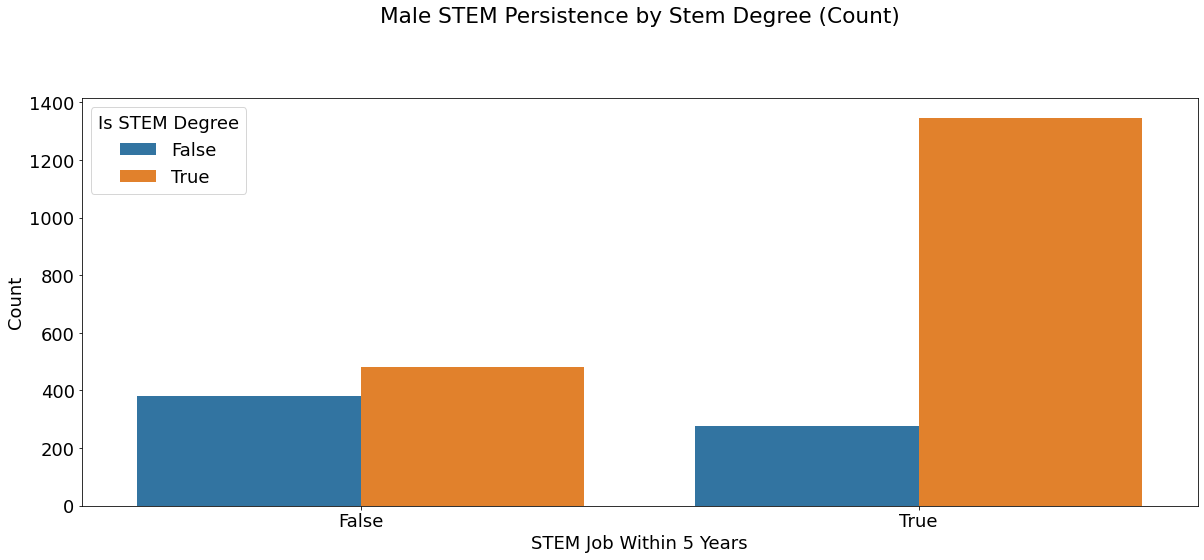

In [56]:
## This is just some code I added to see how gender plays in a STEM degree and non-STEM degree 
#as well as how it correlates with persistence
#This code looks at male persistence

plt.title("Male STEM Persistence by Stem Degree (Count)\n\n\n")
plt.ylabel("Count")
plt.xlabel("Gender")

male_stem = consolidated[(consolidated["Gender"] == "M")].groupby(["Is STEM Degree", "STEM Job Within 5 Years"]).count().reset_index()
male_stem["Count"] = male_stem["ID"]
male_stem = male_stem[["Is STEM Degree", "STEM Job Within 5 Years", "Count"]]
male_stem

boolean_dict = {0: False, 1: True}
male_stem.replace(boolean_dict, inplace=True)

ax2 = sns.barplot(x="STEM Job Within 5 Years", y = "Count", hue = "Is STEM Degree", data=male_stem);



In [57]:
count_male = male_stem["Count"]
persist_male = percent(count_male[2], count_male[3]).round(2)
diff_reg_male = percent(count_male[0], count_male[1]).round(2)
male_stem
print("It seems that STEM major male is likely to have a {}% higher chance to persist in STEM than a non-STEM major".format(persist_male))



It seems that STEM major male is likely to have a 47.29% higher chance to persist in STEM than a non-STEM major


It seems that female STEM majors have a higher chance of persisting in STEM than a female non-STEM major. Why is this? Is this related to the number of female samples we have vs number of male samples? Are non-STEM females discouraged from pursuing degrees in STEM? There can be many reasons for this disparity.

Let's look at the percentage of non-STEM females to non-STEM males we have:

In [58]:
print("A STEM major male is likely to have a {}% higher chance to persist in STEM than a non-STEM major male".format(persist_male))
print("A STEM major female is likely to have a {}% higher chance to persist in STEM than a non-STEM major female".format(persist_female))


A STEM major male is likely to have a 47.29% higher chance to persist in STEM than a non-STEM major male
A STEM major female is likely to have a 36.77% higher chance to persist in STEM than a non-STEM major female


In [59]:
both_stem = female_stem.join(male_stem, on = "Is STEM Degree", how='left', lsuffix='_female', rsuffix='_male')
num_female = sum(both_stem["Count_female"])
num_male = sum(both_stem["Count_male"])

print("We have {} females in the dataset and {} males in the dataset, so we have more females than males.".format(num_female, num_male))

We have 3723 females in the dataset and 1318 males in the dataset, so we have more females than males.


In [60]:
#Lets get just the degrees without the year for grouping
consolidated["Degrees Name"] = consolidated["Degrees"].str.extract("([^0-9\n]+)")
consolidated

/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/4209633457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consolidated["Degrees Name"] = consolidated["Degrees"].str.extract("([^0-9\n]+)")


Class Year                                            Degrees  \
0           2001                  B.S. Business Administration 2001   
1           2005  B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...   
2           2005                           B.S. Bioengineering 2005   
3           2004           B.S. Nuclear Engineering: Undergrad 2004   
4           2007    B.A. Classical Languages 2007; M.A. Design 2012   
...          ...                                                ...   
7783        2020                           B.A. Global Studies 2020   
7784        2020                         B.A. Computer Science 2020   
7785        2020                        B.S. Microbial Biology 2020   
7786        2020                      B.A. Integrative Biology 2020   
7787        2020                             B.A. Anthropology 2020   

             Ethnicity Gender       ID  Is STEM Degree  \
0                White      F   724202             1.0   
1                Asian      M   729526             0.0   
2                Asian      M   732926             1.0   
3                Asian      M   746450             1.0   
4     Decline to State      M   754146             0.0   
...                ...    ...      ...             ...   
7783  Decline to State      M  3468738             0.0   
7784    Chicano/Latino      M  3468968             1.0   
7785             Asian      F  3468993             1.0   
7786             Asian      D  3469873             1.0   
7787    Chicano/Latino      M  3711424             0.0   

      STEM Job Within 5 Years Simple Gender   Ethnicity and Gender  \
0                         NaN        Female           White Female   
1                         0.0          Male             Asian Male   
2                         0.0          Male             Asian Male   
3                         1.0          Male             Asian Male   
4                         NaN          Male  Decline to State Male   
...                       ...           ...                    ...   
7783                      NaN          Male  Decline to State Male   
7784                      NaN          Male    Chicano/Latino Male   
7785                      0.0        Female           Asian Female   
7786                      NaN         Other            Asian Other   
7787                      0.0          Male    Chicano/Latino Male   

                              Degrees Name  
0            B.S. Business Administration   
1                           B.A. Rhetoric   
2                     B.S. Bioengineering   
3     B.S. Nuclear Engineering: Undergrad   
4                B.A. Classical Languages   
...                                    ...  
7783                  B.A. Global Studies   
7784                B.A. Computer Science   
7785               B.S. Microbial Biology   
7786             B.A. Integrative Biology   
7787                    B.A. Anthropology   

[7784 rows x 10 columns]

In [61]:
female_degree = consolidated[(consolidated["Gender"] == "F")].groupby(["Is STEM Degree", "Degrees Name"]).count()
female_degree["Count"] = female_degree["Class Year"]
female_degree = female_degree.sort_values(by=["Count"], ascending=False)

female_degree = female_degree[["Count"]]

female_degree = female_degree.reset_index()

boolean_dict = {0: False, 1: True}
female_degree["Is STEM Degree"].replace(boolean_dict, inplace=True)

female_stem_degree = female_degree[female_degree["Is STEM Degree"] == True]
female_stem_degree
#It seems like females have a lot more Psychology and Integrative Degrees!

Is STEM Degree                          Degrees Name  Count
0              True             B.A. Integrative Biology     294
1              True                      B.A. Psychology     231
5              True                   B.A. Public Health     184
6              True               B.A. Cognitive Science     167
7              True                B.A. Computer Science     147
..              ...                                   ...    ...
186            True                 B.A. Spanish Option C      1
187            True        B.A. African American Studies       1
188            True               B.A. Human Biodynamics       1
190            True  B.A. Anc Egypt & Near East Art/Arch       1
191            True          B.A. Asian Studies I: China       1

[113 rows x 3 columns]

In [62]:
male_degree = consolidated[(consolidated["Gender"] == "M")].groupby(["Is STEM Degree", "Degrees Name"]).count()
male_degree["Count"] = male_degree["Class Year"]
male_degree = male_degree.sort_values(by=["Count"], ascending=False)

male_degree = male_degree[["Count"]]

male_degree = male_degree.reset_index()

boolean_dict = {0: False, 1: True}
male_degree["Is STEM Degree"].replace(boolean_dict, inplace=True)

male_stem_degree = male_degree[male_degree["Is STEM Degree"] == True]
male_stem_degree

Is STEM Degree                                 Degrees Name  Count
0              True                       B.A. Computer Science     275
1              True  B.S. Electrical Engr & Comp Sci: Undergrad     273
3              True                    B.A. Integrative Biology     150
4              True                    B.A. Applied Mathematics     149
6              True                              B.A. Economics      98
..              ...                                          ...    ...
147            True                         B.A. History of Art       1
148            True                          B.A. Media Studies       1
150            True                                  B.A. Music       1
151            True         B.A. Near Eastern Lang & Literature       1
152            True                             B.A. Philosophy       1

[97 rows x 3 columns]

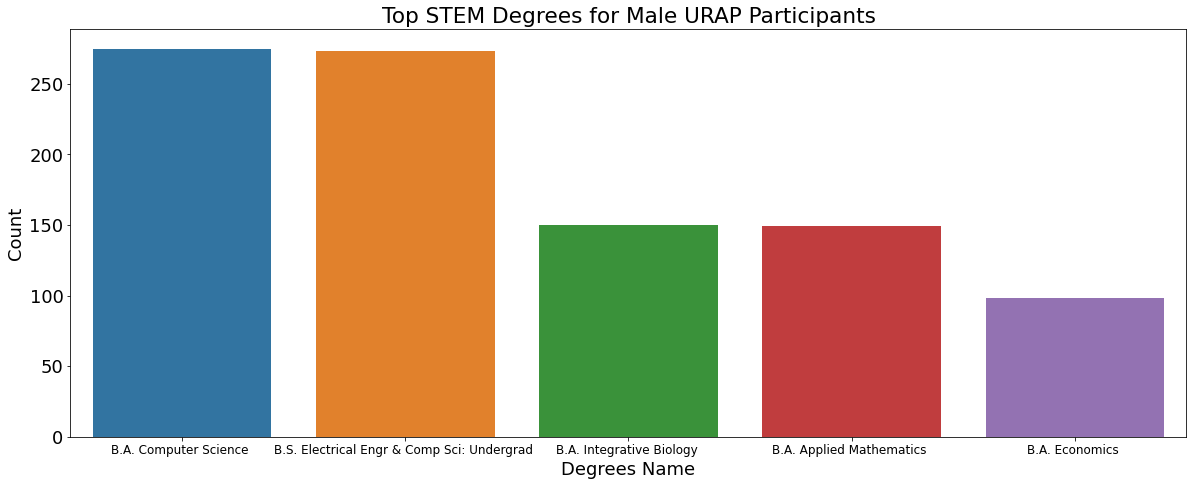

In [63]:
sns.barplot(x="Degrees Name", y = "Count", data=male_stem_degree.head(5));
plt.xticks(fontsize=12)
plt.title("Top STEM Degrees for Male URAP Participants");

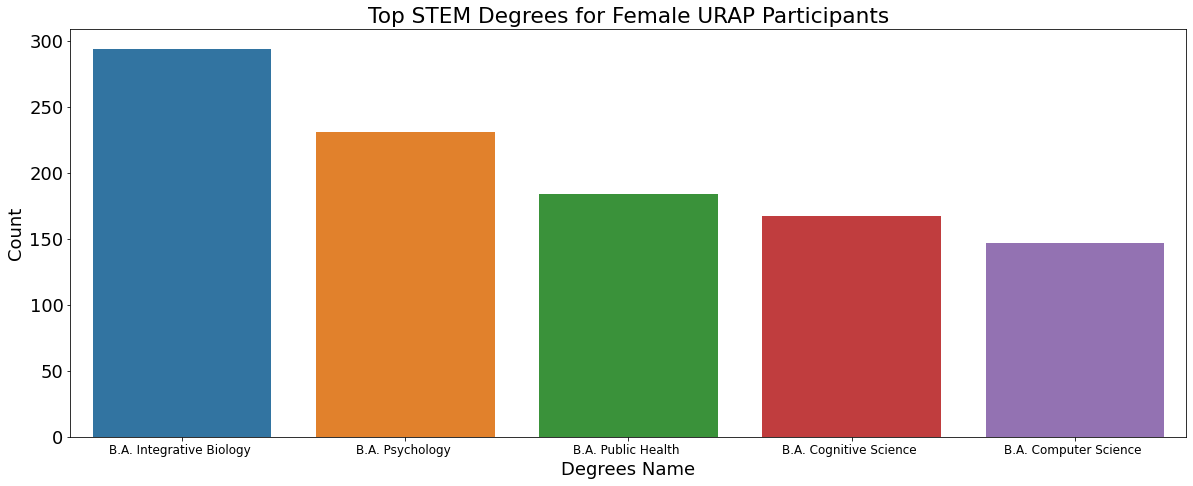

In [64]:
sns.barplot(x="Degrees Name", y = "Count", data=female_stem_degree.head(5));
plt.xticks(fontsize=12)
plt.title("Top STEM Degrees for Female URAP Participants");

It's seems that the top 5 STEM degrees by gender are (in descending order):

__Male__: Computer Science, EECS, Integrative Biology, Applied Mathematics, Economics                        
__Female__: Integrative Biology, Psychology, Public Health, Cognitive Science, Computer Science	

What about for URAP participants that persisted in STEM? What are they're top degrees?

In [65]:
#First get table of alll participants that persisted in STEM 
boolean_dict = {0: False, 1: True}
copy = consolidated.copy()
copy["STEM Job Within 5 Years"].replace(boolean_dict, inplace=True)
copy["Is STEM Degree"].replace(boolean_dict, inplace=True)
copy[copy["STEM Job Within 5 Years"] == True]

persisted_stem = copy[copy["STEM Job Within 5 Years"] == True]
persisted_stem


Class Year                                            Degrees Ethnicity  \
3           2004           B.S. Nuclear Engineering: Undergrad 2004     Asian   
7           2005                           B.S. Bioengineering 2005     Asian   
8           2003    B.S. Electrical Engr & Comp Sci: Undergrad 2003     Asian   
9           2006                                B.A. Economics 2006     Asian   
10          2003  B.A. Psychology 2003; M.A. Psychology 2005; Ph...     White   
...          ...                                                ...       ...   
7754        2020                        B.A. Political Science 2020     White   
7756        2020                               B.A. Statistics 2020     Asian   
7760        2020         B.A. Public Health 2020; ATG Public Health     White   
7773        2020                        B.A. Political Science 2020     White   
7780        2020  B.A. Molecular & Cell Bio: Cell & Development ...     Asian   

     Gender       ID  Is STEM Degree STEM Job Within 5 Years Simple Gender  \
3         M   746450            True                    True          Male   
7         M   728637            True                    True          Male   
8         M   739309            True                    True          Male   
9         F   755980           False                    True        Female   
10        F   667847            True                    True        Female   
...     ...      ...             ...                     ...           ...   
7754      F  3455330           False                    True        Female   
7756      M  3455515            True                    True          Male   
7760      F  3456743            True                    True        Female   
7773      M  3461989           False                    True          Male   
7780      F  3467836            True                    True        Female   

     Ethnicity and Gender                                    Degrees Name  
3              Asian Male            B.S. Nuclear Engineering: Undergrad   
7              Asian Male                            B.S. Bioengineering   
8              Asian Male     B.S. Electrical Engr & Comp Sci: Undergrad   
9            Asian Female                                 B.A. Economics   
10           White Female                                B.A. Psychology   
...                   ...                                             ...  
7754         White Female                         B.A. Political Science   
7756           Asian Male                                B.A. Statistics   
7760         White Female                             B.A. Public Health   
7773           White Male                         B.A. Political Science   
7780         Asian Female  B.A. Molecular & Cell Bio: Cell & Development   

[3874 rows x 10 columns]

In [66]:
female_persisted_stem = persisted_stem[persisted_stem["Gender"] == "F"].groupby(["Is STEM Degree", "Degrees Name"]).count()

female_persisted_stem["Count"] = female_persisted_stem["Class Year"]
female_persisted_stem = female_persisted_stem.sort_values(by=["Count"], ascending=False)

female_persisted_stem = female_persisted_stem[["Count"]]

female_persisted_stem = female_persisted_stem.reset_index()

boolean_dict = {0: False, 1: True}
female_persisted_stem["Is STEM Degree"].replace(boolean_dict, inplace=True)
female_persisted_stem = female_persisted_stem[female_persisted_stem["Is STEM Degree"] == True]
female_persisted_stem["Percent"] = female_persisted_stem["Count"] / sum(female_persisted_stem["Count"]) * 100
female_persisted_stem


Is STEM Degree                          Degrees Name  Count   Percent
0              True             B.A. Integrative Biology     142  9.379128
1              True                      B.A. Psychology     103  6.803170
2              True                   B.A. Public Health     100  6.605020
3              True                B.A. Computer Science      99  6.538970
5              True               B.A. Cognitive Science      99  6.538970
..              ...                                   ...    ...       ...
146            True          B.A. Asian Studies I: China       1  0.066050
147            True        B.A. South & SE Asian Studies       1  0.066050
148            True  B.A. Anc Egypt & Near East Art/Arch       1  0.066050
149            True        B.A. African American Studies       1  0.066050
150            True            ATU Environmental Sciences      1  0.066050

[92 rows x 4 columns]

In [67]:
male_persisted_stem = persisted_stem[persisted_stem["Gender"] == "M"].groupby(["Is STEM Degree", "Degrees Name"]).count()

male_persisted_stem["Count"] = male_persisted_stem["Class Year"]
male_persisted_stem = male_persisted_stem.sort_values(by=["Count"], ascending=False)

male_persisted_stem = male_persisted_stem[["Count"]]

male_persisted_stem = male_persisted_stem.reset_index()

boolean_dict = {0: False, 1: True}
male_persisted_stem["Is STEM Degree"].replace(boolean_dict, inplace=True)
male_persisted_stem = male_persisted_stem[male_persisted_stem["Is STEM Degree"] == True]
male_persisted_stem["Percent"] = male_persisted_stem["Count"] / sum(male_persisted_stem["Count"]) * 100
male_persisted_stem


Is STEM Degree                                   Degrees Name  Count  \
0              True    B.S. Electrical Engr & Comp Sci: Undergrad     193   
1              True                         B.A. Computer Science     190   
2              True                      B.A. Integrative Biology      83   
4              True        B.S. Mechanical Engineering: Undergrad      74   
5              True                      B.A. Applied Mathematics      73   
..              ...                                            ...    ...   
107            True                                B.A. Sociology       1   
108            True                           ATU Computer Science      1   
109            True                            B.A. Urban Studies       1   
110            True  ATU Chemistry; ATU Environmental Engr Science      1   
111            True                 B.S. Bioengr & Mat Sci & Engr       1   

       Percent  
0    14.328137  
1    14.105419  
2     6.161841  
4     5.493690  
5     5.419451  
..         ...  
107   0.074239  
108   0.074239  
109   0.074239  
110   0.074239  
111   0.074239  

[81 rows x 4 columns]

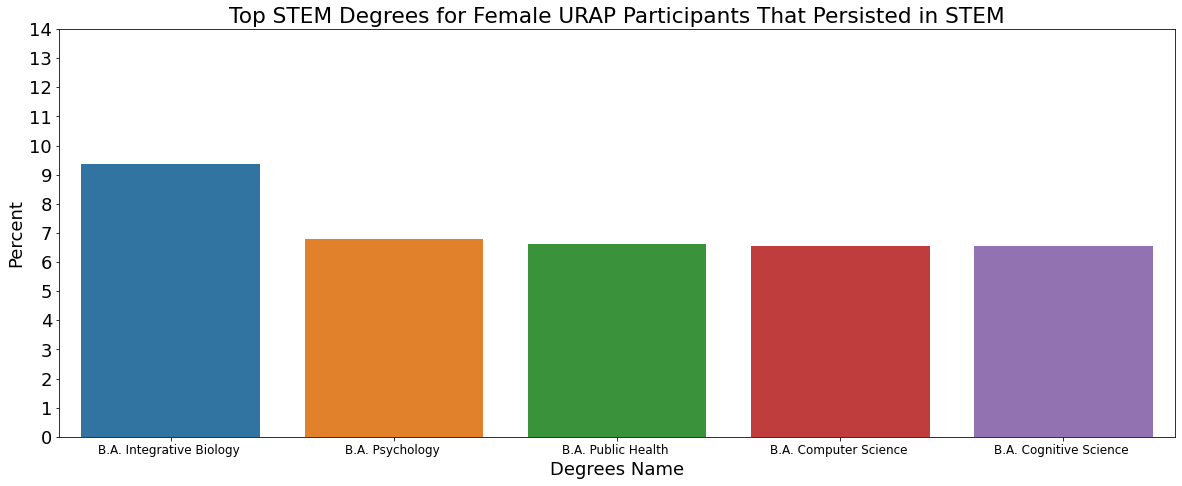

In [68]:
sns.barplot(x="Degrees Name", y = "Percent", data=female_persisted_stem.head(5));
plt.xticks(fontsize=12)
plt.yticks(np.arange(15))
plt.title("Top STEM Degrees for Female URAP Participants That Persisted in STEM");

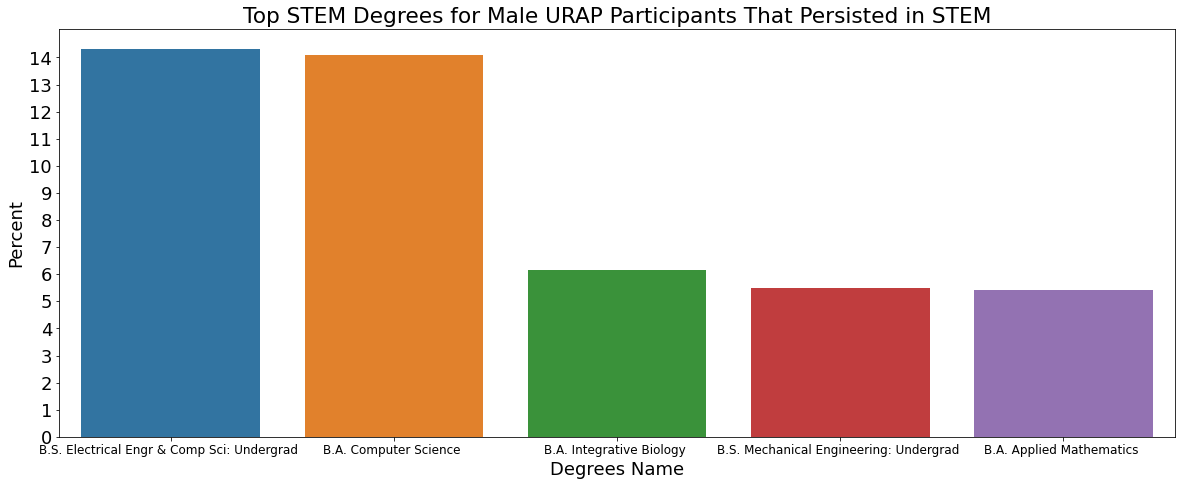

In [69]:
sns.barplot(x="Degrees Name", y = "Percent", data=male_persisted_stem.head(5));
plt.xticks(fontsize=12)
plt.yticks(np.arange(15))
plt.title("Top STEM Degrees for Male URAP Participants That Persisted in STEM");

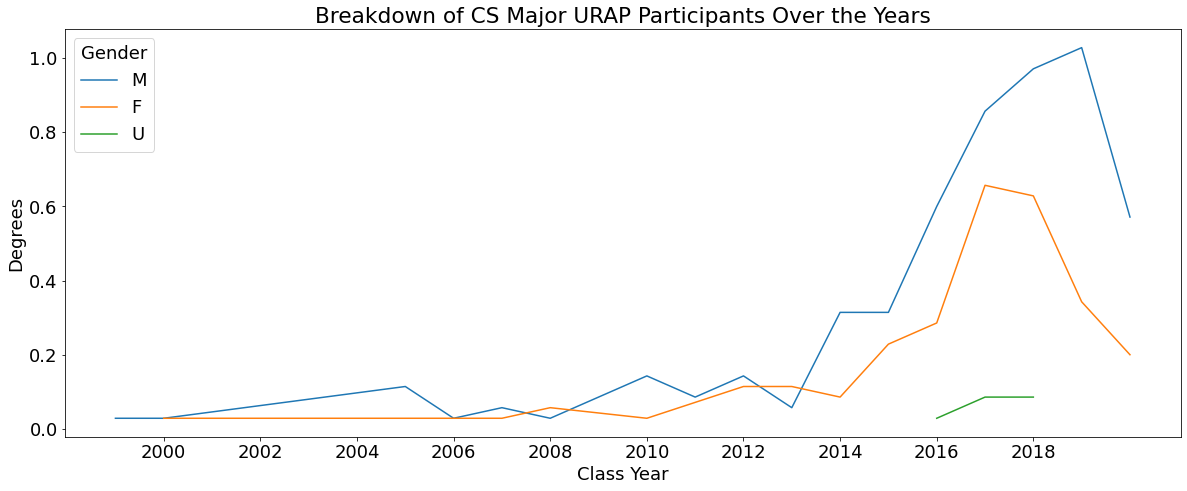

In [70]:
#Let's look at the Computer Science major
computer_science = persisted_stem[persisted_stem["Degrees Name"].str.contains("Computer")]
#computer_science["Count"] = computer_science.groupby()

year_cs = computer_science.groupby(["Class Year", "Gender"]).count()#
year_cs = year_cs["Degrees"] / len(year_cs["Degrees"])
year_cs = year_cs.reset_index()

plt.title("Breakdown of CS Major URAP Participants Over the Years")
plt.xticks(np.arange(2000, 2020, 2))
sns.lineplot(data = year_cs, x = "Class Year", y = "Degrees", hue = "Gender", ci=None);

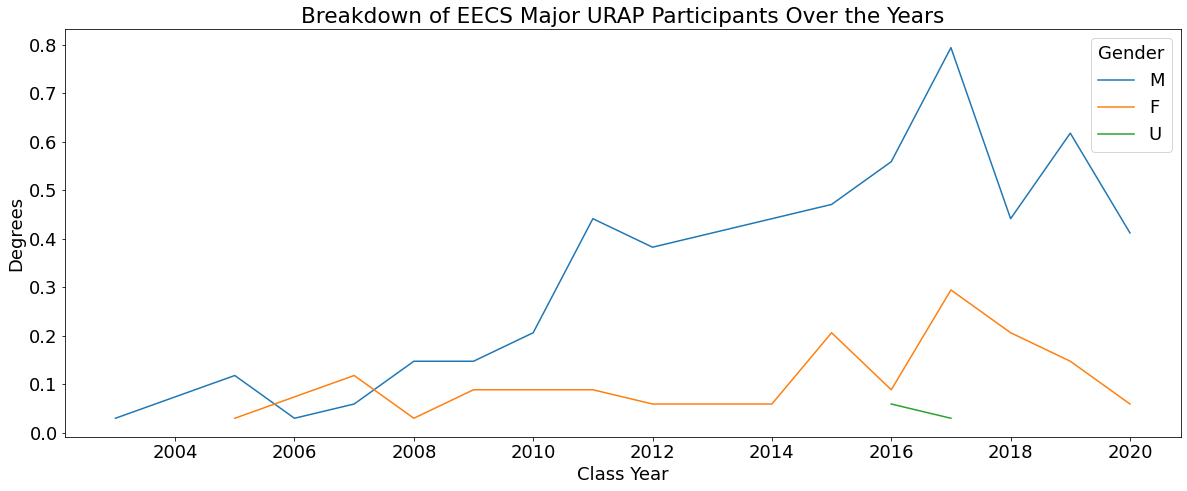

In [71]:
#Let's look at the EECS major
eecs = persisted_stem[persisted_stem["Degrees Name"].str.contains("Comp Sci")]
year_eecs = eecs.groupby(["Class Year", "Gender"]).count()#
year_eecs = year_eecs["Degrees"] / len(year_eecs["Degrees"])
year_eecs = year_eecs.reset_index()


plt.xticks(np.arange(2000, 2021, 2))
plt.title("Breakdown of EECS Major URAP Participants Over the Years")
sns.lineplot(data = year_eecs, x = "Class Year", y = "Degrees", hue = "Gender", ci=None);


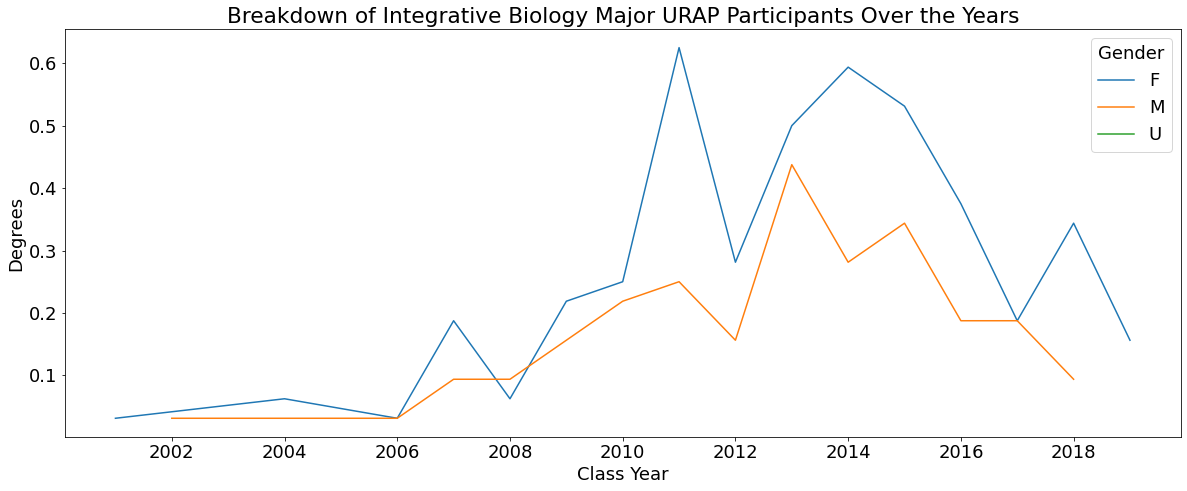

In [72]:
#Let's look ath the Integrative Bio major
int_bio = persisted_stem[persisted_stem["Degrees Name"].str.contains("Integrative Biology")]
year_int_bio = int_bio.groupby(["Class Year", "Gender"]).count()#
year_int_bio = year_int_bio["Degrees"] / len(year_int_bio["Degrees"])
year_int_bio = year_int_bio.reset_index()

plt.xticks(np.arange(2000, 2021, 2))
plt.title("Breakdown of Integrative Biology Major URAP Participants Over the Years")
sns.lineplot(data = year_int_bio, x = "Class Year", y = "Degrees", hue = "Gender", ci=None);


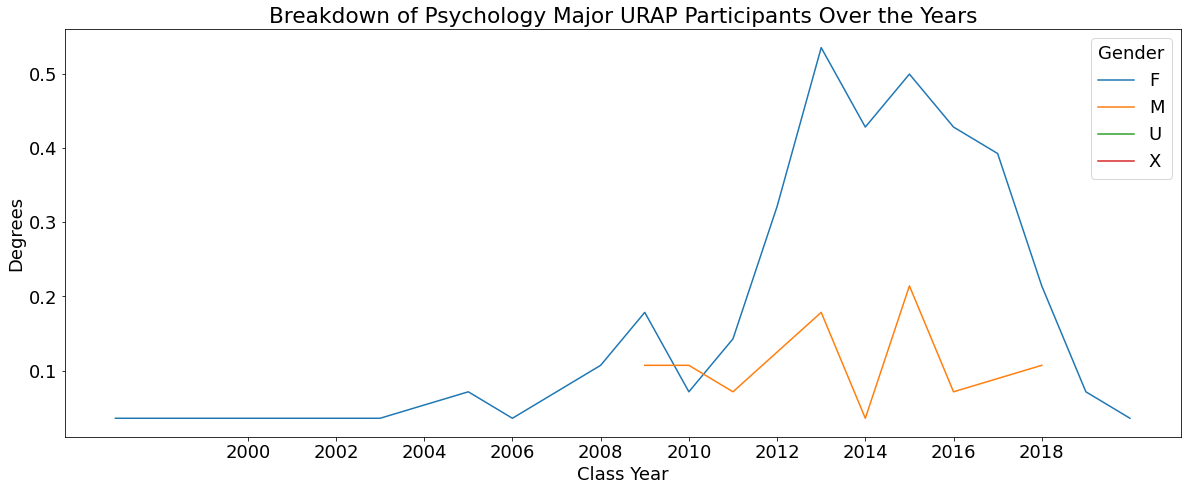

In [73]:
#Let's look at the Psychology major
psych = persisted_stem[persisted_stem["Degrees Name"].str.contains("Psychology")]
year_psych = psych.groupby(["Class Year", "Gender"]).count()#
year_psych = year_psych["Degrees"] / len(year_psych["Degrees"])
year_psych = year_psych.reset_index()

plt.xticks(np.arange(2000, 2020, 2))
plt.title("Breakdown of Psychology Major URAP Participants Over the Years")
sns.lineplot(data = year_psych, x = "Class Year", y = "Degrees", hue = "Gender", ci=None);


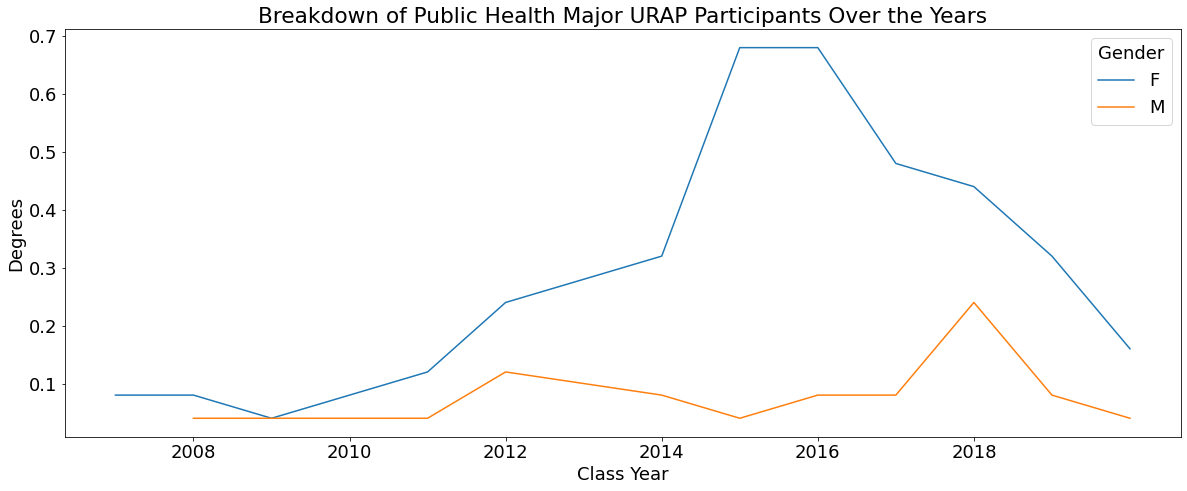

In [74]:
#Let's look at the Public Health major
pb_hlth = persisted_stem[persisted_stem["Degrees Name"].str.contains("Public Health")]
year_pb_hlth = pb_hlth.groupby(["Class Year", "Gender"]).count()#
year_pb_hlth = year_pb_hlth["Degrees"] / len(year_pb_hlth["Degrees"])
year_pb_hlth = year_pb_hlth.reset_index()

plt.xticks(np.arange(2000, 2020, 2))
plt.title("Breakdown of Public Health Major URAP Participants Over the Years")
sns.lineplot(data = year_pb_hlth, x = "Class Year", y = "Degrees", hue = "Gender", ci=None);


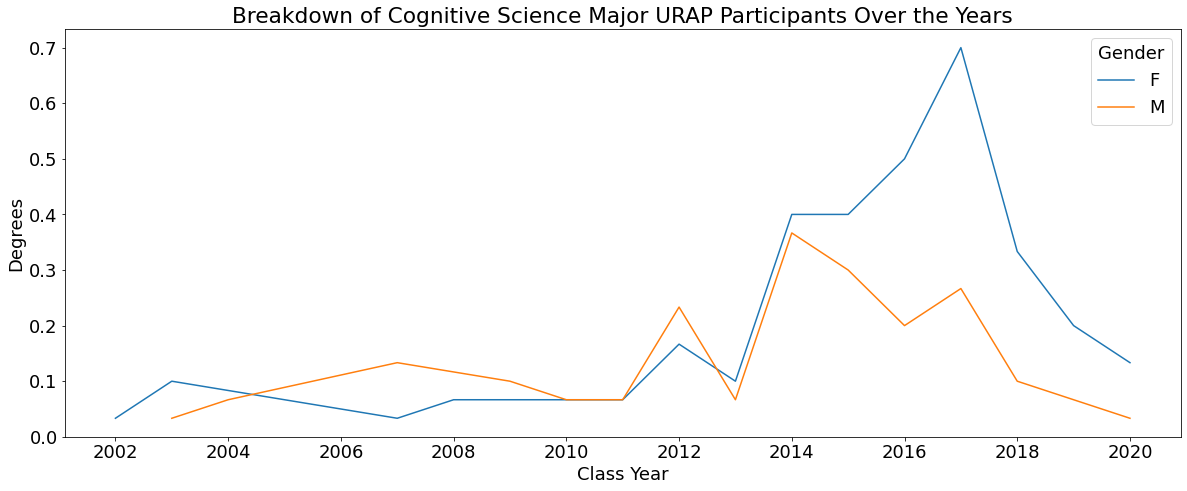

In [75]:
#Just curious how it looks for the COGSCI major
cogsci = persisted_stem[persisted_stem["Degrees Name"].str.contains("Cognitive Science")]
year_cogsci = cogsci.groupby(["Class Year", "Gender"]).count()#
year_cogsci = year_cogsci["Degrees"] / len(year_cogsci["Degrees"])
year_cogsci = year_cogsci.reset_index()

plt.xticks(np.arange(2000, 2021, 2))
plt.title("Breakdown of Cognitive Science Major URAP Participants Over the Years")
sns.lineplot(data = year_cogsci, x = "Class Year", y = "Degrees", hue = "Gender", ci=None);


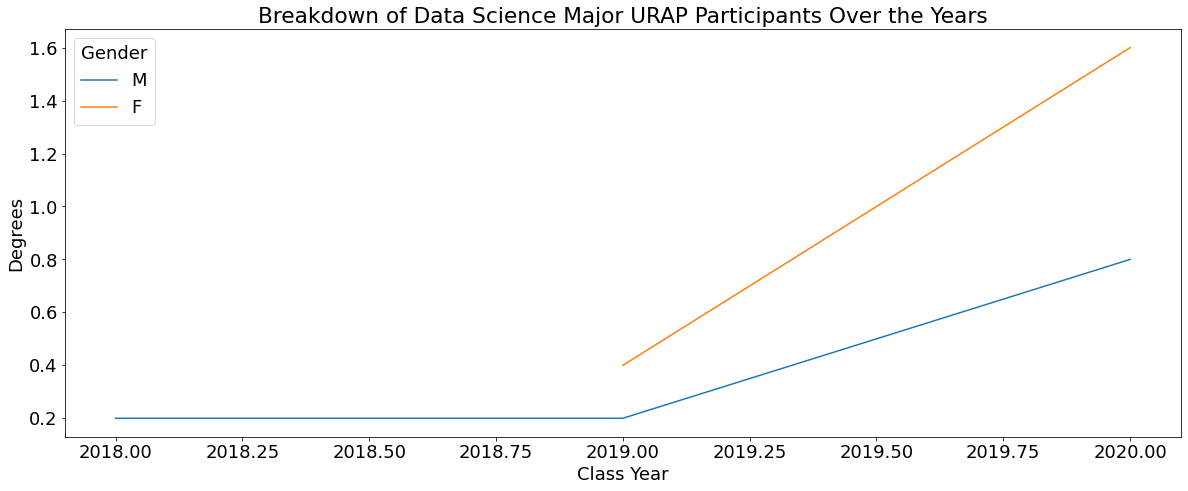

In [76]:
#Just curious how it looks for the Data Science major
ds = persisted_stem[persisted_stem["Degrees Name"].str.contains("Data Science")]
year_ds = ds.groupby(["Class Year", "Gender"]).count()#
year_ds = year_ds["Degrees"] / len(year_ds["Degrees"])
year_ds = year_ds.reset_index()

plt.xticks(np.arange(2018, 2021, 0.25))
plt.title("Breakdown of Data Science Major URAP Participants Over the Years")
sns.lineplot(data = year_ds, x = "Class Year", y = "Degrees", hue = "Gender", ci=None);


Based on the graphs above, it seems that males continue to dominate CS/EECS while females are dominating Psychology, Integrative Biology, and Cognitive Science. There isn't enough data to make inferences on Data Science right now though since there seems to be few Data Science URAP Participants that persisted in STEM.





# Trends in Job Titles and STEM Persistence?

Let's look at the job titles for the males and females who've done URAP and persisted. We can start off by analyzing trends for the top 2 male majors (CS, EECS) and the top 2 female majors (Integrative Biology, Psychology).

We can use the merged dataframe

In [77]:
#consolidated.merge(merged_no_dupl, how='inner', on=,)
#Remove Duplicates in Merged and get most recent job title
merged = merged.sort_values(by = "EndYear")
merged_no_dupl = merged.groupby("ENTITY_ID").agg(lambda x: list(x)[0]).reset_index()
merged_no_dupl["ID"] = merged_no_dupl["ENTITY_ID"]

In [78]:
merged_df = consolidated.merge(merged_no_dupl, how='inner', on="ID")
merged_df.head()

og_merge = merged_df.copy()

In [79]:
intermediate_df = merged_df[["ID", "City", "State", "Country", "Industry", "CompanyName", "Title"]]
intermediate_df.head()

ID           City          State Country          Industry  \
0  724202  San Francisco     California     USA        Accounting   
1  729526  San Francisco     California     USA      Law Practice   
2  732926         Boston  Massachusetts     USA  Higher Education   
3  746450  San Francisco     California     USA    Semiconductors   
4  754146  San Francisco     California     USA             Music   

                                         CompanyName  \
0                                                NaN   
1  United States District Court, Northern Distric...   
2                                 Cornell University   
3       Fujitsu-AMD Semiconductor Ltd "Spansion Inc"   
4                                                NaN   

                                               Title  
0                                                NaN  
1  Judicial Extern to Honorable Saundra B. Armstrong  
2                                 Teaching Assistant  
3                        Wafer Fab Rotation Engineer  
4                                                NaN

In [80]:
#Lets look at the Computer Science Degree
computer_science = computer_science.merge(intermediate_df, on = "ID")

In [81]:
#computer_science[computer_science["Title"].str.contains("Computer")]
most_cs = computer_science.groupby(["Title", "Gender", "Ethnicity and Gender", "Degrees"]).count().sort_values(by = "ID", ascending = False).reset_index()
most_cs["Count"] = most_cs["ID"]
most_cs = most_cs.reset_index()[["Title", "Gender", "Ethnicity and Gender", "Count", "Degrees"]]
most_cs


Title Gender Ethnicity and Gender  Count  \
0         Software Engineering Intern      M           Asian Male      3   
1         Software Engineering Intern      M           Asian Male      3   
2            Software Engineer Intern      M           Asian Male      2   
3                  Research Assistant      F         Asian Female      2   
4            Software Engineer Intern      M           Asian Male      2   
..                                ...    ...                  ...    ...   
277               Logistic Specialist      M           Asian Male      1   
278  Machine Learning Research Intern      M           Asian Male      1   
279                      Madrich (TA)      M           White Male      1   
280                  Marketing Intern      F         Asian Female      1   
281                 Xcode QA Engineer      M           Asian Male      1   

                                               Degrees  
0                           B.A. Computer Science 2019  
1                           B.A. Computer Science 2017  
2                           B.A. Computer Science 2019  
3                           B.A. Computer Science 2017  
4     B.A. Computer Science 2017; B.A. Statistics 2017  
..                                                 ...  
277                         B.A. Computer Science 2018  
278  B.A. Computer Science 2019; M.S. Electrical En...  
279   B.A. Computer Science 2017; B.A. Statistics 2017  
280  B.A. Computer Science 2015; B.A. Economics 201...  
281                         B.A. Computer Science 2011  

[282 rows x 5 columns]

In [82]:
most_cs["Job First Word"] = most_cs["Title"].str.lower().str.split().str.get(0)#.str.extractall(r"")
most_group_cs = most_cs.groupby(["Job First Word", "Gender"]).count().reset_index()
most_group_cs = most_group_cs.sort_values(by = "Count", ascending = False)



In [83]:
male_most_group_cs = most_group_cs[most_group_cs["Gender"] == "M"].sort_values(by = "Count", ascending = False)
male_most_group_cs["Count"] = male_most_group_cs["Count"]/len(male_most_group_cs["Count"])



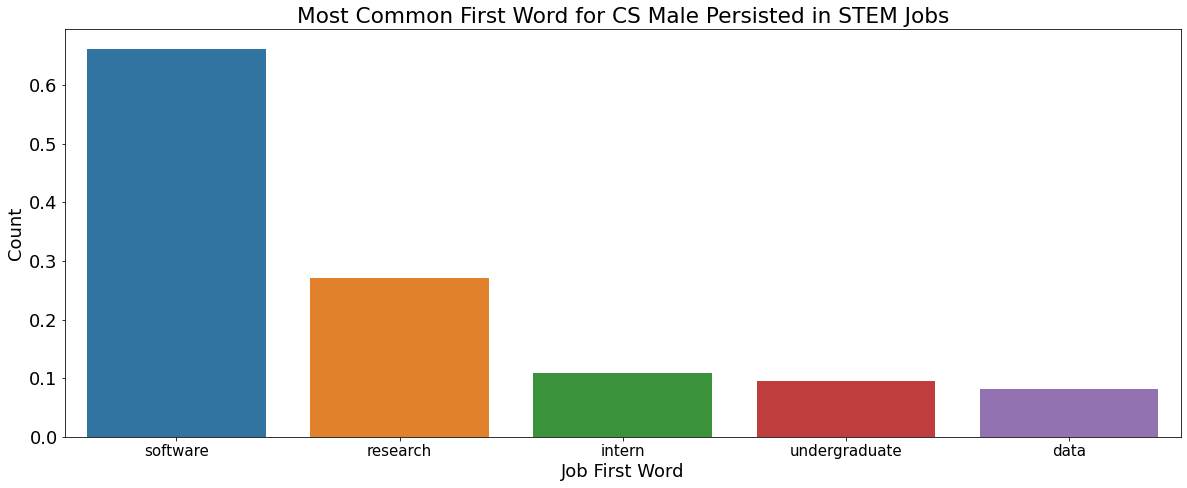

In [84]:
plt.title("Most Common First Word for CS Male Persisted in STEM Jobs")
sns.barplot(data = male_most_group_cs.head(5), x = "Job First Word", y = "Count");
plt.xticks(fontsize=15);#, rotation = 45);



In [85]:
female_most_group_cs = most_group_cs[most_group_cs["Gender"] == "F"].sort_values(by = "Count", ascending = False)
female_most_group_cs["Count"] = female_most_group_cs["Count"]/len(female_most_group_cs["Count"])

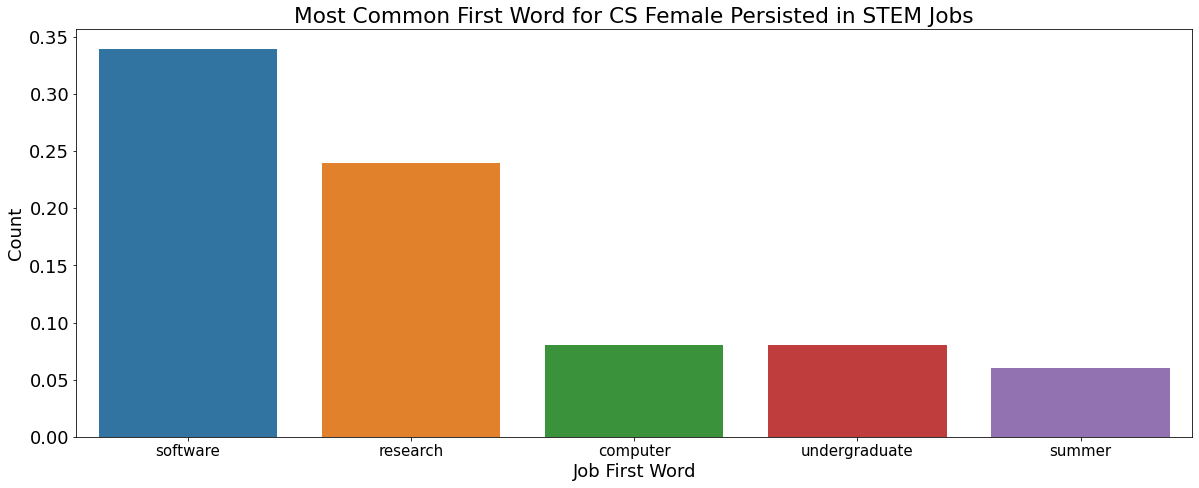

In [86]:
plt.title("Most Common First Word for CS Female Persisted in STEM Jobs")
sns.barplot(data = female_most_group_cs.head(5), x = "Job First Word", y = "Count");
plt.xticks(fontsize=15);#, rotation = 45);


In [87]:
#Lets look at the EECS Degree
eecs = eecs.merge(intermediate_df, on = "ID").reset_index()

most_eecs = eecs.groupby(["Title", "Gender", "Ethnicity and Gender", "Degrees"]).count().sort_values(by = "ID", ascending = False).reset_index()
most_eecs["Count"] = most_eecs["ID"]

most_eecs = most_eecs.reset_index()[["Title", "Gender", "Ethnicity and Gender", "Count"]]
most_eecs["Job First Word"] = most_eecs["Title"].str.lower().str.split().str.get(0)#.str.extractall(r"")
most_group_eecs = most_eecs.groupby(["Job First Word", "Gender"]).count().reset_index()
most_group_eecs = most_group_eecs.sort_values(by = "Count", ascending = False)
most_group_eecs


Job First Word Gender  Title  Ethnicity and Gender  Count
82        software      M     48                    48     48
73        research      M     15                    15     15
81        software      F     14                    14     14
97   undergraduate      M     13                    13     13
42          intern      M     10                    10     10
..             ...    ...    ...                   ...    ...
34           girls      F      1                     1      1
33            full      M      1                     1      1
32           front      M      1                     1      1
31         founder      M      1                     1      1
102       wireless      M      1                     1      1

[103 rows x 5 columns]

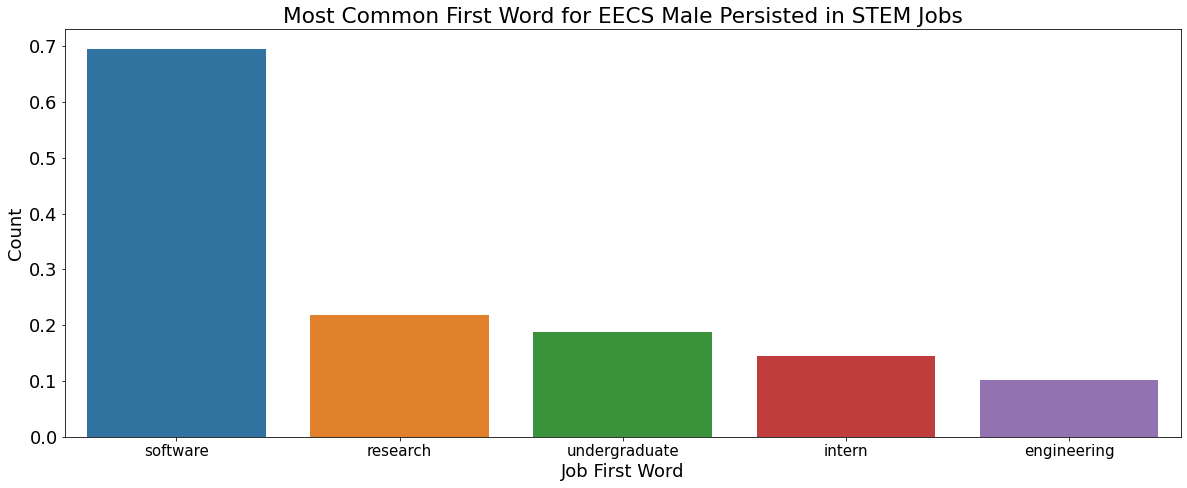

In [88]:
male_most_group_eecs = most_group_eecs[most_group_eecs["Gender"] == "M"].sort_values(by = "Count", ascending = False)
male_most_group_eecs["Count"] = male_most_group_eecs["Count"]/len(male_most_group_eecs["Count"])
plt.title("Most Common First Word for EECS Male Persisted in STEM Jobs")
sns.barplot(data = male_most_group_eecs.head(5), x = "Job First Word", y = "Count");
plt.xticks(fontsize=15);#, rotation = 45);






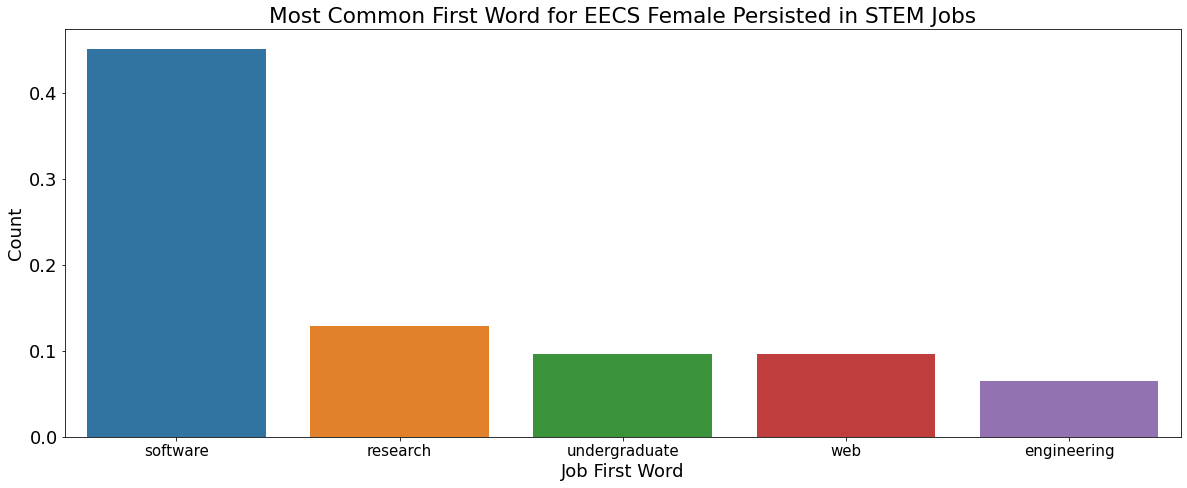

In [89]:
female_most_group_eecs = most_group_eecs[most_group_eecs["Gender"] == "F"].sort_values(by = "Count", ascending = False)
female_most_group_eecs["Count"] = female_most_group_eecs["Count"]/len(female_most_group_eecs["Count"])
plt.title("Most Common First Word for EECS Female Persisted in STEM Jobs")
sns.barplot(data = female_most_group_eecs.head(5), x = "Job First Word", y = "Count");
plt.xticks(fontsize=15);#, rotation = 45);



In [90]:
merged_df = consolidated.merge(intermediate_df, on = "ID")
merged_df.head()



Class Year                                            Degrees  \
0        2001                  B.S. Business Administration 2001   
1        2005  B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...   
2        2005                           B.S. Bioengineering 2005   
3        2004           B.S. Nuclear Engineering: Undergrad 2004   
4        2007    B.A. Classical Languages 2007; M.A. Design 2012   

          Ethnicity Gender      ID  Is STEM Degree  STEM Job Within 5 Years  \
0             White      F  724202             1.0                      NaN   
1             Asian      M  729526             0.0                      0.0   
2             Asian      M  732926             1.0                      0.0   
3             Asian      M  746450             1.0                      1.0   
4  Decline to State      M  754146             0.0                      NaN   

  Simple Gender   Ethnicity and Gender                          Degrees Name  \
0        Female           White Female         B.S. Business Administration    
1          Male             Asian Male                        B.A. Rhetoric    
2          Male             Asian Male                  B.S. Bioengineering    
3          Male             Asian Male  B.S. Nuclear Engineering: Undergrad    
4          Male  Decline to State Male             B.A. Classical Languages    

            City          State Country          Industry  \
0  San Francisco     California     USA        Accounting   
1  San Francisco     California     USA      Law Practice   
2         Boston  Massachusetts     USA  Higher Education   
3  San Francisco     California     USA    Semiconductors   
4  San Francisco     California     USA             Music   

                                         CompanyName  \
0                                                NaN   
1  United States District Court, Northern Distric...   
2                                 Cornell University   
3       Fujitsu-AMD Semiconductor Ltd "Spansion Inc"   
4                                                NaN   

                                               Title  
0                                                NaN  
1  Judicial Extern to Honorable Saundra B. Armstrong  
2                                 Teaching Assistant  
3                        Wafer Fab Rotation Engineer  
4                                                NaN

In [91]:
#software, research, data, product
#look at the job titles and most common majors

#look economics?

In [92]:
software = merged_df[merged_df["Title"].str.lower().str.contains("software", na=False)]#[eecs["Title"]].str.contains("soft", na=False)]
#software
software["Degrees Name"] = software["Degrees"].str.extract(r"([^0-9\n]+)")
software = software.groupby("Degrees Name").count().reset_index()
software["Count"] = software["ID"]
software["Percent"] = software["Count"] / len(software)
software = software.sort_values(by = "Count", ascending = False)[["Degrees Name", "Count", "Percent"]]
software.head()



/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/3341393063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  software["Degrees Name"] = software["Degrees"].str.extract(r"([^0-9\n]+)")


Degrees Name  Count   Percent
7                        B.A. Computer Science      94  2.848485
29  B.S. Electrical Engr & Comp Sci: Undergrad      91  2.757576
3                     B.A. Applied Mathematics      19  0.575758
5                       B.A. Cognitive Science      16  0.484848
9                               B.A. Economics       6  0.181818

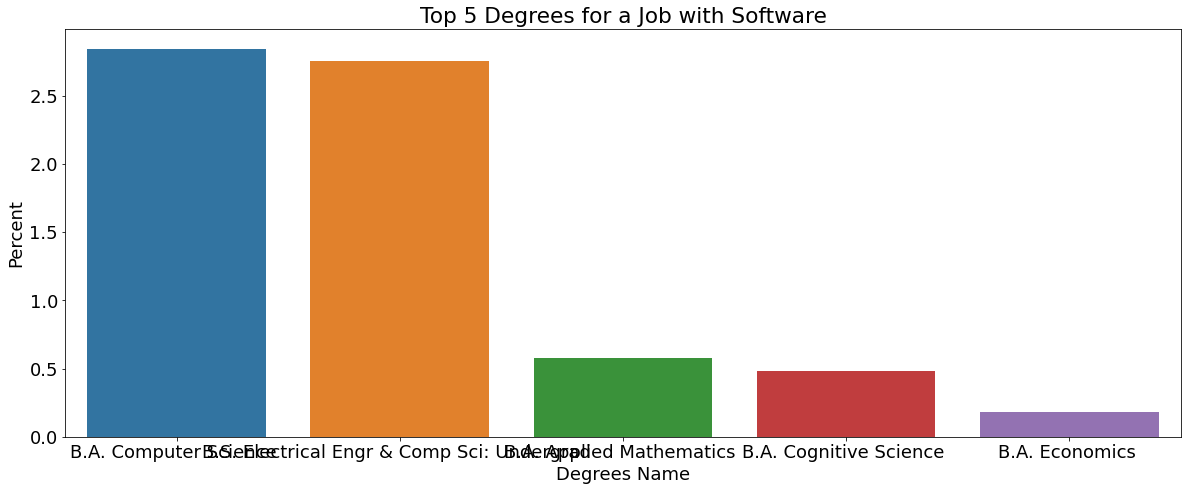

In [93]:
plt.title("Top 5 Degrees for a Job with Software")
sns.barplot(data = software.head(5), x = "Degrees Name", y = "Percent", ci = None);



In [94]:
research = merged_df[merged_df["Title"].str.lower().str.contains("research", na=False)]#[eecs["Title"]].str.contains("soft", na=False)]
#software
research["Degrees Name"] = research["Degrees"].str.extract(r"([^0-9\n]+)")
research = research.groupby("Degrees Name").count().reset_index()
research["Count"] = research["ID"]
research["Percent"] = research["Count"] / len(research)
research = research.sort_values(by = "Count", ascending = False)[["Degrees Name", "Count", "Percent"]]
research.head()




/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/3822163391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  research["Degrees Name"] = research["Degrees"].str.extract(r"([^0-9\n]+)")


Degrees Name  Count   Percent
25            B.A. Economics      97  0.932692
40  B.A. Integrative Biology      95  0.913462
22     B.A. Computer Science      79  0.759615
20    B.A. Cognitive Science      70  0.673077
10  B.A. Applied Mathematics      67  0.644231

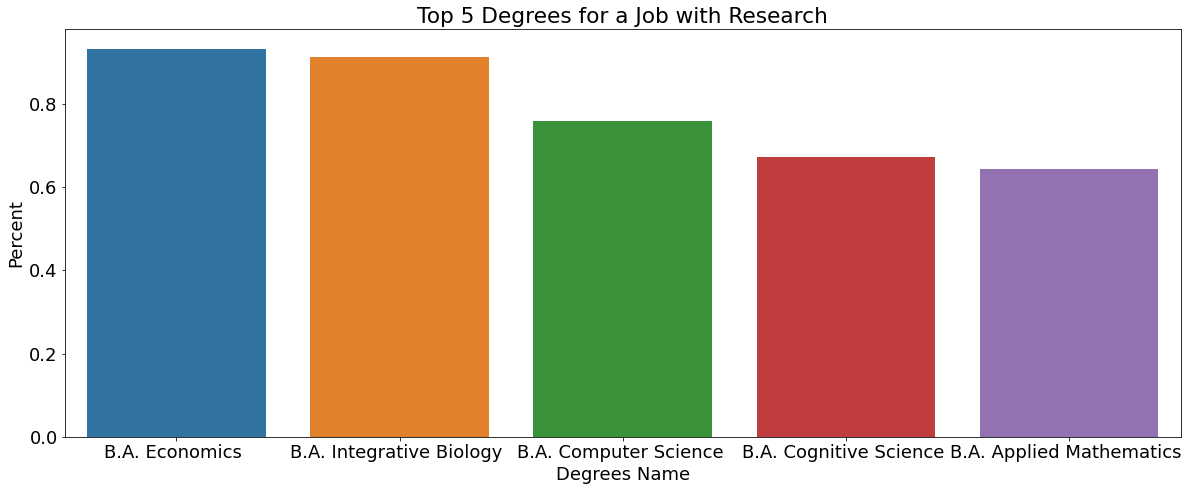

In [95]:
plt.title("Top 5 Degrees for a Job with Research")
sns.barplot(data = research.head(5), x = "Degrees Name", y = "Percent", ci = None);


In [96]:
data = merged_df[merged_df["Title"].str.lower().str.contains("data", na=False)]
data["Degrees Name"] = data["Degrees"].str.extract(r"([^0-9\n]+)")
data = data.groupby("Degrees Name").count().reset_index()
data["Count"] = data["ID"]
data["Percent"] = data["Count"] / len(data)
data = data.sort_values(by = "Count", ascending = False)[["Degrees Name", "Count", "Percent"]]
data.head()



/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/3815625391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Degrees Name"] = data["Degrees"].str.extract(r"([^0-9\n]+)")


Degrees Name  Count   Percent
5      B.A. Computer Science      15  0.483871
2   B.A. Applied Mathematics      11  0.354839
7             B.A. Economics      10  0.322581
19           B.A. Statistics       7  0.225806
6          B.A. Data Science       6  0.193548

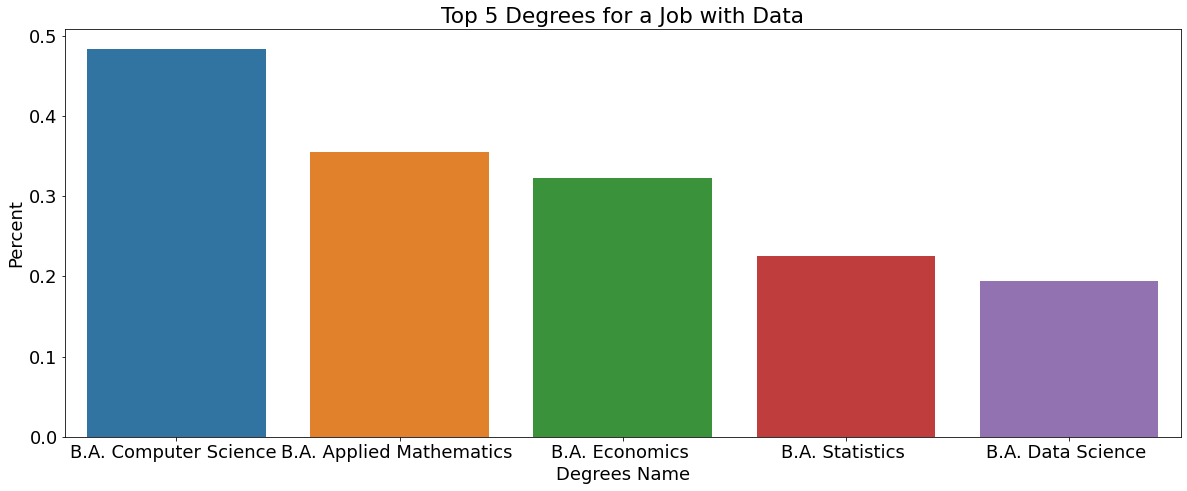

In [97]:
plt.title("Top 5 Degrees for a Job with Data")
sns.barplot(data = data.head(5), x = "Degrees Name", y = "Percent", ci = None);


In [98]:
product = merged_df[merged_df["Title"].str.lower().str.contains("product", na=False)]#[eecs["Title"]].str.contains("soft", na=False)]
product["Degrees Name"] = product["Degrees"].str.extract(r"([^0-9\n]+)")
product = product.groupby("Degrees Name").count().reset_index()
product["Count"] = product["ID"]
product["Percent"] = product["Count"] / len(product)
product = data.sort_values(by = "Count", ascending = False)[["Degrees Name", "Count", "Percent"]]
product.head()


/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/375744647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product["Degrees Name"] = product["Degrees"].str.extract(r"([^0-9\n]+)")


Degrees Name  Count   Percent
5      B.A. Computer Science      15  0.483871
2   B.A. Applied Mathematics      11  0.354839
7             B.A. Economics      10  0.322581
19           B.A. Statistics       7  0.225806
6          B.A. Data Science       6  0.193548

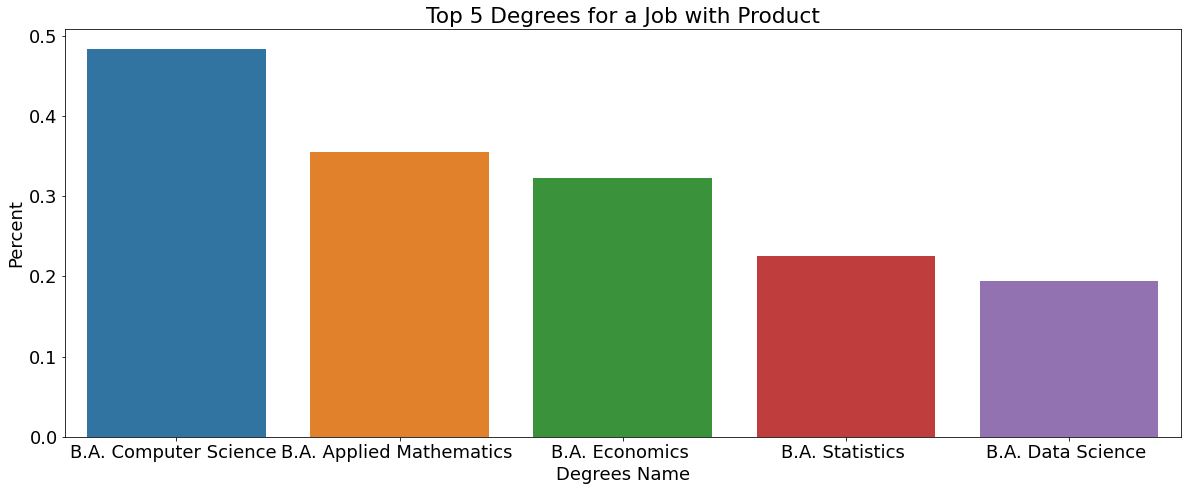

In [99]:
plt.title("Top 5 Degrees for a Job with Product")
sns.barplot(data = product.head(5), x = "Degrees Name", y = "Percent", ci = None);



In [100]:
economics = merged_df[merged_df["Degrees"].str.lower().str.contains("economics", na=False)]
econ_stem_job = len(economics[economics["STEM Job Within 5 Years"] == 1.0]) / len(economics)
econ_no_stem_job = len(economics[economics["STEM Job Within 5 Years"] == 0.0]) / len(economics)

#[economics["Title"].str.lower().str.contains("analyst", na=False)]
print("Economics Stem Job Percentage: %", econ_stem_job * 100)
print("Economics No Stem Job Percentage: %", econ_no_stem_job * 100)


Economics Stem Job Percentage: % 48.032564450474894
Economics No Stem Job Percentage: % 35.68521031207598


In [101]:
econ_stem = economics[economics["STEM Job Within 5 Years"] == 1.0]
econ_stem#.groupby("Ethnicity").count().reset_index()
set(econ_stem["Ethnicity"])

{'African American',
 'Asian',
 'Chicano/Latino',
 'Decline to State',
 'Native American/Alaska Native',
 'Other',
 'White'}

In [102]:
ethnic_econ = econ_stem.groupby("Ethnicity and Gender").count().reset_index().sort_values(by = "ID", ascending = False)
ethnic_econ["Percent"] = ethnic_econ["ID"]/sum(ethnic_econ["ID"].to_numpy()) * 100
ethnic_econ[["Ethnicity and Gender", "Percent"]]


Ethnicity and Gender    Percent
1                         Asian Female  36.723164
2                           Asian Male  29.661017
11                          White Male  13.841808
10                        White Female   9.039548
6              Decline to State Female   3.389831
7                Decline to State Male   2.824859
5                  Chicano/Latino Male   2.259887
0              African American Female   0.564972
3                          Asian Other   0.564972
8   Native American/Alaska Native Male   0.564972
4                Chicano/Latino Female   0.282486
9                           Other Male   0.282486

In [103]:
econ_stem.head(3)

Class Year                                            Degrees Ethnicity  \
9         2006                                B.A. Economics 2006     Asian   
36        2009  B.A. Economics 2009; B.S. Business Administrat...     Asian   
54        2008  B.A. Economics 2008; B.A. Oper Rsch & Manageme...     Other   

   Gender      ID  Is STEM Degree  STEM Job Within 5 Years Simple Gender  \
9       F  755980             0.0                      1.0        Female   
36      F  840963             1.0                      1.0        Female   
54      M  939932             0.0                      1.0          Male   

   Ethnicity and Gender     Degrees Name           City       State Country  \
9          Asian Female  B.A. Economics   San Francisco  California     USA   
36         Asian Female  B.A. Economics   San Francisco  California     USA   
54           Other Male  B.A. Economics   San Francisco  California     USA   

      Industry                    CompanyName                        Title  
9   Accounting  Center for Project Management             Marketing Intern  
36     Banking          City of Monterey Park  Economic Development Intern  
54    Research            The Washington Post               Data Scientist

# Students in Economics Major That Persisted in STEM

__About 48% of Economics Majors Persisted in STEM__

* Breakdown of Ethnicity of Economics Majors Who Persisted in STEM:
    * African American
    * Asian
    * Chicano/Latino
    * Native American/Alaska Native
    * Other
    * White
    * Decline to State


* Within this, our top 2 are Asians and White




# GPA Trends

__Let's look at GPA trends__




In [104]:
gpa.head()

Project Term Last Name First Name   Standing Transfer    gpa
0    Fall 2012   DiRocco     Alyson  Sophomore      NaN  3.707
1    Fall 2012      Aung     Kelvin     Junior      NaN  3.387
2    Fall 2012    Vancil  Stephanie     Junior      NaN  3.469
3    Fall 2012  Osadchiy      Vadim   Freshman      NaN    4.0
4    Fall 2012   Vassalo      Brian     Senior  Fall 11  3.533

In [105]:
og_merge.head()

Class Year                                            Degrees  \
0        2001                  B.S. Business Administration 2001   
1        2005  B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...   
2        2005                           B.S. Bioengineering 2005   
3        2004           B.S. Nuclear Engineering: Undergrad 2004   
4        2007    B.A. Classical Languages 2007; M.A. Design 2012   

          Ethnicity Gender      ID  Is STEM Degree_x  STEM Job Within 5 Years  \
0             White      F  724202               1.0                      NaN   
1             Asian      M  729526               0.0                      0.0   
2             Asian      M  732926               1.0                      0.0   
3             Asian      M  746450               1.0                      1.0   
4  Decline to State      M  754146               0.0                      NaN   

  Simple Gender   Ethnicity and Gender                          Degrees Name  \
0        Female           White Female         B.S. Business Administration    
1          Male             Asian Male                        B.A. Rhetoric    
2          Male             Asian Male                  B.S. Bioengineering    
3          Male             Asian Male  B.S. Nuclear Engineering: Undergrad    
4          Male  Decline to State Male             B.A. Classical Languages    

   ENTITY_ID  Unnamed: 0_x  CLASSYR GENDER EMPLOYER         ethnicity  \
0     724202             5     2001      F      NaN             White   
1     729526             6     2005      M      NaN             Asian   
2     732926             7     2005      M      NaN             Asian   
3     746450             8     2004      M      NaN             Asian   
4     754146             9     2007      M      NaN  Decline to State   

                                             DEGREES joined_uerap URAP_Year  \
0                  B.S. Business Administration 2001   2000-09-01      2000   
1  B.A. Rhetoric 2005; B.A. Spanish 2005; J.D. La...   2004-02-01      2004   
2                           B.S. Bioengineering 2005   2004-02-01      2004   
3           B.S. Nuclear Engineering: Undergrad 2004   2003-02-01      2003   
4    B.A. Classical Languages 2007; M.A. Design 2012   2003-09-01      2003   

   index  Unnamed: 0_y  Constituent ID      Full Name  \
0   8231        147090        724202.0  Bonnie Salkhi   
1  68318        283103        729526.0    Eugene Park   
2  67790         13122        732926.0  Vishal Tandon   
3  99087        194037        746450.0     Marowen Ng   
4   5760         31713        754146.0  Anthony Bello   

                                                 Url           City  \
0  https://www.linkedin.com/in/bonnie-salkhi-8219...  San Francisco   
1            https://www.linkedin.com/in/eugenejpark  San Francisco   
2  https://www.linkedin.com/in/vishal-tandon-8a7a...         Boston   
3              https://www.linkedin.com/in/marowenng  San Francisco   
4      https://www.linkedin.com/in/anthonybellomusic  San Francisco   

           State Country          Industry FirstName MiddleName LastName  \
0     California     USA        Accounting    Bonnie        NaN   Salkhi   
1     California     USA      Law Practice    Eugene        NaN     Park   
2  Massachusetts     USA  Higher Education    Vishal        NaN   Tandon   
3     California     USA    Semiconductors   Marowen        NaN       Ng   
4     California     USA             Music   Anthony        NaN    Bello   

  Nickname                            University                    Degree  \
0      NaN  Haas School of Business, UC Berkeley  Bachelor of Science (BS)   
1      NaN    University of California, Berkeley                        BA   
2      NaN                                   NaN                       NaN   
3      NaN           Garden International School                       NaN   
4      NaN    University of California, Berkeley                      B.A.   

                

In [112]:
gpa["Full Name"] = (gpa["First Name"] + " " + gpa["Last Name"]).astype(str)

gpa_info = gpa[pd.to_numeric(gpa['gpa'], errors='coerce').notnull()]
gpa_info['gpa'] = pd.to_numeric(gpa_info['gpa'])
gpa_info = gpa_info[(gpa_info['gpa']>0) & (gpa_info['gpa']<=4)]

gpa_info['Transfer_Student'] = np.multiply(gpa_info["Transfer"].notna(), 1)
gpa_info.dropna(subset = ['Standing'])
gpa_info['Standing'].replace({'Freshman':1, 'Sophomore':2, 'Sophmore':2, 'sophomore':2,
                              'Junior':3, 'junior':3, 'Senior':4, 'senior':4}, inplace=True)
gpa_info = gpa_info.reindex(columns=['Full Name','Standing','Transfer_Student','gpa'])
gpa_info = gpa_info.drop_duplicates('Full Name')

new_merged_gpa = og_merge.merge(gpa_info, left_on = 'Full Name', right_on = 'Full Name', how='inner')
new_merged_gpa["Transfer_Student"] = new_merged_gpa["Transfer_Student"].replace({0: False, 1: True})
new_merged_gpa["Is STEM Degree"] = new_merged_gpa["Is STEM Degree_y"]
new_merged_gpa["STEM Job Within 5 Years"] = new_merged_gpa["STEM Job Within 5 Years"].replace({0: False, 1: True})
#new_merged_gpa.head()

/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/2143101748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpa_info['gpa'] = pd.to_numeric(gpa_info['gpa'])


In [113]:
stem_persist_gpa = new_merged_gpa[new_merged_gpa["STEM Job Within 5 Years"] == True]
dfx = stem_persist_gpa.groupby(["Degrees Name", 
                                "Ethnicity and Gender",
                                "Is STEM Degree", "STEM Job Within 5 Years"]).agg({
                                "gpa" : 'mean',
                                "ID" : 'count'
                            }).sort_values(by = "ID", ascending = False).reset_index()
dfx["Count"] = dfx["ID"]
dfx["Percentage"] = dfx["Count"] / len(dfx)
degrees_lst =list(dfx.groupby("Degrees Name").agg({"Ethnicity and Gender": lambda x: x,
                                                   "Is STEM Degree": lambda x: list(x)[0],
                                "Count" : 'sum'}).reset_index().sort_values(by = "Count",
               
                                                                            ascending = False)["Degrees Name"])

#dfx[dfx["De"]]
top_10 = dfx[dfx["Degrees Name"].isin(degrees_lst[:10])]
top_10["GPA"] = (round(top_10["gpa"], 2))
#len(top_10[top_10["Ethnicity and Gender"] == "Asian Female"]) --> 13
top_10_final = top_10.groupby(["Degrees Name", "Ethnicity and Gender"]).agg({'Count': "sum", 
                            "Percentage": "sum", "GPA": "mean"}).reset_index().sort_values(by = "Percentage", 
       
                                                                                           ascending = False)
top_10_final["GPA"] = (round(top_10_final["GPA"], 2))
top_10_final

top_10_final = top_10_final.replace({"Decline to State Female" : "Other Female",
                                    "Decline to State Male" : "Other Male",
                                    "Decline to State Other": "Other"})
top_10_final = top_10_final.sort_values(by = "Percentage", ascending = False)
top_10_final

/var/folders/ss/t50s68mj13b1mx7c4rsps81m0000gn/T/ipykernel_55593/558877740.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10["GPA"] = (round(top_10["gpa"], 2))


Degrees Name  \
30                       B.A. Computer Science    
85  B.S. Electrical Engr & Comp Sci: Undergrad    
29                       B.A. Computer Science    
38                              B.A. Economics    
77                          B.A. Public Health    
..                                          ...   
91  B.S. Electrical Engr & Comp Sci: Undergrad    
1                            B.A. Anthropology    
52                    B.A. Integrative Biology    
66                             B.A. Psychology    
45                    B.A. Integrative Biology    

                    Ethnicity and Gender  Count  Percentage   GPA  
30                            Asian Male    101    0.224444  3.67  
85                            Asian Male     80    0.177778  3.65  
29                          Asian Female     62    0.137778  3.58  
38                          Asian Female     45    0.100000  3.58  
77                          Asian Female     38    0.084444  3.55  
..                                   ...    ...         ...   ...  
91                                 Other      1    0.002222  3.60  
1                  African American Male      1    0.002222  3.70  
52  Native American/Alaska Native Female      1    0.002222  2.82  
66                 African American Male      1    0.002222  4.00  
45               African American Female      1    0.002222  3.12  

[94 rows x 5 columns]

In [114]:
fig = px.bar(top_10_final, x = "Degrees Name", y ="Percentage", 
             color = "Ethnicity and Gender", 
             title = "Top 10 Degrees for STEM Job Persistence (STEM Job within 5 years of Graduation)",
             
             height =1400, width = 1000, text = "GPA")

fig.update_layout(legend = dict(font = dict(size = 10, color = "black")),
                  legend_title = dict(font = dict(size = 10, color = "blue")))
fig.show()  

In [115]:
zz = dfx.groupby("Ethnicity and Gender").sum().sort_values(by = "Count", ascending = False)
zz["ID"] = zz["ID"] / sum(zz["Count"])
zz

Is STEM Degree  STEM Job Within 5 Years  \
Ethnicity and Gender                                                            
Asian Female                                      60                       92   
Asian Male                                        45                       58   
White Female                                      55                       79   
White Male                                        37                       51   
Chicano/Latino Female                             20                       39   
Decline to State Female                           25                       31   
Chicano/Latino Male                               20                       29   
Decline to State Male                             14                       20   
African American Female                           13                       20   
Asian Other                                        7                        7   
Native American/Alaska Native Female               3                        8   
African American Male                              3                        5   
Native American/Alaska Native Male                 3                        3   
White Other                                        2                        3   
Decline to State Other                             2                        2   
Chicano/Latino Other                               1                        1   
Pacific Islander Male                              1                        1   
African American Other                             1                        1   

                                             gpa        ID  Count  Percentage  
Ethnicity and Gender                                                           
Asian Female                          323.372069  0.325129    568    1.262222  
Asian Male                            202.056781  0.234688    410    0.911111  
White Female                          279.850377  0.167144    292    0.648889  
White Male                            185.290753  0.103606    181    0.402222  
Chicano/Latino Female                 131.203583  0.048082     84    0.186667  
Decline to State Female               110.292750  0.032055     56    0.124444  
Chicano/Latino Male                    97.536917  0.028048     49    0.108889  
Decline to State Male                  71.033271  0.023469     41    0.091111  
African American Female                66.667400  0.016600     29    0.064444  
Asian Other                            25.752333  0.006297     11    0.024444  
Native American/Alaska Native Female   29.541000  0.004579      8    0.017778  
African American Male                  18.441000  0.003434      6    0.013333  
Native American/Alaska Native Male     10.958500  0.002290      4    0.008889  
White Other                            10.644000  0.001717      3    0.006667  
Decline to State Other                  7.045000  0.001145      2    0.004444  
Chicano/Latino Other                    3.618000  0.000572      1    0.002222  
Pacific Islander Male                   2.940000  0.000572      1    0.002222  
African American Other                  3.100000  0.000572      1    0.002222

In [116]:
new_merged_gpa["Title"]


0                                     Intern
1                                        NaN
2       Software Development Engineer Intern
3                                 Consultant
4                                        NaN
                        ...                 
3651                            Photographer
3652                          Language Tutor
3653                       Mathematics Tutor
3654        Undergraduate Research Assistant
3655                Senior Assistant Manager
Name: Title, Length: 3656, dtype: object

In [117]:
software = new_merged_gpa[new_merged_gpa["Title"].str.lower().str.contains("software", na=False)]

software = software.groupby(["Degrees Name", "Ethnicity and Gender"]).agg({"ID": "count", "gpa": "mean"}).reset_index()
software["Count"] = software["ID"]
software["Percent"] = software["Count"] / sum(software["Count"])
software = software.sort_values(by = "Count", ascending = False)
software["GPA"] =  (round(software["gpa"], 2))
software.head()


Degrees Name Ethnicity and Gender  ID  \
9                        B.A. Computer Science            Asian Male  42   
30  B.S. Electrical Engr & Comp Sci: Undergrad            Asian Male  30   
8                        B.A. Computer Science          Asian Female  14   
29  B.S. Electrical Engr & Comp Sci: Undergrad          Asian Female   7   
1                     B.A. Applied Mathematics            Asian Male   7   

         gpa  Count   Percent   GPA  
9   3.685690     42  0.272727  3.69  
30  3.615467     30  0.194805  3.62  
8   3.593000     14  0.090909  3.59  
29  3.691571      7  0.045455  3.69  
1   3.580857      7  0.045455  3.58

In [118]:
fig = px.bar(software, x = "Degrees Name", y ="Percent", 
             color = "Ethnicity and Gender", 
             title = "Top Degrees for Job Involving Software", text = "GPA", height = 800)
fig.show()

In [119]:
data = new_merged_gpa[new_merged_gpa["Title"].str.lower().str.contains("data", na=False)]

data = data.groupby(["Degrees Name", "Ethnicity and Gender"]).agg({"ID": "count", "gpa": "mean"}).reset_index()
data["Count"] = data["ID"]
data["Percent"] = data["Count"] / sum(data["Count"])
data = data.sort_values(by = "Count", ascending = False)
data["GPA"] =  (round(data["gpa"], 2))
data.head()

fig = px.bar(data, x = "Degrees Name", y ="Percent", 
             color = "Ethnicity and Gender", 
             title = "Top Degrees for Job Involving Data", text = "GPA", height = 800)
fig.show()

In [120]:
product = new_merged_gpa[new_merged_gpa["Title"].str.lower().str.contains("product", na=False)]

product = product.groupby(["Degrees Name", "Ethnicity and Gender"]).agg({"ID": "count", "gpa": "mean"}).reset_index()
product["Count"] = product["ID"]
product["Percent"] = product["Count"] / sum(product["Count"])
product = product.sort_values(by = "Count", ascending = False)
product["GPA"] =  (round(product["gpa"], 2))
product.head()

fig = px.bar(product, x = "Degrees Name", y ="Percent", 
             color = "Ethnicity and Gender", 
             title = "Top Degrees for Job Involving Product", text = "GPA", height = 800)
fig.show()

In [121]:
research = new_merged_gpa[new_merged_gpa["Title"].str.lower().str.contains("research", na=False)]

research = research.groupby(["Degrees Name", "Ethnicity and Gender"]).agg({"ID": "count", "gpa": "mean"}).reset_index()
research["Count"] = research["ID"]
research["Percent"] = research["Count"] / sum(research["Count"])
research = research.sort_values(by = "Count", ascending = False)
research["GPA"] =  (round(research["gpa"], 2))

deg = list(research['Degrees Name'])
plot_res = research[research["Degrees Name"].isin(deg[:19])]

fig = px.bar(plot_res, x = "Degrees Name", y ="Percent", 
             color = "Ethnicity and Gender", 
             title = "Top 10 Degrees for Job Involving Research", text = "GPA", height = 800)
fig.show()

In [122]:
set(new_merged_gpa["Ethnicity"])

{'African American',
 'Asian',
 'Chicano/Latino',
 'Decline to State',
 'Native American/Alaska Native',
 'Pacific Islander',
 'White'}

In [123]:
stem_degree_persist = new_merged_gpa.loc[(new_merged_gpa["Is STEM Degree"] == True) 
                                             & (new_merged_gpa["STEM Job Within 5 Years"] == True)]
stem_degree_persist.head()

Class Year                                            Degrees  \
2         2013  B.S. Electrical Engr & Comp Sci: Undergrad 201...   
5         2014  B.A. Media Studies 2014; B.S. Society & Enviro...   
7         2014  B.S. Business Administration 2014; ATU Economi...   
9         2015                      B.A. Integrative Biology 2015   
11        2015                        B.A. Cognitive Science 2015   

         Ethnicity Gender       ID  Is STEM Degree_x STEM Job Within 5 Years  \
2            Asian      M  1004921               1.0                    True   
5   Chicano/Latino      F  1013220               1.0                    True   
7            White      M  3010681               1.0                    True   
9            White      F  3015616               1.0                    True   
11           White      M  3027543               1.0                    True   

   Simple Gender   Ethnicity and Gender  \
2           Male             Asian Male   
5         Female  Chicano/Latino Female   
7           Male             White Male   
9         Female           White Female   
11          Male             White Male   

                                   Degrees Name  ENTITY_ID  Unnamed: 0_x  \
2   B.S. Electrical Engr & Comp Sci: Undergrad     1004921           173   
5                           B.A. Media Studies     1013220           181   
7                 B.S. Business Administration     3010681           190   
9                     B.A. Integrative Biology     3015616           193   
11                      B.A. Cognitive Science     3027543           195   

    CLASSYR GENDER     EMPLOYER       ethnicity  \
2      2013      M          NaN           Asian   
5      2014      F          NaN  Chicano/Latino   
7      2014      M  Thoma Bravo           White   
9      2015      F          NaN           White   
11     2015      M          NaN           White   

                                              DEGREES joined_uerap URAP_Year  \
2   B.S. Electrical Engr & Comp Sci: Undergrad 201...   2012-02-01      2012   
5   B.A. Media Studies 2014; B.S. Society & Enviro...   2012-09-01      2012   
7   B.S. Business Administration 2014; ATU Economi...   2012-09-01      2012   
9                       B.A. Integrative Biology 2015   2014-09-01      2014   
11                        B.A. Cognitive Science 2015   2013-02-01      2013   

    index  Unnamed: 0_y  Constituent ID                Full Name  \
2   55417        114095       1004921.0              Xiang Cheng   
5   89619        166328       1013220.0         Daniela Molinaro   
7   93135        226377       3010681.0         Collin Gallagher   
9   77268         63563       3015616.0           Nicole Younger   
11  51056          8538       3027543.0  Benjamin Vanderschelden   

                                                  Url           City  \
2    https://www.linkedin.com/in/xiang-cheng-9818a63b  San Francisco   
5         https://www.linkedin.com/in/danielamolinaro  San Francisco   
7   https://www.linkedin.com/in/collin-gallagher-9...  San Francisco   
9          https://www.linkedin.com/in/nicole-younger     Tahoe City   
11  https://www.linkedin.com/in/benjamin-vandersch...       Berkeley   

         State Country                             Industry FirstName  \
2   California     USA                    Computer Software     Xiang   
5   California     USA  Information Technology and Services   Daniela   
7   California     USA                   Financial Services    Collin   
9   California     USA                                  NaN    Nicole   
11  California     USA                     Medical Practice  Benjamin   

   MiddleName        LastName Nickname                          University  \
2         NaN           Cheng      NaN  University of California, Berkeley   
5         NaN        Molinaro      NaN  University of California, Berkeley   
7         NaN       Gallagher      NaN                                 NaN   
9         N

In [124]:
stem_degree_no_persist = new_merged_gpa.loc[(new_merged_gpa["Is STEM Degree"] == True) 
                   & (new_merged_gpa["STEM Job Within 5 Years"] == False)]

stem_degree_no_persist.head()

Class Year                                            Degrees Ethnicity  \
3         2014          B.A. Economics 2014; B.A. Statistics 2014     Asian   
8         2015                   B.S. Environmental Sciences 2015     White   
12        2015          B.S. Molecular Environmental Biology 2015     Asian   
21        2016   B.S. Business Administration 2016; ATU Economics     Asian   
26        2017  B.S. Forestry & Natural Resources 2017; Minor ...     White   

   Gender       ID  Is STEM Degree_x STEM Job Within 5 Years Simple Gender  \
3       M  1005434               1.0                   False          Male   
8       F  3014264               1.0                   False        Female   
12      F  3031045               1.0                   False        Female   
21      F  3096603               1.0                   False        Female   
26      F  3106293               1.0                   False        Female   

   Ethnicity and Gender                           Degrees Name  ENTITY_ID  \
3            Asian Male                        B.A. Economics     1005434   
8          White Female           B.S. Environmental Sciences     3014264   
12         Asian Female  B.S. Molecular Environmental Biology     3031045   
21         Asian Female          B.S. Business Administration     3096603   
26         White Female     B.S. Forestry & Natural Resources     3106293   

    Unnamed: 0_x  CLASSYR GENDER EMPLOYER ethnicity  \
3            174     2014      M      NaN     Asian   
8            192     2015      F      NaN     White   
12           196     2015      F      NaN     Asian   
21           217     2016      F      NaN     Asian   
26           227     2017      F      NaN     White   

                                              DEGREES joined_uerap URAP_Year  \
3           B.A. Economics 2014; B.A. Statistics 2014   2013-02-01      2013   
8                    B.S. Environmental Sciences 2015   2013-09-01      2013   
12          B.S. Molecular Environmental Biology 2015   2012-02-01      2012   
21   B.S. Business Administration 2016; ATU Economics   2014-02-01      2014   
26  B.S. Forestry & Natural Resources 2017; Minor ...   2015-09-01      2015   

    index  Unnamed: 0_y  Constituent ID       Full Name  \
3   54780        104572       1005434.0    Evan Pranoto   
8   75876        203387       3014264.0  Mirit Friedman   
12  92756        198381       3031045.0       Stacey Yu   
21  52843         45218       3096603.0  Jennifer Hwang   
26  88467        243140       3106293.0     Avery Hardy   

                                                  Url      City  \
3   https://www.linkedin.com/in/evan-pranoto-820b508b  New York   
8          https://www.linkedin.com/in/miritbfriedman   Atlanta   
12     https://www.linkedin.com/in/stacey-yu-b2bb9b60    Boston   
21         https://www.linkedin.com/in/jenniferchwang  New York   
26   https://www.linkedin.com/in/avery-hardy-251aa022      Taos   

            State Country               Industry FirstName MiddleName  \
3        New York     USA  Management Consulting      Evan        NaN   
8         Georgia     USA       Higher Education     Mirit        NaN   
12  Massachusetts     USA               Research    Stacey        NaN   
21       New York     USA     Financial Services  Jennifer        NaN   
26     New Mexico     USA               Research     Avery        NaN   

    LastName Nickname                                         University  \
3    Pranoto      NaN                 University of California, Berkeley   
8   Friedman      NaN                                                NaN   
12        Yu      NaN                 University of California, Berkeley   
21     Hwang      NaN  University of California, Berkeley, Haas Schoo...   
26     Hardy      NaN                                                NaN   

                        Degree                                Major  \
3            Bachelor's degree             Economics and Sta

In [125]:
sdf_persist = stem_degree_persist.groupby("Ethnicity and Gender").count().reset_index()
sdf_persist.head()

Ethnicity and Gender  Class Year  Degrees  Ethnicity  Gender   ID  \
0  African American Female          21       21         21      21   21   
1    African American Male           4        4          4       4    4   
2   African American Other           1        1          1       1    1   
3             Asian Female         456      456        456     456  456   
4               Asian Male         375      375        375     375  375   

   Is STEM Degree_x  STEM Job Within 5 Years  Simple Gender  Degrees Name  \
0                21                       21             21            21   
1                 4                        4              4             4   
2                 1                        1              1             1   
3               456                      456            456           456   
4               375                      375            375           375   

   ENTITY_ID  Unnamed: 0_x  CLASSYR  GENDER  EMPLOYER  ethnicity  DEGREES  \
0         21            21       21      21         0         21       21   
1          4             4        4       4         1          4        4   
2          1             1        1       1         0          1        1   
3        456           456      456     456        38        456      456   
4        375           375      375     375        20        375      375   

   joined_uerap  URAP_Year  index  Unnamed: 0_y  Constituent ID  Full Name  \
0            20         21     21            21              21         21   
1             4          4      4             4               4          4   
2             1          1      1             1               1          1   
3           432        456    456           456             456        456   
4           341        375    375           375             375        375   

   Url  City  State  Country  Industry  FirstName  MiddleName  LastName  \
0   21    20     20       21        11         21           0        21   
1    4     4      4        4         2          4           0         4   
2    1     1      1        1         1          1           0         1   
3  456   440    441      456       366        456           5       456   
4  375   361    362      375       301        375           7       375   

   Nickname  University  Degree  Major  Start Date  EndDate  CompanyName  \
0         0          13      12      9          10       10           21   
1         0           1       1      0           1        1            4   
2         0           0       0      0           0        0            1   
3         0         187     166    116         167      168          445   
4         1         175     154    111         160      162          372   

   Company ID  Title  StartYear  StartMonth  EndYear  EndMonth  Current/Past  \
0           0     21         21          19       21        19            21   
1           0      4          4           3        4         3             4   
2           0      1          1           1        1         1             1   
3           0    445        445         435      434       425           445   
4           0    372        372         351      365       346           372   

   Suggested Primary - Needs Validation  Prefix  Employment Company Name  \
0                                    21       0                       21   
1                                     4       0                        4   
2                                     1       0                        1   
3                                   445       0                      445   
4                                   372       0                      372   

   Company Industry Name  Is STEM Industry  Is STEM Degree_y  Standing  \
0                     21                21                21        21   
1                      4                 4                 4         4   
2                      1                 1                 1         1   
3                 

In [126]:
sndf_no_persist = stem_degree_no_persist.groupby("Ethnicity and Gender").count().reset_index()
sndf_no_persist.head()

Ethnicity and Gender  Class Year  Degrees  Ethnicity  Gender   ID  \
0  African American Female           5        5          5       5    5   
1    African American Male           2        2          2       2    2   
2             Asian Female         178      178        178     178  178   
3               Asian Male         132      132        132     132  132   
4              Asian Other           8        8          8       8    8   

   Is STEM Degree_x  STEM Job Within 5 Years  Simple Gender  Degrees Name  \
0                 5                        5              5             5   
1                 2                        2              2             2   
2               178                      178            178           178   
3               132                      132            132           132   
4                 8                        8              8             8   

   ENTITY_ID  Unnamed: 0_x  CLASSYR  GENDER  EMPLOYER  ethnicity  DEGREES  \
0          5             5        5       5         0          5        5   
1          2             2        2       2         0          2        2   
2        178           178      178     178        14        178      178   
3        132           132      132     132        13        132      132   
4          8             8        8       8         2          8        8   

   joined_uerap  URAP_Year  index  Unnamed: 0_y  Constituent ID  Full Name  \
0             5          5      5             5               5          5   
1             2          2      2             2               2          2   
2           160        178    178           178             178        178   
3           119        132    132           132             132        132   
4             8          8      8             8               8          8   

   Url  City  State  Country  Industry  FirstName  MiddleName  LastName  \
0    5     5      5        5         3          5           0         5   
1    2     2      2        2         1          2           0         2   
2  178   168    168      178       137        178           2       178   
3  132   127    127      132       102        132           1       132   
4    8     7      7        8         7          8           0         8   

   Nickname  University  Degree  Major  Start Date  EndDate  CompanyName  \
0         0           3       3      3           3        3            4   
1         0           0       0      0           0        0            2   
2         1          75      67     44          72       73          170   
3         0          69      65     47          65       66          128   
4         0           5       5      4           5        5            8   

   Company ID  Title  StartYear  StartMonth  EndYear  EndMonth  Current/Past  \
0           0      4          4           4        4         4             4   
1           0      2          2           2        2         2             2   
2           0    170        170         164      168       162           170   
3           0    128        128         126      125       123           128   
4           0      8          8           8        7         7             8   

   Suggested Primary - Needs Validation  Prefix  Employment Company Name  \
0                                     4       0                        4   
1                                     2       0                        2   
2                                   170       0                      170   
3                                   128       0                      128   
4                                     8       0                        8   

   Company Industry Name  Is STEM Industry  Is STEM Degree_y  Standing  \
0                      5                 5                 5         5   
1                      2                 2                 2         2   
2                    178               178               178       178   
3                 

In [127]:
total_count = new_merged_gpa.groupby("Ethnicity and Gender").count().reset_index()
total_count["total"] = total_count["ID"]
total_count = total_count[["Ethnicity and Gender", "total"]]
total_count.head()

Ethnicity and Gender  total
0  African American Female     52
1    African American Male     25
2   African American Other      2
3             Asian Female   1103
4               Asian Male    771

In [128]:
persist = sdf_persist.merge(total_count, on = "Ethnicity and Gender")
persist["Percent (Current / Original)"] = persist["ID"] / persist["total"]
persist.head()


Ethnicity and Gender  Class Year  Degrees  Ethnicity  Gender   ID  \
0  African American Female          21       21         21      21   21   
1    African American Male           4        4          4       4    4   
2   African American Other           1        1          1       1    1   
3             Asian Female         456      456        456     456  456   
4               Asian Male         375      375        375     375  375   

   Is STEM Degree_x  STEM Job Within 5 Years  Simple Gender  Degrees Name  \
0                21                       21             21            21   
1                 4                        4              4             4   
2                 1                        1              1             1   
3               456                      456            456           456   
4               375                      375            375           375   

   ENTITY_ID  Unnamed: 0_x  CLASSYR  GENDER  EMPLOYER  ethnicity  DEGREES  \
0         21            21       21      21         0         21       21   
1          4             4        4       4         1          4        4   
2          1             1        1       1         0          1        1   
3        456           456      456     456        38        456      456   
4        375           375      375     375        20        375      375   

   joined_uerap  URAP_Year  index  Unnamed: 0_y  Constituent ID  Full Name  \
0            20         21     21            21              21         21   
1             4          4      4             4               4          4   
2             1          1      1             1               1          1   
3           432        456    456           456             456        456   
4           341        375    375           375             375        375   

   Url  City  State  Country  Industry  FirstName  MiddleName  LastName  \
0   21    20     20       21        11         21           0        21   
1    4     4      4        4         2          4           0         4   
2    1     1      1        1         1          1           0         1   
3  456   440    441      456       366        456           5       456   
4  375   361    362      375       301        375           7       375   

   Nickname  University  Degree  Major  Start Date  EndDate  CompanyName  \
0         0          13      12      9          10       10           21   
1         0           1       1      0           1        1            4   
2         0           0       0      0           0        0            1   
3         0         187     166    116         167      168          445   
4         1         175     154    111         160      162          372   

   Company ID  Title  StartYear  StartMonth  EndYear  EndMonth  Current/Past  \
0           0     21         21          19       21        19            21   
1           0      4          4           3        4         3             4   
2           0      1          1           1        1         1             1   
3           0    445        445         435      434       425           445   
4           0    372        372         351      365       346           372   

   Suggested Primary - Needs Validation  Prefix  Employment Company Name  \
0                                    21       0                       21   
1                                     4       0                        4   
2                                     1       0                        1   
3                                   445       0                      445   
4                                   372       0                      372   

   Company Industry Name  Is STEM Industry  Is STEM Degree_y  Standing  \
0                     21                21                21        21   
1                      4                 4                 4         4   
2                      1                 1                 1         1   
3                 

In [129]:
no_persist = sndf_no_persist.merge(total_count, on = "Ethnicity and Gender")
no_persist["Percent (Current / Original)"] = no_persist["ID"] / no_persist["total"] * 100
final_no = no_persist.sort_values(by = "Percent (Current / Original)", ascending = False)[["Ethnicity and Gender",
                                                                                "Percent (Current / Original)"]]
final_no#.head()

Ethnicity and Gender  Percent (Current / Original)
13                 Pacific Islander Male                     50.000000
12               Pacific Islander Female                     50.000000
16                           White Other                     30.769231
4                            Asian Other                     26.666667
7                   Chicano/Latino Other                     25.000000
9                  Decline to State Male                     23.076923
3                             Asian Male                     17.120623
14                          White Female                     16.596343
2                           Asian Female                     16.137806
8                Decline to State Female                     15.454545
15                            White Male                     14.621410
5                  Chicano/Latino Female                     13.304721
11    Native American/Alaska Native Male                     12.500000
0                African American Female                      9.615385
6                    Chicano/Latino Male                      8.490566
1                  African American Male                      8.000000
10  Native American/Alaska Native Female                      7.692308

In [130]:
fig = px.pie(final_no, values='Percent (Current / Original)', names='Ethnicity and Gender', 
             title="Ethnicities that don't Persist in STEM despite STEM Undergraduate")

fig.show()

In [131]:
ethnic_total = new_merged_gpa.groupby("Ethnicity").count().reset_index()
ethnic_total["total"] = ethnic_total["ID"]
ethnic_total = ethnic_total[["Ethnicity", "total"]]

ethnic_no = stem_degree_no_persist.groupby("Ethnicity").count().reset_index()

In [132]:
ethnic_no_persist = ethnic_no.merge(ethnic_total, on = "Ethnicity")
ethnic_no_persist["Percent"] = ethnic_no_persist["ID"] / ethnic_no_persist["total"] * 100
final_ethnic_no = ethnic_no_persist.sort_values(by = "Percent"
                                    , ascending = False)[["Ethnicity","Percent"]]

ethnic_no_persist = ethnic_no_persist[["Ethnicity", "Percent"]]

perc = ethnic_no_persist["Percent"].values
URM = perc[0] +perc[2] + perc[4] + perc[5]

ethnic_no_persist.loc[7] = ["Underrepresented Minority (URM)", URM]
final_ethic_no = ethnic_no_persist.iloc[[1, 3, 6, 7]]
final_ethic_no = final_ethic_no.sort_values(by = "Percent", ascending = False)
final_ethic_no

Ethnicity    Percent
7  Underrepresented Minority (URM)  80.055415
3                 Decline to State  18.134715
1                            Asian  16.701681
6                            White  16.079494

In [133]:
fig = px.pie(final_ethic_no, values='Percent', names='Ethnicity', 
             title="No STEM Persistence despite STEM Undergraduate Degree")

fig.show()

# Let's look at how ethnicity plays a role in persistence in STEM

* We can look at:
    * Which ethnicity persists the most
    * Is there a change in ethnicity persistence over the years
    * Is there a certain ethnicty's persistence declining


In [134]:
ethnic_persist = persisted_stem.groupby("Ethnicity and Gender").count()#.reset_index()
ethnic_persist["Count"] = ethnic_persist["Class Year"]
ethnic_persist = ethnic_persist[["Count"]].reset_index().sort_values(by = "Count", ascending = False)

ethnic_persist.head(5) #top 5 persist

Ethnicity and Gender  Count
3            Asian Female   1143
4              Asian Male    894
18           White Female    682
19             White Male    489
6   Chicano/Latino Female    188

In [135]:
top_5_arr = [i[0] for i in ethnic_persist.head(5).to_numpy()]
top_5_arr

['Asian Female',
 'Asian Male',
 'White Female',
 'White Male',
 'Chicano/Latino Female']

In [136]:
top_5_ethnic = persisted_stem[persisted_stem["Ethnicity and Gender"].isin(top_5_arr)]
top_5_ethnic = top_5_ethnic.groupby(["Class Year", "Ethnicity and Gender"]).count()
top_5_ethnic["Percent"] = top_5_ethnic["Degrees"] / sum(top_5_ethnic["Degrees"]) * 100
top_5_ethnic


Degrees  Ethnicity  Gender  ID  \
Class Year Ethnicity and Gender                                    
1997       Asian Female                 1          1       1   1   
           Asian Male                   2          2       2   2   
1998       Asian Female                 2          2       2   2   
           White Male                   1          1       1   1   
1999       Asian Female                 1          1       1   1   
...                                   ...        ...     ...  ..   
2020       Asian Female                36         36      36  36   
           Asian Male                  35         35      35  35   
           Chicano/Latino Female        7          7       7   7   
           White Female                15         15      15  15   
           White Male                  10         10      10  10   

                                  Is STEM Degree  STEM Job Within 5 Years  \
Class Year Ethnicity and Gender                                             
1997       Asian Female                        1                        1   
           Asian Male                          2                        2   
1998       Asian Female                        2                        2   
           White Male                          1                        1   
1999       Asian Female                        1                        1   
...                                          ...                      ...   
2020       Asian Female                       36                       36   
           Asian Male                         35                       35   
           Chicano/Latino Female               7                        7   
           White Female                       15                       15   
           White Male                         10                       10   

                                  Simple Gender  Degrees Name   Percent  
Class Year Ethnicity and Gender                                          
1997       Asian Female                       1             1  0.029446  
           Asian Male                         2             2  0.058893  
1998       Asian Female                       2             2  0.058893  
           White Male                         1             1  0.029446  
1999       Asian Female                       1             1  0.029446  
...                                         ...           ...       ...  
2020       Asian Female                      36            36  1.060071  
           Asian Male                        35            35  1.030624  
           Chicano/Latino Female              7             7  0.206125  
           White Female                      15            15  0.441696  
           White Male                        10            10  0.294464  

[105 rows x 9 columns]

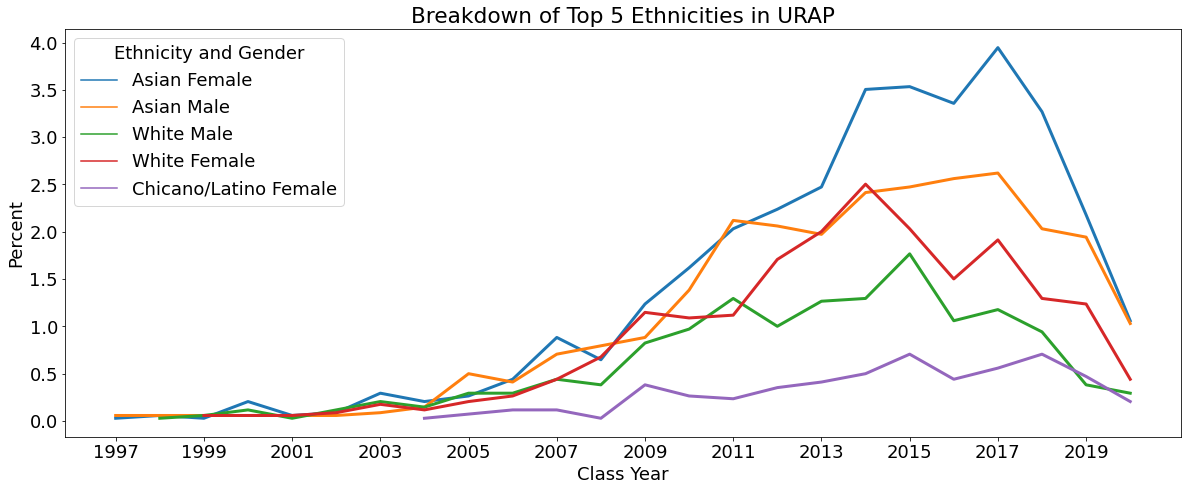

In [137]:
plt.xticks(np.arange(1995, 2021, 2))
plt.title("Breakdown of Top 5 Ethnicities in URAP")
sns.lineplot(data = top_5_ethnic, x = "Class Year", y = "Percent", hue = "Ethnicity and Gender", ci=None, linewidth = 3);


In [138]:
least_common_ethnic = persisted_stem.groupby("Ethnicity and Gender").count()#.reset_index()
least_common_ethnic["Count"] = least_common_ethnic["Class Year"]
least_common_ethnic = least_common_ethnic[["Count"]].reset_index().sort_values(by = "Count", ascending = True)

least_common_ethnic.head(10) #least common 100 persist

#least_common_ethnic = least_common_ethnic[least_common_ethnic["Ethnicity and Gender"] != "Decline to State Other"]
least_common_ethnic["Percent"] = least_common_ethnic["Count"] / sum(least_common_ethnic["Count"]) * 100



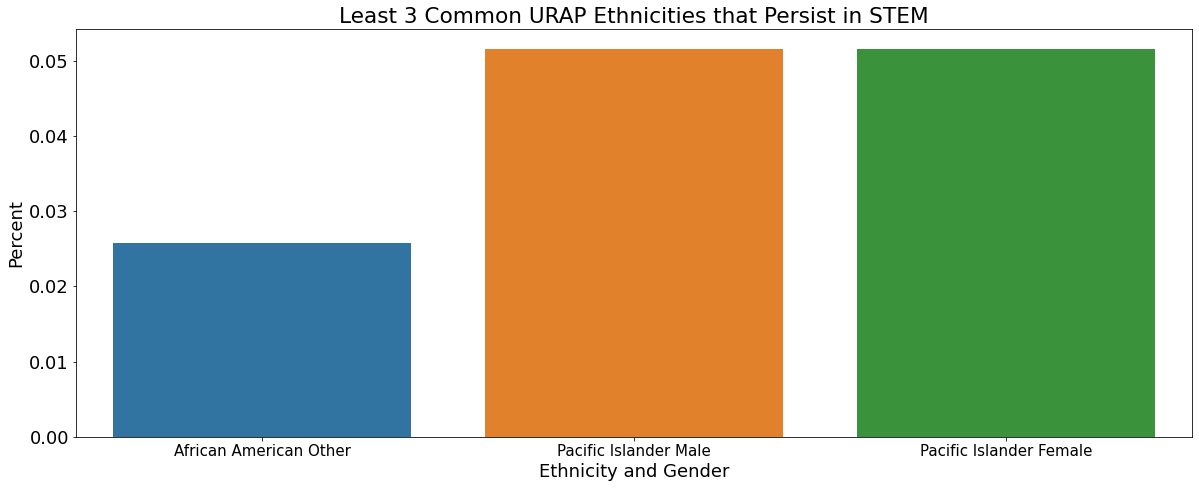

In [139]:
sns.barplot(x = "Ethnicity and Gender", y = "Percent", data = least_common_ethnic.head(3));
plt.title("Least 3 Common URAP Ethnicities that Persist in STEM")
plt.xticks(fontsize=15);

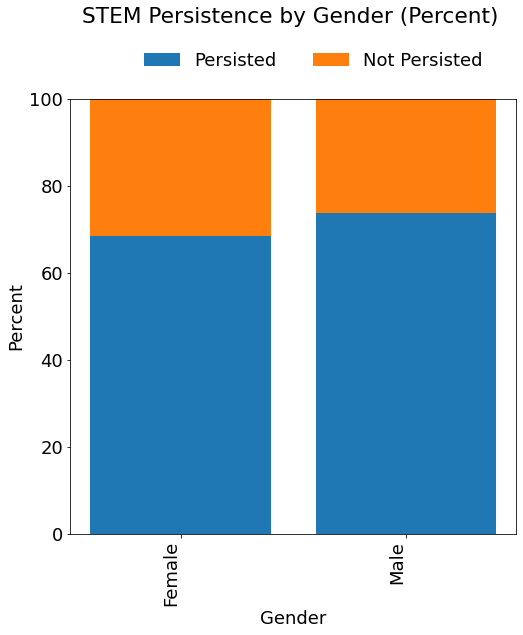

In [140]:
#set figure size
plt.figure(figsize=(8, 8))

#percent graph, so total the counts to get percent of persistence 
total = np.array(nopersist_gen) + np.array(persist_gen)
proportion_per_gen = np.true_divide(persist_gen, total) * 100
proportion_noper_gen = np.true_divide(nopersist_gen, total) * 100

#plot stacked bars, with % persistence on bottom
plt.bar(ind, proportion_per_gen,label='Persisted')
plt.bar(ind, proportion_noper_gen, label='Not Persisted', bottom=proportion_per_gen)

#label graphs
plt.xticks(ind, gen)
plt.ylabel("Percent")
plt.xlabel("Gender")
plt.legend(loc='lower left', bbox_to_anchor= (0.15, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Gender (Percent) \n\n\n")

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.ylim([0, 100])

plt.show()

In [141]:
#STEM degree only grouped by Ethnicity
stem_race =consolidated[(consolidated["Is STEM Degree"] == 1)].groupby("Ethnicity").count().sort_values("Class Year").reset_index()
#then, grouped again by whether or not persisted
donut_race = consolidated[(consolidated["Is STEM Degree"] == 1)].groupby(["Ethnicity", "STEM Job Within 5 Years"]).count()

#manually added from donut_race:
nested_eth = np.array([[29, 68], [83, 158], [79, 174], [380, 768], [641, 1713]])

In [142]:
#create a df with individuals with stem degrees who persiseted by race
persist_race = consolidated[(consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] == 1)].groupby(["Ethnicity"]).count().sort_values("Class Year", ascending = False).reset_index()

#create a df with individuals with stem degrees who DID NOT persist by race
nopersist_race = consolidated[((consolidated["Is STEM Degree"] == 1) & (consolidated["STEM Job Within 5 Years"] == 0))].groupby(["Ethnicity"]).count().sort_values("Class Year", ascending = False).reset_index()


#merge the two into 1
persistence_race = persist_race[["Ethnicity", "Class Year"]].merge(nopersist_race[["Ethnicity", "Class Year"]], left_on = "Ethnicity", right_on = "Ethnicity", how = "inner")
persistence_race.rename(columns={"Class Year_x": "Persist", "Class Year_y": "Not Persist"}, inplace = True)

#counts of each group
persist_names = persist_race["Ethnicity"]
persist_size= persistence_race["Persist"]
nopersist_size = persistence_race["Not Persist"]

#create percentages of each nopersist group
nopersist_percent = [str(round((number / sum(nopersist_size)*100 ),2)) + "%" for number in nopersist_size]

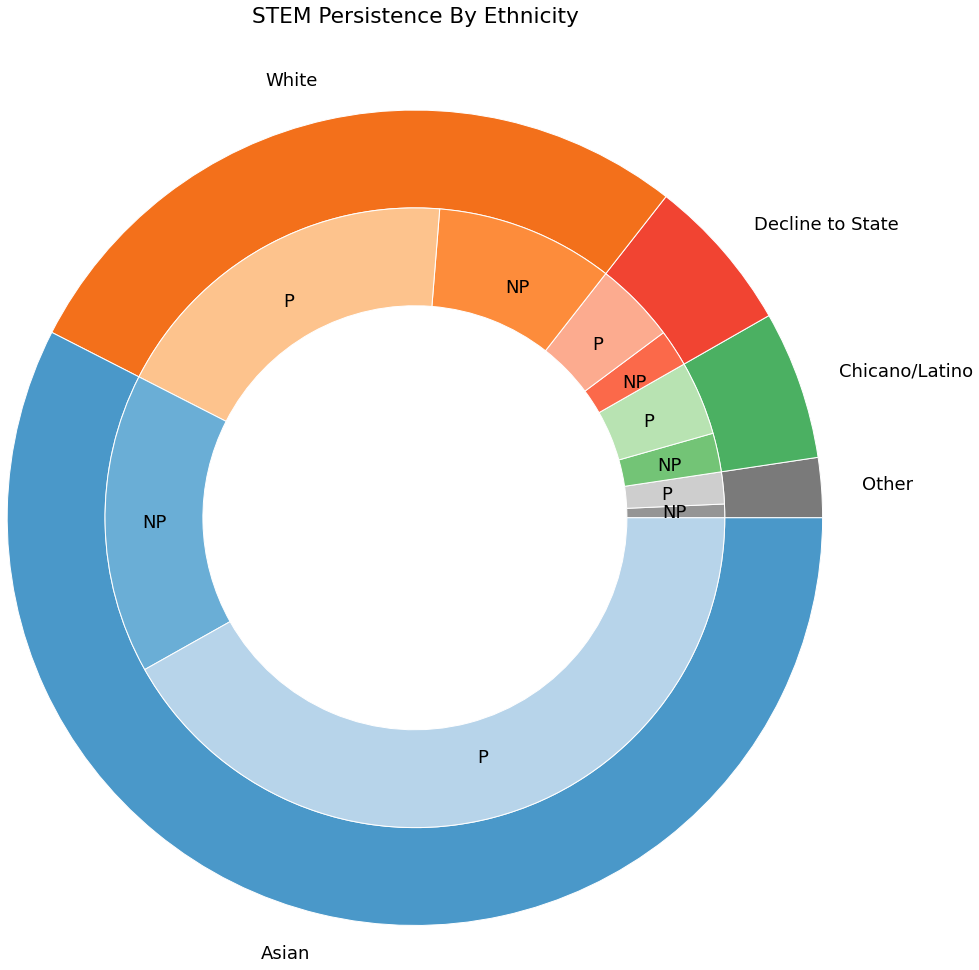

In [143]:
#STEM Majors by race, then persistence by job attainment in 5 years 
fig, ax = plt.subplots()
size = .6

#labels
group_names=['Other', 'Chicano/Latino', "Decline to State", "White", "Asian"]
subgroup_names = ["NP", "P",
                 "NP", "P",
                 "NP", "P",
                 "NP", "P",
                 "NP", "P"]
#colors
cmap = plt.get_cmap("tab20c")

outer_colors = [grey(0.6), #other
                g(0.6), #Chicano/Latino
                r(0.6), #Decline
                o(0.6), #White
                b(0.6)] #asian
inner_colors = [grey(0.5), grey(0.3),
                g(0.5), g(0.3),
                r(0.5), r(0.3),
                o(0.5), o(0.3),
                b(0.5), b(0.3)]

#plot both pie graphs, nested
ax.pie(nested_eth.sum(axis=1), labels = group_names, radius=2.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
ax.pie(nested_eth.flatten(), labels = subgroup_names, radius=2.5-size,labeldistance=.8, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

#title
ax.set(aspect="equal")
ax.set_title("STEM Persistence By Ethnicity", y=1.7)

plt.show()

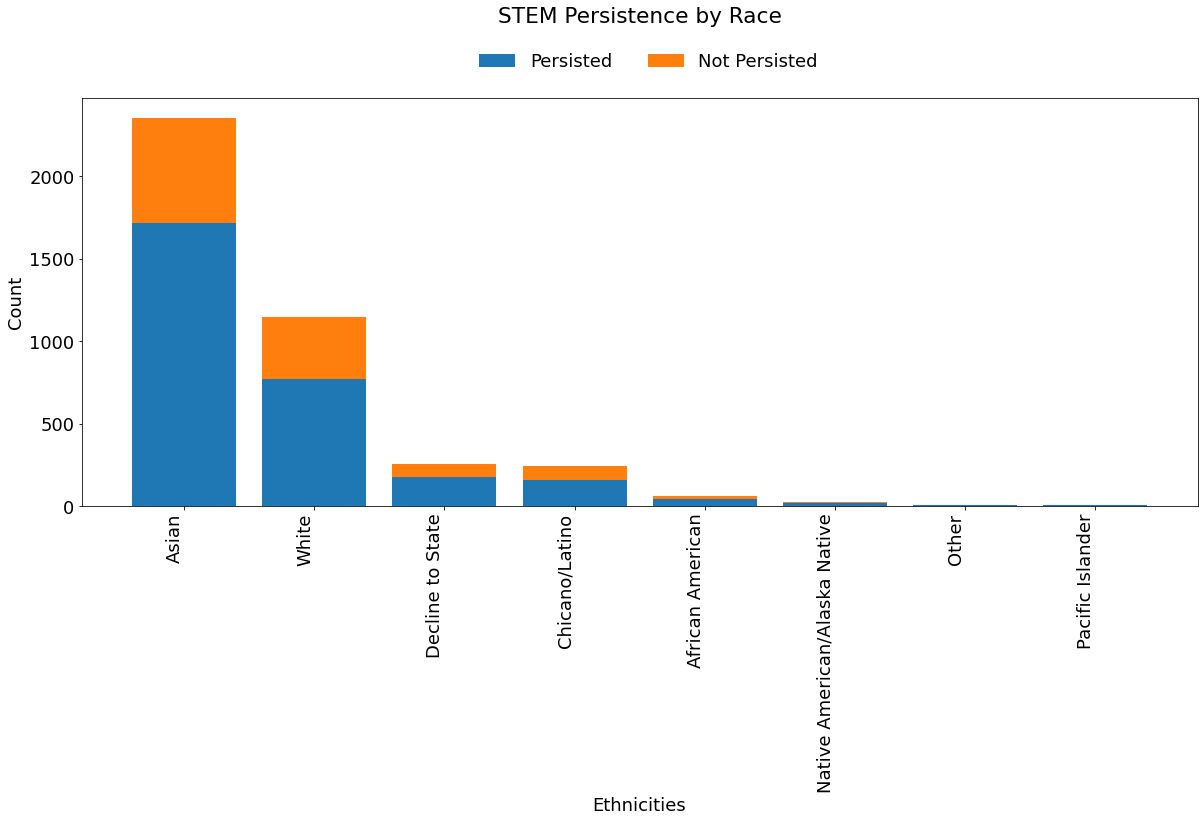

In [144]:
ind = [x for x, _ in enumerate(persist_names)]

#plot stacked bar with persisetnce on bottom
plt.bar(ind, persist_size, width=0.8, label='Persisted')
plt.bar(ind, nopersist_size, width=0.8, label='Not Persisted', bottom=persist_size)

#labels
plt.xticks(ind, persist_names)
plt.ylabel("Count")
plt.xlabel("Ethnicities")
plt.legend(loc='lower left', bbox_to_anchor= (0.35, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Race\n\n\n")
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

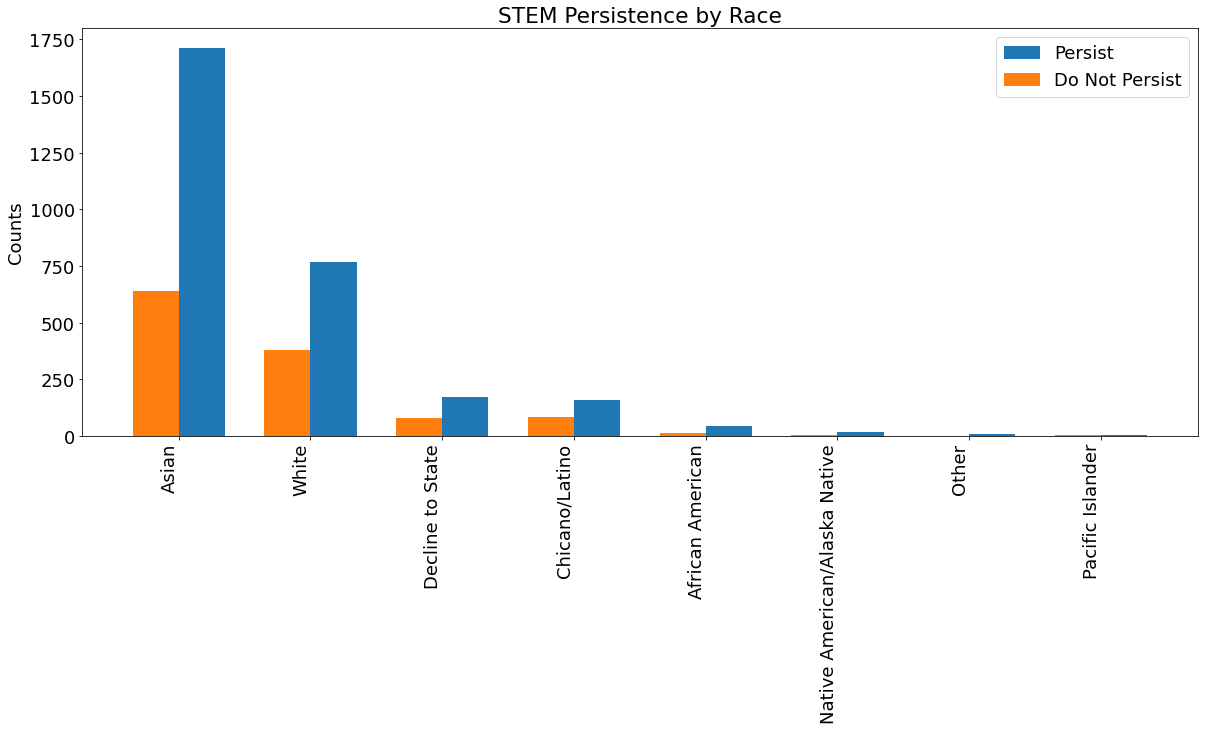

In [145]:
#side by side stem persistence by race

N = 8

ind = np.arange(N) 
width = 0.35

#race persisted

plt.bar(ind + width, (persist_size), width,
    label='Persist')
plt.bar(ind, nopersist_size
, width, label='Do Not Persist')

plt.ylabel('Counts')
plt.title('STEM Persistence by Race')

plt.xticks(ind + width / 2, persist_names)
plt.yticks(np.arange(0, 2000, 250), np.arange(0, 2000, 250))
plt.legend(loc='best')
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

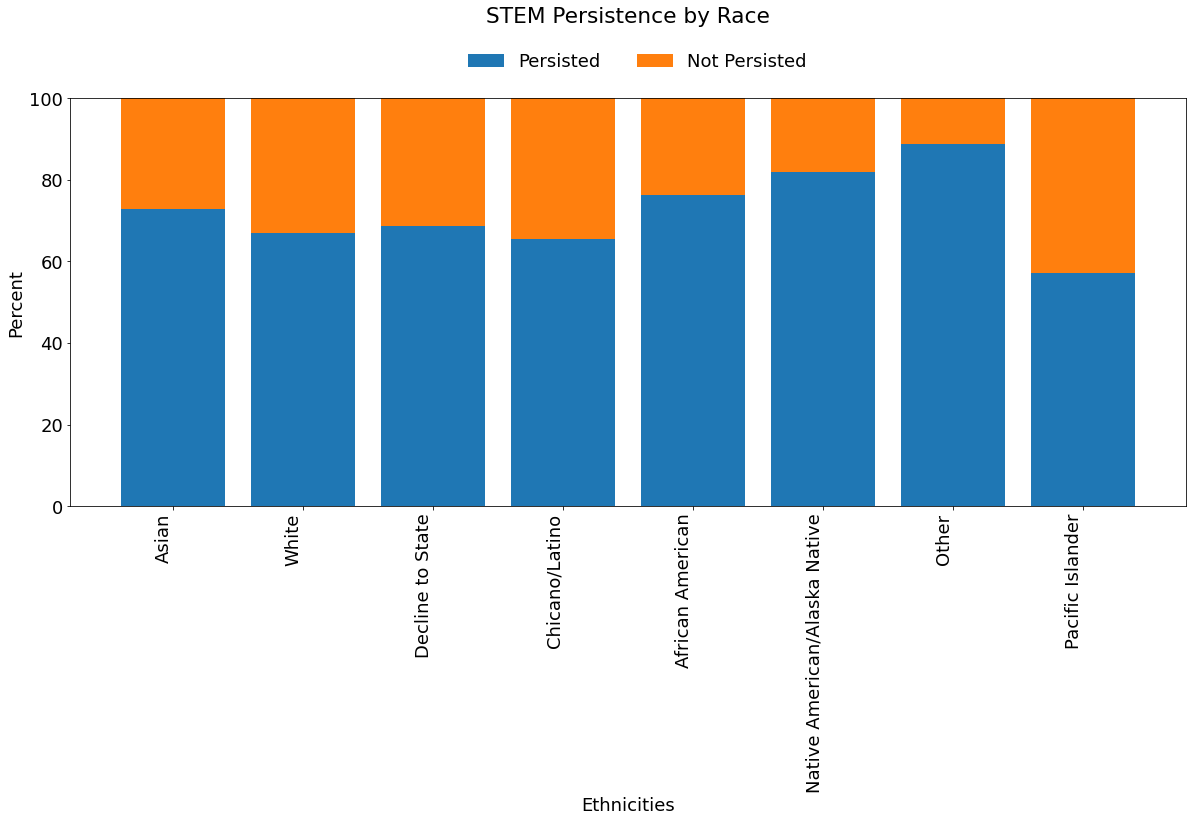

In [146]:
#graph by percents

#sum numbers, turn to percents
total = persist_size + nopersist_size
proportion_persist = np.true_divide(persist_size, total) * 100
proportion_nopersist = np.true_divide(nopersist_size, total) * 100

#plot stacked bar, persistence on bottom (blue)
plt.bar(ind, proportion_persist, width=0.8, label='Persisted')
plt.bar(ind, proportion_nopersist, width=0.8, label='Not Persisted', bottom=proportion_persist)

#labels
plt.xticks(ind, persist_names)
plt.ylabel("Percent")
plt.xlabel("Ethnicities")
plt.legend(loc='lower left', bbox_to_anchor= (0.35, 1.05), ncol=4,
            borderaxespad=0, frameon=False)
plt.title("STEM Persistence by Race\n\n\n")

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.ylim([0, 100])

plt.show()

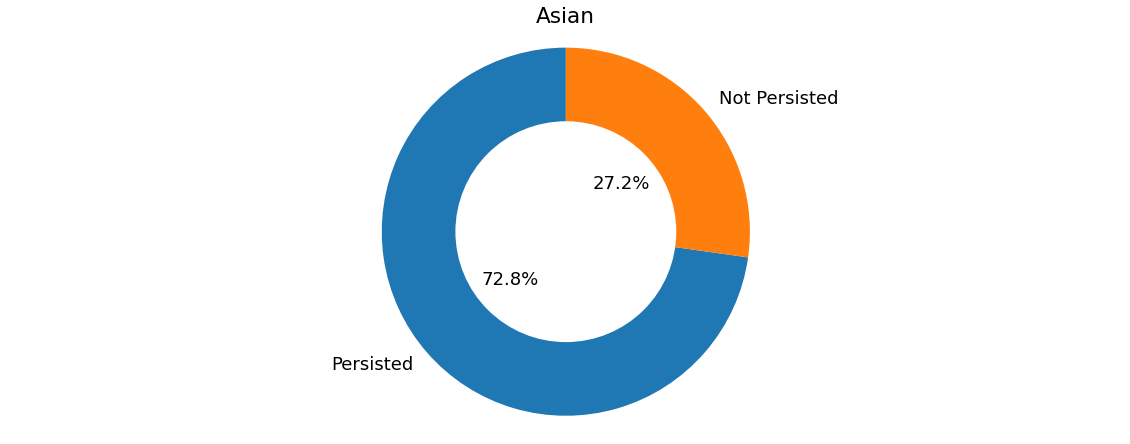

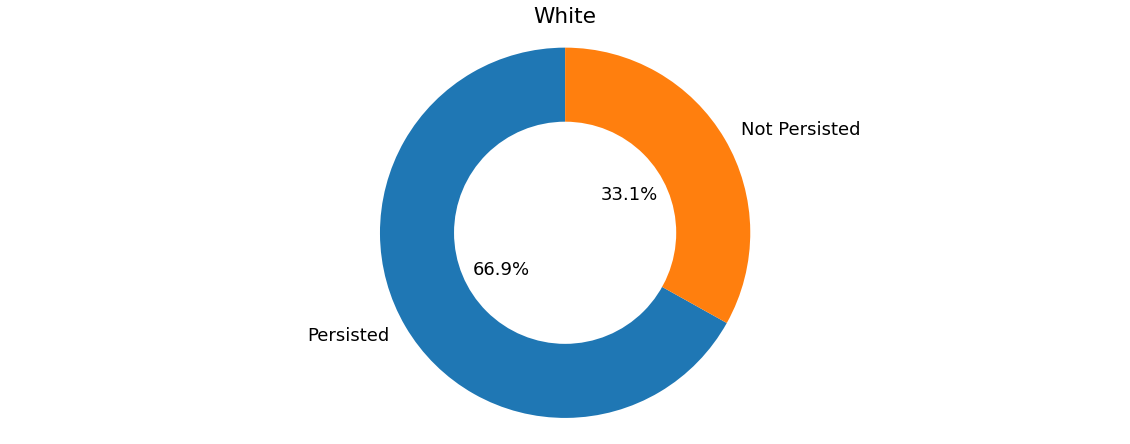

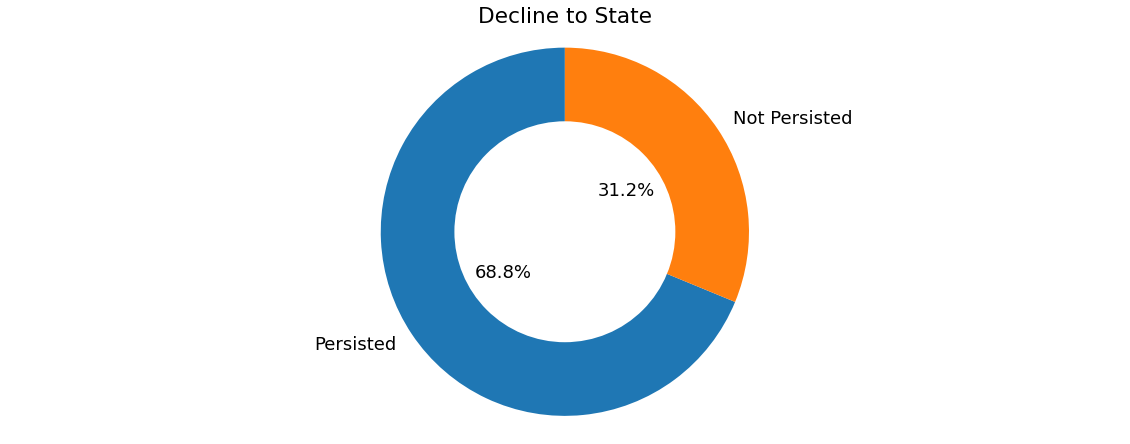

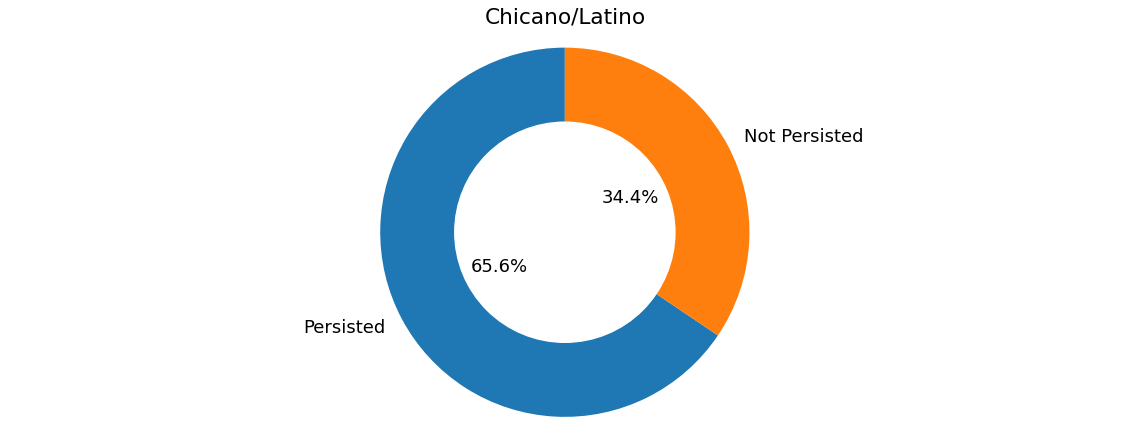

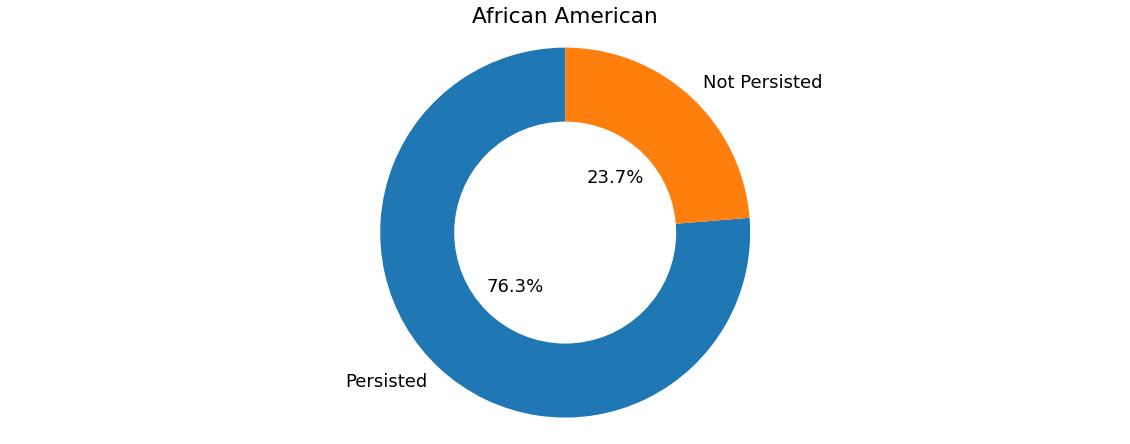

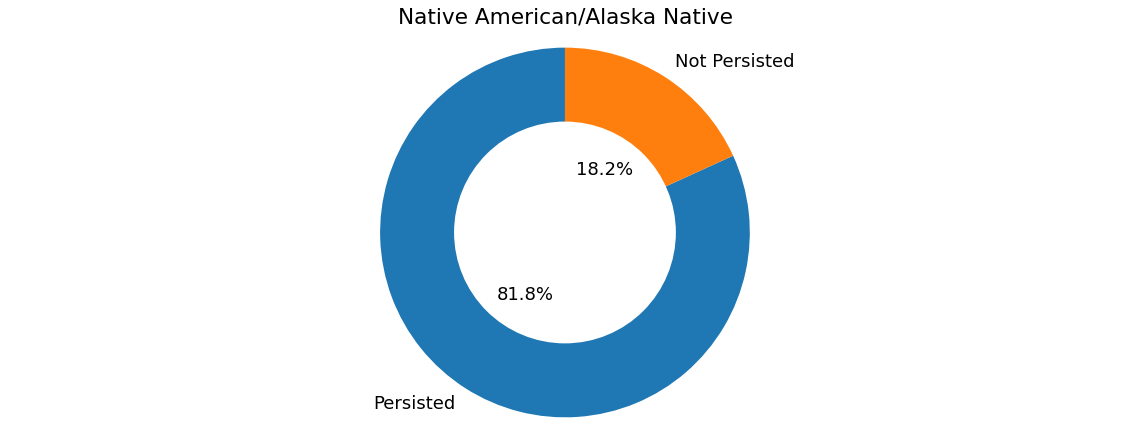

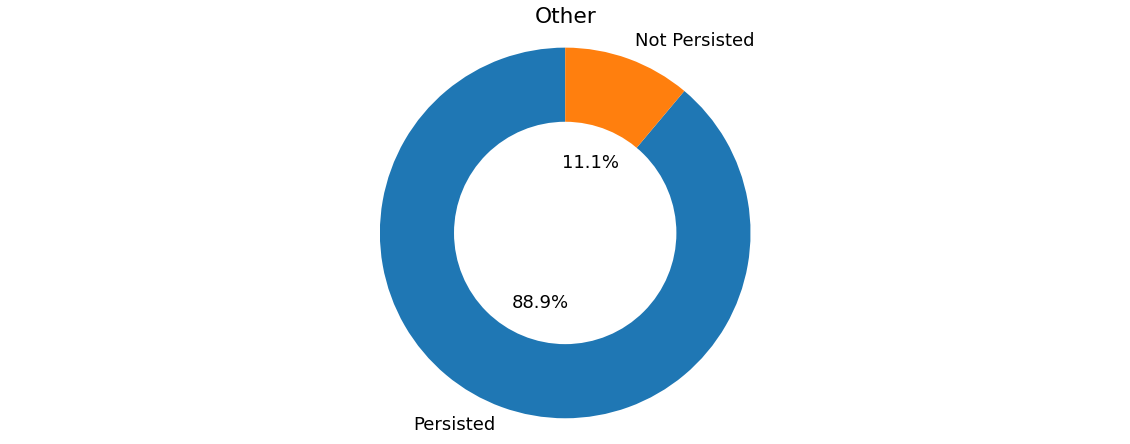

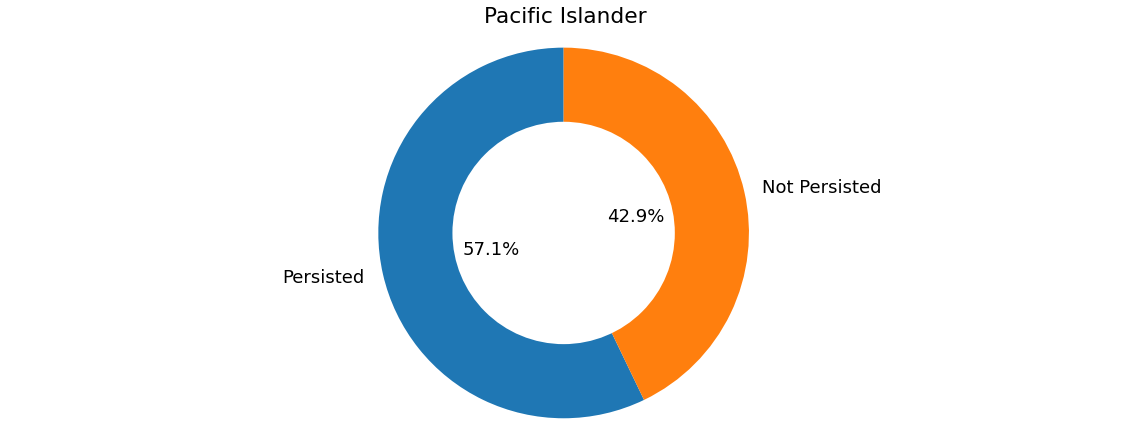

In [147]:
#Pie chart: Each race has its own circle with persistence %
t = persist_race.sort_values("Ethnicity")["Ethnicity"]
labels = ["Persisted", "Not Persisted"]
sizes = proportion_persist 

for i in np.arange(0, 8, 1):
    fig1, ax1 = plt.subplots()
    ax1.pie([sizes[i], 100 - sizes[i]], labels=labels, pctdistance=0.40, autopct='%1.1f%%', startangle=90)
    circle = plt.Circle((0,0),0.6,fc='white')
    donut = plt.gcf()
    donut.gca().add_artist(circle)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(str(t[i]))
    plt.show()

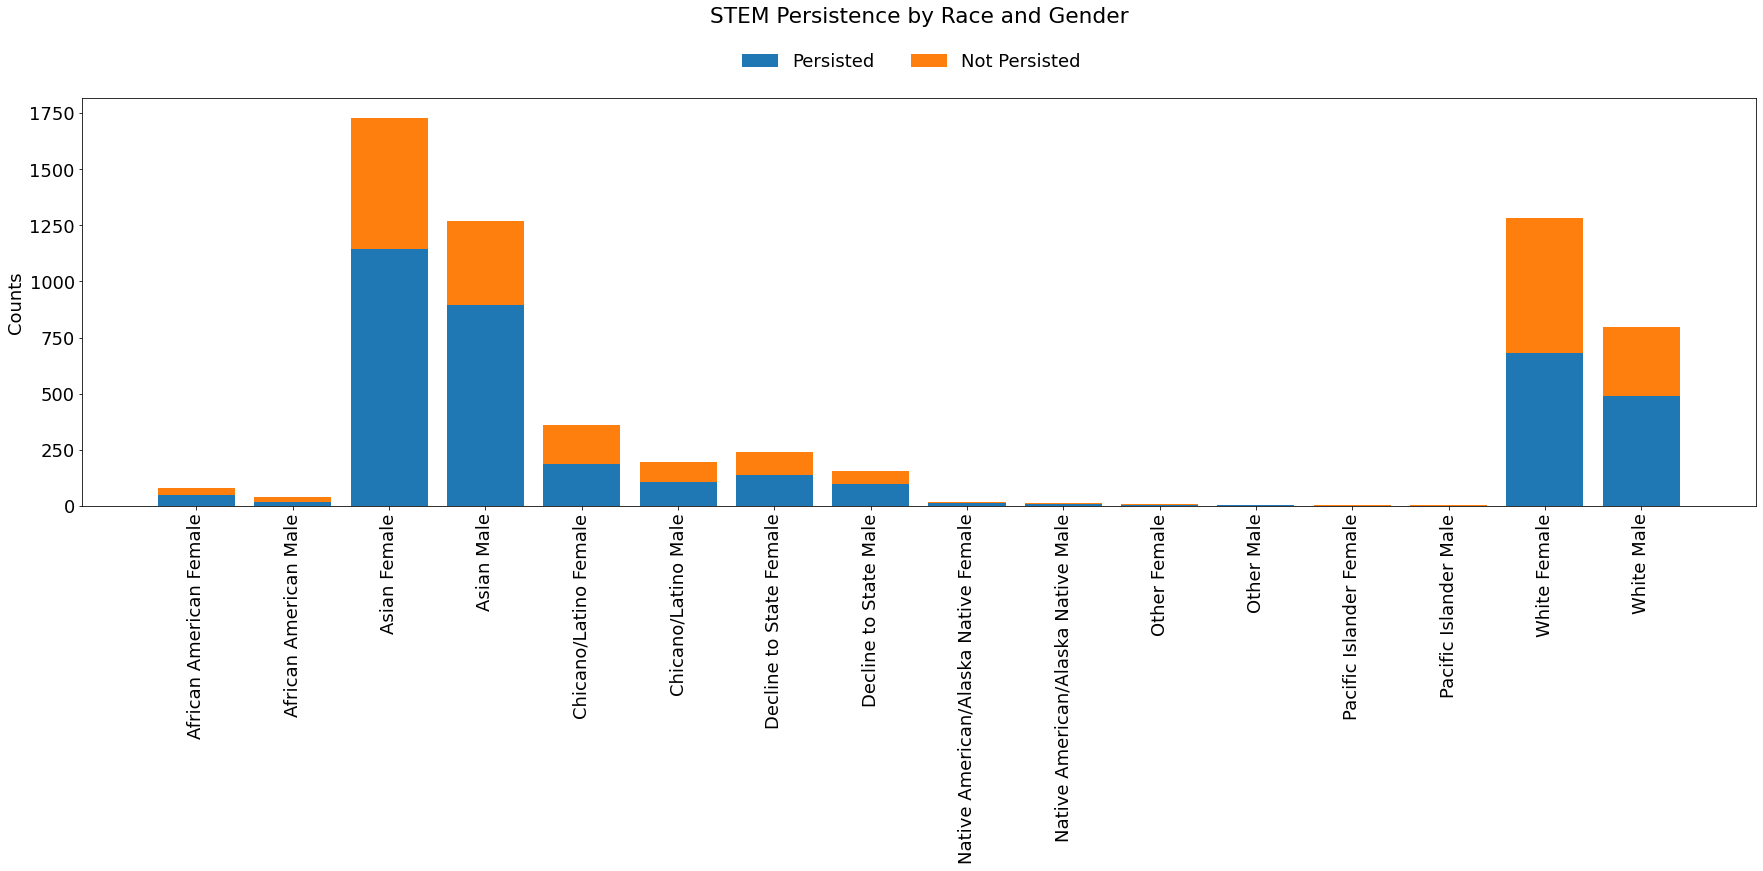

In [148]:
# graphing persistence by both ethnicity and gender
eth_gender = consolidated.copy(deep=True)
FM_only = eth_gender[eth_gender["Gender"].isin(["F", "M"])].reset_index()

FM_persist = FM_only.pivot_table(
    values="ID",
    index="Ethnicity and Gender",
    columns="STEM Job Within 5 Years",
    aggfunc=len
).fillna(0).rename(columns={0: "Not Persisted", 1:"Persisted"})[["Persisted", "Not Persisted"]]

eth_genders = FM_persist.index
# gender order sorted by decreasing counts of top_n_degrees
options = consolidated.groupby("Ethnicity and Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(FM_persist))
i = 0

plt.figure(figsize=[30, 7.5])

for col in FM_persist.columns:
    plt.bar(eth_genders, FM_persist[col], bottom=prev, label=col)#, color=colormap(len(options))[i])
    prev += np.array(FM_persist[col])
    i += 1

plt.ylabel('Counts')
plt.title("STEM Persistence by Race and Gender\n\n\n")
plt.legend()
plt.xticks(rotation = 90)

plt.legend(loc='lower left', bbox_to_anchor= (0.39, 1.05), ncol=5,
            borderaxespad=0, frameon=False)
plt.show()

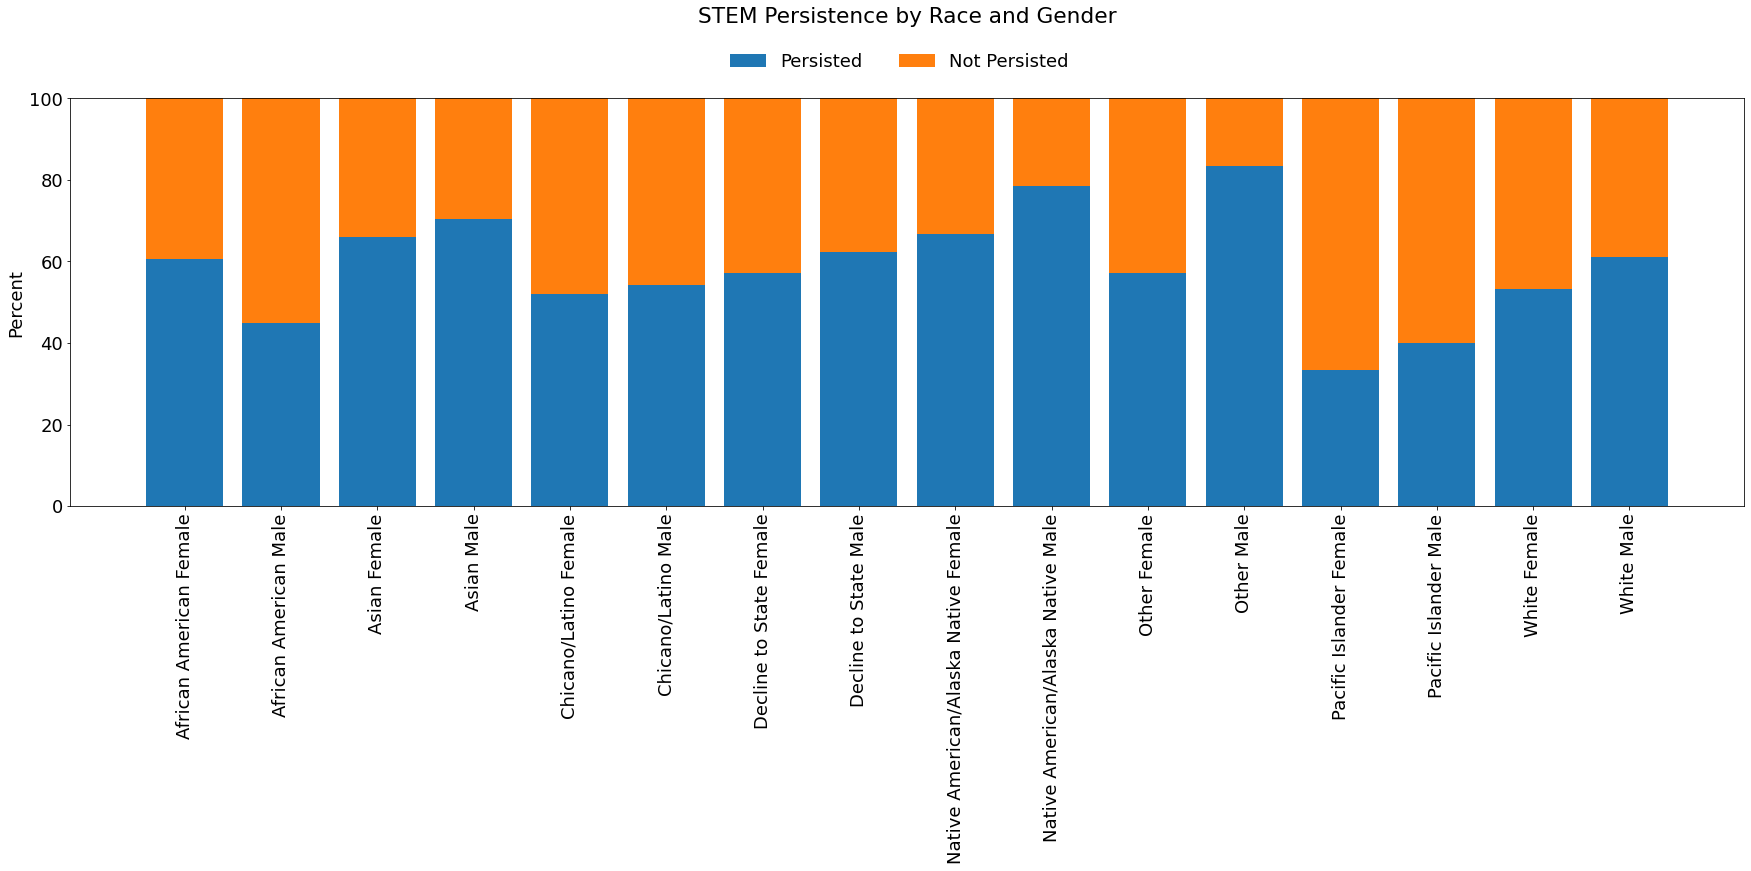

In [149]:
#persistence in ethnicity and gender by percent
FM_persist = normalize(FM_persist, percent=True, axis=1)

eth_genders = FM_persist.index
# gender order sorted by decreasing counts of top_n_degrees
options = consolidated.groupby("Ethnicity and Gender").count().sort_values("ID", ascending=False).index
prev = np.zeros(len(FM_persist))
i = 0

plt.figure(figsize=[30, 7.5])

for col in FM_persist.columns:
    plt.bar(eth_genders, FM_persist[col], bottom=prev, label=col)#, color=colormap(len(options))[i])
    prev += np.array(FM_persist[col])
    i += 1

plt.ylabel('Percent')
plt.title("STEM Persistence by Race and Gender\n\n\n")
plt.legend()
plt.xticks(rotation = 90)
plt.ylim([0, 100])

plt.legend(loc='lower left', bbox_to_anchor= (0.39, 1.05), ncol=5,
            borderaxespad=0, frameon=False)
plt.show()

# Appendix
There is some additional data analysis captured here. 

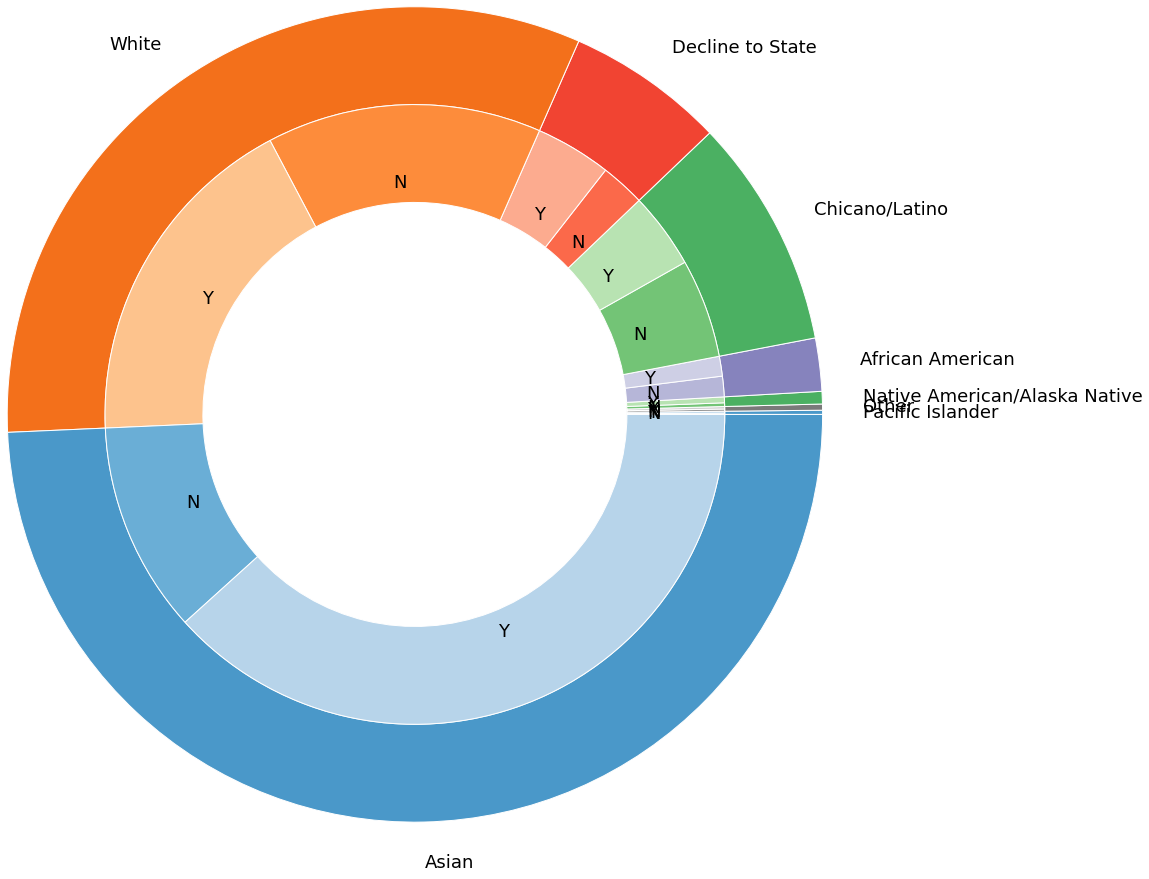

In [150]:
#STEM OR NON STEM BREAKDOWN

#ethicity --> stem (S) / non stem (NS) --> persist or not persist
fig, ax = plt.subplots()

size = .6
#manual inspection of :consolidated.groupby(["Ethnicity", "Is STEM Degree"]).count().reset_index()
vals = np.array([[5, 8], [9, 10], [15, 24], [84, 81], [405, 311], [182, 311], [1124, 1409], [863, 3005]])
group_names=["Pacific Islander", "Other", "Native American/Alaska Native", "African American", "Chicano/Latino","Decline to State", "White", "Asian"]
subgroup_names = ["N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y",
                 "N", "Y"]

cmap = plt.get_cmap("tab20c")
b, g, r, o, p, grey=[plt.cm.Blues, plt.cm.Greens,plt.cm.Reds,  plt.cm.Oranges,
        plt.cm.Purples, plt.cm.Greys]
outer_colors = [b(0.6), #pacific
                                                                      grey(0.6), #other
                                                                      g(0.6), #Native
                                                                      p(0.6), #AA
                                                                      g(0.6), #Chicano/Latino
                                                                      r(0.6), #Decline
                                                                      o(0.6), #White
                                                                      b(0.6)] #asian
inner_colors = [b(0.5), b(0.3), 
                           grey(0.5), grey(0.3), 
                           g(0.5), g(0.3), 
                           p(0.4), p(0.3),
                          g(0.5), g(0.3),
                          r(0.5), r(0.3),
                          o(0.5), o(0.3),
                          b(0.5), b(0.3)]

ax.pie(vals.sum(axis=1), labels = group_names, radius=2.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), labels = subgroup_names, radius=2.5-size,labeldistance=.75, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal")
plt.show()

Q: What % of men and women for each race/ethnicity went through the program each year?

In [151]:
consolidated.pivot_table(
    values="ID",
    index=["Ethnicity", "Gender"],
    columns="Class Year",
    aggfunc=len
).fillna("")

Class Year                           1997 1998 1999  2000 2001  2002  2003  \
Ethnicity                     Gender                                         
African American              F            1.0  1.0        2.0   1.0   3.0   
                              M                                              
                              U                                              
Asian                         D                                              
                              F       3.0  5.0  7.0  11.0  4.0  11.0  16.0   
                              M       2.0  4.0  2.0   7.0  2.0   5.0  10.0   
                              U                                              
                              X                                              
Chicano/Latino                F            1.0        1.0        2.0   2.0   
                              M                 3.0              1.0   3.0   
                              U                                              
Decline to State              F                 4.0   4.0  1.0   4.0   5.0   
                              M            1.0             2.0   2.0         
                              U                                              
Native American/Alaska Native F                            1.0               
                              M            1.0                               
                              U                                              
Other                         F                 2.0              1.0   1.0   
                              M                                        1.0   
Pacific Islander              F                                              
                              M                                              
White                         F            4.0  6.0   9.0  6.0  15.0  24.0   
                              M            4.0  4.0  14.0  2.0   9.0   9.0   
                              U                                              
                              X                                              

Class Year                            2004  2005  2006  2007  2008  2009  \
Ethnicity                     Gender                                       
African American              F              1.0   1.0   3.0         5.0   
                              M        1.0         1.0   1.0   1.0   1.0   
                              U                                            
Asian                         D                                            
                              F       15.0  25.0  43.0  60.0  56.0  73.0   
                              M       10.0  28.0  33.0  38.0  52.0  58.0   
                              U                          1.0               
                              X                                            
Chicano/Latino                F        3.0   2.0   6.0   8.0   5.0  19.0   
                              M        1.0   1.0   4.0   8.0   6.0   9.0   
                              U                                            
Decline to State              F        3.0   4.0   6.0  14.0  14.0  17.0   
                              M        3.0   4.0   8.0  11.0  13.0  11.0   
                              U                                1.0         
Native American/Alaska Native F                                            
                              M                    1.0   1.0   1.0         
                              U                                            
Other                         F        1.0         4.0   2.0               
                              M                          2.0   2.0   2.0   
Pacific Islander              F                                2.0         
                              M                                            
White                         F       12.0  19.0  28.0  29.0  49.0  82.0   
                              M       15.0  17.0  23.0  30.0  28.0  5